In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Subset
from transformers import AutoModelForSequenceClassification, AutoTokenizer, BertConfig, BertForSequenceClassification, BertTokenizer
from datasets import load_dataset
from tqdm import tqdm
from copy import deepcopy
import torch.nn.functional as F

# --- Classes Utilitaires ---

class FeatureHook:
    """Intercepte les activations d'une couche specifique."""
    def __init__(self, module):
        self.hook = module.register_forward_hook(self.hook_fn)
        self.features = None

    def hook_fn(self, module, input, output):
        # Pour les transformers, output peut etre un tuple
        if isinstance(output, tuple):
            self.features = output[0]
        else:
            self.features = output

    def close(self):
        self.hook.remove()

class RigaExtractor(nn.Module):
    """Extractor network that projects weights to watermark space."""
    def __init__(self, weight_size, watermark_len):
        super().__init__()
        self.fc1 = nn.Linear(weight_size, 100, bias=False)
        self.fc2 = nn.Linear(100, watermark_len, bias=False)
        self.sig = nn.Sigmoid()

    def forward(self, x):
        out = self.fc1(x)
        out = self.sig(out)
        out = self.fc2(out)
        out = self.sig(out)
        return out


# --- Riga Detector Network ---

class RigaDetector(nn.Module):
    """Detector network that distinguishes watermarked from non-watermarked weights."""
    def __init__(self, weight_size):
        super().__init__()
        self.fc1 = nn.Linear(weight_size, 100, bias=False)
        self.fc2 = nn.Linear(100, 1, bias=False)
        self.sig = nn.Sigmoid()

    def forward(self, x):
        out = self.fc1(x)
        out = self.sig(out)
        out = self.fc2(out)
        out = self.sig(out)
        return out




# --- Classe Principale RIGA pour Sentiment ---

class RIGASentiment:
    def __init__(self, model_id="prajjwal1/bert-tiny", device="cuda"):
        self.device = device
        self.model_id = model_id
        
        # Chargement du modele
        # self.model = AutoModelForSequenceClassification.from_pretrained(
        #     model_id, num_labels=2, use_safetensors=True
        # ).to(device)
        # self.tokenizer = AutoTokenizer.from_pretrained(model_id)
        config = BertConfig.from_pretrained(model_id, num_labels=2)
        self.model = BertForSequenceClassification.from_pretrained(model_id, config=config).to(device)
        self.tokenizer=BertTokenizer.from_pretrained(model_id)
        # Configuration par defaut
        self.config = {
           "layer_name": "bert.encoder.layer.1.output.dense.weight",
            "hook_layer":  "bert.encoder.layer.1.output.dense",
             # "layer_name": "classifier",
            "watermark_len": 64,
            "lr": 5e-5,
            "lr_det": 1e-3,        # Learning rate for detector
            "lambda_1": 1.0,       # Watermark loss weight
            "lambda_2": 1.0,       # Adversarial loss weight
            "epochs": 30,
            "clip_value": 0.01,
        }
        
        self.saved_keys = {}
        
    def list_layers(self):
        """Affiche les couches disponibles pour le watermarking."""
        print("Couches disponibles (modules):")
        for name, module in self.model.named_modules():
            if name:
                print(f"  {name}")
    
    def _get_target_layer(self, model, layer_name):
        """Recupere le module PyTorch correspondant au nom."""
        for name, module in model.named_modules():
            if name == layer_name:
                return module
        raise ValueError(f"Couche {layer_name} introuvable.")

    def _get_target_weights(self, model):
        """Recupere le tenseur des poids de la couche cible."""
        for name, param in model.named_parameters():
            if name == self.config["layer_name"]:
                return param
        raise ValueError(f"Parametre {self.config['layer_name']} introuvable.")
    

    
    def embed(self, train_dataloader, eval_dataloader, trigger_dataset):
        """
        Incorpore la marque RIGA pendant le finetuning.
        """
        print(f"--- Demarrage Embedding RIGA ({self.config['layer_name']}) ---")
        
        # 1. Preparation des modeles

        watermarked_model = self.model
        watermarked_model.train()
        
        # 2. Generation des cles et trigger set


        target_weights = self._get_target_weights(watermarked_model)
        with torch.no_grad():
            init_w = torch.flatten(target_weights.mean(dim=0)).clone()
            weight_size = len(init_w)

        print(f"Dimension vecteur poids : {weight_size} | Watermark : {self.config['watermark_len']} bits")



        
        target_wm = torch.randint(0, 2, (self.config["watermark_len"],)).float().to(self.device)
        random_wm = torch.randint(0, 2, (self.config["watermark_len"],)).float().to(self.device)
        

        print(f"Watermark length: {self.config['watermark_len']} bits")
        
        # 3. Initialize networks
        extractor = RigaExtractor(weight_size, self.config["watermark_len"]).to(self.device)
        detector = RigaDetector(weight_size).to(self.device)

        
        # 4. Optimiseurs
        optimizer = torch.optim.AdamW([
            {'params': watermarked_model.parameters(), 'lr': self.config["lr"]},
            {'params': extractor.parameters(), 'lr': self.config["lr"], 'betas': (0.5, 0.999)}
        ])
        optimizer_det = torch.optim.Adam(
            detector.parameters(),
            lr=self.config["lr_det"],
            betas=(0.5, 0.999)
        )
        
        ce_loss = nn.CrossEntropyLoss()
        bce_loss = nn.BCELoss()
        mse_loss = nn.MSELoss()
        
        # 5. Boucle d'entrainement
        for epoch in range(self.config["epochs"]):
            pbar = tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{self.config['epochs']}")
            correct = 0
            total = 0
            
            for batch in pbar:
                input_ids = batch["input_ids"].to(self.device)
                attention_mask = batch["attention_mask"].to(self.device)
                labels = batch["labels"].to(self.device)
                

                # Get current weights
                current_weights = self._get_target_weights(watermarked_model)
                w = torch.flatten(current_weights.mean(dim=0))

                # Sort weights for detector (as in original Riga)
                w_sorted = torch.sort(w.detach())[0]
                init_w_sorted = torch.sort(init_w.detach())[0]
                # === A. Train Detector ===
                optimizer_det.zero_grad()

                # Detector should output 1 for non-watermarked, 0 for watermarked
                out_det_wat = detector(w_sorted)
                out_det_non = detector(init_w_sorted)

                loss_det_non = bce_loss(out_det_non, torch.ones(1).to(self.device))
                loss_det_wat = bce_loss(out_det_wat, torch.zeros(1).to(self.device)) #non=1 wat=0
                loss_det = loss_det_non + loss_det_wat

                loss_det.backward(retain_graph=True)
                optimizer_det.step()

                # Clip detector weights (WGAN-style)
                with torch.no_grad():
                    for param in detector.parameters():
                        param.clamp_(-self.config["clip_value"], self.config["clip_value"])



                
                # --- B. Entrainement Modele Tatoue ---
                optimizer.zero_grad()
                
                # Tache principale (classification)
                outputs = watermarked_model(input_ids=input_ids, attention_mask=attention_mask)
                l_main = ce_loss(outputs.logits, labels)
                

                
                # Watermark extraction loss
                w_current = torch.flatten(self._get_target_weights(watermarked_model).mean(dim=0))
                out_watermark = extractor(w_current)
                init_out_watermark = extractor(init_w.detach())

                loss_ext_wat = bce_loss(out_watermark, target_wm)
                loss_ext_init = bce_loss(init_out_watermark, random_wm)

                # Adversarial loss (fool detector - make it think watermarked is non-watermarked)
                w_sorted_current = torch.sort(w_current.detach())[0]
                out_det_current = detector(w_sorted_current)
                loss_adv = bce_loss(out_det_current, torch.ones(1).to(self.device))

                # Total loss
                l_total = (l_main +
                          self.config["lambda_1"] * (loss_ext_wat + loss_ext_init) -
                          self.config["lambda_2"] * loss_adv)
                l_total.backward()
                optimizer.step()
                
                # Metrics
                preds = torch.argmax(outputs.logits, dim=-1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)
                
                ber = self._compute_ber(out_watermark.mean(dim=0), target_wm)
                acc = 100. * correct / total
                pbar.set_postfix(L_Main=f"{l_main.item():.3f}", L_Wat=f"{(loss_ext_wat + loss_ext_init).item():.3f}",
                                BER=f"{ber:.2f}", Acc=f"{acc:.1f}%")
            
            # Evaluation en fin d'epoch
            if eval_dataloader:
                eval_acc = self.evaluate(watermarked_model, eval_dataloader)
                print(f"Epoch {epoch+1} | Eval Accuracy: {eval_acc:.2f}%")
        
        # Sauvegarde des cles
        self.saved_keys = {
           "watermark_target": target_wm,
            "watermarked_model": watermarked_model,
            "extractor": extractor,
            "detector": detector,
            "init_w": init_w,
        }
        
        final_ber, _ = self.extract(watermarked_model)
        print(f"\n--- Embedding termine | BER final: {final_ber:.2f} ---")
        return watermarked_model
    
    def evaluate(self, model, dataloader):
        """Evalue la precision du modele."""
        model.eval()
        correct = 0
        total = 0
        
        with torch.no_grad():
            for batch in dataloader:
                input_ids = batch["input_ids"].to(self.device)
                attention_mask = batch["attention_mask"].to(self.device)
                labels = batch["labels"].to(self.device)
                
                outputs = model(input_ids=input_ids, attention_mask=attention_mask)
                preds = torch.argmax(outputs.logits, dim=-1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)
        
        model.train()
        return 100. * correct / total
    
    def extract(self, suspect_model=None):
        """
        Extrait la marque d'un modele suspect.
        """
        if suspect_model is None:
            suspect_model = self.saved_keys["watermarked_model"]
        
        extractor = self.saved_keys["extractor"]
        watermark_target = self.saved_keys["watermark_target"]

        extractor.eval()

        # Get weights
        try:
            target_weights = self._get_target_weights(suspect_model)
        except ValueError:
            print("Couche cible introuvable dans le modele suspect.")
            return 1.0, None
        
        # Passage du trigger set
        with torch.no_grad():
            w = torch.flatten(target_weights.mean(dim=0))
            pred_wm = extractor(w)
            ber = self._compute_ber(pred_wm, watermark_target)
        

        
        print(f"BER Extrait : {ber:.2f}")
        return ber, pred_wm
    
    @staticmethod
    def _compute_ber(pred, target):
        return ((pred > 0.5).float() != target).float().mean().item()

print("Classes chargees (RIGASentiment, FeatureHook, ProjectionNet)")

/home/latim/PycharmProjects/WatDNN/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Classes chargees (RIGASentiment, FeatureHook, ProjectionNet)


In [2]:
# --- Chargement des donnees SST-2 ---

# Charger le dataset SST-2 (sentiment binaire)
dataset = load_dataset("glue", "sst2")

# Initialiser le watermarker
riga = RIGASentiment(device="cuda" if torch.cuda.is_available() else "cpu")

# Afficher les couches disponibles
riga.list_layers()

# Tokenization
def tokenize_function(examples):
    return riga.tokenizer(examples["sentence"], padding="max_length", truncation=True, max_length=128)

tokenized_dataset = dataset.map(tokenize_function, batched=True)
tokenized_dataset = tokenized_dataset.rename_column("label", "labels")
tokenized_dataset.set_format("torch", columns=["input_ids", "attention_mask", "labels"])

# DataLoaders
train_dataloader = DataLoader(tokenized_dataset["train"], batch_size=64, shuffle=True)
eval_dataloader = DataLoader(tokenized_dataset["validation"], batch_size=64)

print(f"\nTrain samples: {len(tokenized_dataset['train'])}")
print(f"Eval samples: {len(tokenized_dataset['validation'])}")

Loading weights: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 2722.17it/s, Materializing param=bert.pooler.dense.weight]
BertForSequenceClassification LOAD REPORT from: prajjwal1/bert-tiny
Key                                        | Status     | 
-------------------------------------------+------------+-
cls.seq_relationship.weight                | UNEXPECTED | 
cls.predictions.bias                       | UNEXPECTED | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
cls.predictions.transform.dense.weight     | UNEXPECTED | 
cls.seq_relationship.bias                  | UNEXPECTED | 
bert.embeddings.position_ids               | UNEXPECTED | 
cls.predictions.decoder.weight             | UNEXPECTED | 
cls.predictions.decoder.bias               | UNEXPECTED | 
cls.predictions.transform.LayerNor

Couches disponibles (modules):
  bert
  bert.embeddings
  bert.embeddings.word_embeddings
  bert.embeddings.position_embeddings
  bert.embeddings.token_type_embeddings
  bert.embeddings.LayerNorm
  bert.embeddings.dropout
  bert.encoder
  bert.encoder.layer
  bert.encoder.layer.0
  bert.encoder.layer.0.attention
  bert.encoder.layer.0.attention.self
  bert.encoder.layer.0.attention.self.query
  bert.encoder.layer.0.attention.self.key
  bert.encoder.layer.0.attention.self.value
  bert.encoder.layer.0.attention.self.dropout
  bert.encoder.layer.0.attention.output
  bert.encoder.layer.0.attention.output.dense
  bert.encoder.layer.0.attention.output.LayerNorm
  bert.encoder.layer.0.attention.output.dropout
  bert.encoder.layer.0.intermediate
  bert.encoder.layer.0.intermediate.dense
  bert.encoder.layer.0.intermediate.intermediate_act_fn
  bert.encoder.layer.0.output
  bert.encoder.layer.0.output.dense
  bert.encoder.layer.0.output.LayerNorm
  bert.encoder.layer.0.output.dropout
  bert.enc

Map: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1821/1821 [00:00<00:00, 35418.52 examples/s]


Train samples: 67349
Eval samples: 872


In [3]:


# Lancer l'embedding
watermarked_model = riga.embed(
    train_dataloader, 
    eval_dataloader,
    trigger_dataset=tokenized_dataset["train"]
)

--- Demarrage Embedding RIGA (bert.encoder.layer.1.output.dense.weight) ---
Dimension vecteur poids : 512 | Watermark : 64 bits
Watermark length: 64 bits


Epoch 1/30: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 187.68it/s, Acc=79.7%, BER=0.53, L_Main=0.349, L_Wat=0.832]


Epoch 1 | Eval Accuracy: 81.19%


Epoch 2/30: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 183.07it/s, Acc=88.4%, BER=0.47, L_Main=0.096, L_Wat=0.268]


Epoch 2 | Eval Accuracy: 82.22%


Epoch 3/30: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 189.79it/s, Acc=90.8%, BER=0.47, L_Main=0.193, L_Wat=0.131]


Epoch 3 | Eval Accuracy: 82.22%


Epoch 4/30: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 180.22it/s, Acc=92.5%, BER=0.47, L_Main=0.068, L_Wat=0.075]


Epoch 4 | Eval Accuracy: 82.45%


Epoch 5/30: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 178.58it/s, Acc=93.3%, BER=0.47, L_Main=0.330, L_Wat=0.046]


Epoch 5 | Eval Accuracy: 82.11%


Epoch 6/30: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 166.31it/s, Acc=93.9%, BER=0.47, L_Main=0.093, L_Wat=0.028]


Epoch 6 | Eval Accuracy: 82.57%


Epoch 7/30: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 184.97it/s, Acc=94.6%, BER=0.47, L_Main=0.029, L_Wat=0.018]


Epoch 7 | Eval Accuracy: 81.19%


Epoch 8/30: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 175.03it/s, Acc=95.1%, BER=0.47, L_Main=0.121, L_Wat=0.011]


Epoch 8 | Eval Accuracy: 81.42%


Epoch 9/30: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 184.92it/s, Acc=95.6%, BER=0.47, L_Main=0.148, L_Wat=0.007]


Epoch 9 | Eval Accuracy: 81.19%


Epoch 10/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 185.55it/s, Acc=95.9%, BER=0.47, L_Main=0.030, L_Wat=0.004]


Epoch 10 | Eval Accuracy: 80.73%


Epoch 11/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 180.08it/s, Acc=96.3%, BER=0.47, L_Main=0.069, L_Wat=0.003]


Epoch 11 | Eval Accuracy: 81.31%


Epoch 12/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 184.61it/s, Acc=96.5%, BER=0.47, L_Main=0.029, L_Wat=0.002]


Epoch 12 | Eval Accuracy: 81.08%


Epoch 13/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 176.33it/s, Acc=96.8%, BER=0.47, L_Main=0.043, L_Wat=0.001]


Epoch 13 | Eval Accuracy: 80.73%


Epoch 14/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 169.83it/s, Acc=97.0%, BER=0.47, L_Main=0.014, L_Wat=0.001]


Epoch 14 | Eval Accuracy: 80.73%


Epoch 15/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 168.74it/s, Acc=97.2%, BER=0.47, L_Main=0.017, L_Wat=0.000]


Epoch 15 | Eval Accuracy: 79.59%


Epoch 16/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 170.89it/s, Acc=97.4%, BER=0.47, L_Main=0.100, L_Wat=0.000]


Epoch 16 | Eval Accuracy: 79.93%


Epoch 17/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 174.97it/s, Acc=97.6%, BER=0.47, L_Main=0.014, L_Wat=0.000]


Epoch 17 | Eval Accuracy: 79.93%


Epoch 18/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 157.46it/s, Acc=97.6%, BER=0.47, L_Main=0.023, L_Wat=0.000]


Epoch 18 | Eval Accuracy: 80.05%


Epoch 19/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 185.71it/s, Acc=97.8%, BER=0.47, L_Main=0.582, L_Wat=0.000]


Epoch 19 | Eval Accuracy: 79.13%


Epoch 20/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 191.19it/s, Acc=98.0%, BER=0.47, L_Main=0.085, L_Wat=0.000]


Epoch 20 | Eval Accuracy: 78.67%


Epoch 21/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 182.24it/s, Acc=98.1%, BER=0.47, L_Main=0.003, L_Wat=0.000]


Epoch 21 | Eval Accuracy: 79.47%


Epoch 22/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 181.01it/s, Acc=98.2%, BER=0.47, L_Main=0.016, L_Wat=0.000]


Epoch 22 | Eval Accuracy: 79.47%


Epoch 23/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 183.10it/s, Acc=98.2%, BER=0.47, L_Main=0.011, L_Wat=0.000]


Epoch 23 | Eval Accuracy: 78.33%


Epoch 24/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 176.77it/s, Acc=98.3%, BER=0.47, L_Main=0.004, L_Wat=0.000]


Epoch 24 | Eval Accuracy: 78.33%


Epoch 25/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 181.24it/s, Acc=98.4%, BER=0.47, L_Main=0.014, L_Wat=0.000]


Epoch 25 | Eval Accuracy: 79.13%


Epoch 26/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 186.59it/s, Acc=98.5%, BER=0.47, L_Main=0.018, L_Wat=0.000]


Epoch 26 | Eval Accuracy: 79.13%


Epoch 27/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 184.47it/s, Acc=98.5%, BER=0.47, L_Main=0.041, L_Wat=0.000]


Epoch 27 | Eval Accuracy: 78.78%


Epoch 28/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 173.22it/s, Acc=98.6%, BER=0.47, L_Main=0.008, L_Wat=0.000]


Epoch 28 | Eval Accuracy: 79.01%


Epoch 29/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 176.15it/s, Acc=98.7%, BER=0.47, L_Main=0.104, L_Wat=0.000]


Epoch 29 | Eval Accuracy: 79.01%


Epoch 30/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 181.48it/s, Acc=98.8%, BER=0.47, L_Main=0.003, L_Wat=0.000]


Epoch 30 | Eval Accuracy: 78.10%
BER Extrait : 0.00

--- Embedding termine | BER final: 0.00 ---


In [4]:
# --- Test d'Extraction ---

print("=" * 50)
print("TEST D'EXTRACTION")
print("=" * 50)

# Extraction sur le modele watermarke
print("\n1. Extraction sur le modele watermarke:")
ber_watermarked, _ = riga.extract(watermarked_model)

# Extraction sur un modele vierge (non-watermarke)
print("\n2. Extraction sur un modele vierge (devrait avoir BER ~0.5):")
model_id="prajjwal1/bert-tiny"
config = BertConfig.from_pretrained(model_id, num_labels=2)
fresh_model = BertForSequenceClassification.from_pretrained(model_id, config=config).to(device=riga.device)

ber_fresh, _ = riga.extract(fresh_model)

print(f"\nResume:")
print(f"  - BER modele watermarke: {ber_watermarked:.2f} (attendu: ~0.0)")
print(f"  - BER modele vierge: {ber_fresh:.2f} (attendu: ~0.5)")

TEST D'EXTRACTION

1. Extraction sur le modele watermarke:
BER Extrait : 0.00

2. Extraction sur un modele vierge (devrait avoir BER ~0.5):


Loading weights: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 1270.63it/s, Materializing param=bert.pooler.dense.weight]
BertForSequenceClassification LOAD REPORT from: prajjwal1/bert-tiny
Key                                        | Status     | 
-------------------------------------------+------------+-
cls.seq_relationship.weight                | UNEXPECTED | 
cls.predictions.bias                       | UNEXPECTED | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
cls.predictions.transform.dense.weight     | UNEXPECTED | 
cls.seq_relationship.bias                  | UNEXPECTED | 
bert.embeddings.position_ids               | UNEXPECTED | 
cls.predictions.decoder.weight             | UNEXPECTED | 
cls.predictions.decoder.bias               | UNEXPECTED | 
cls.predictions.transform.LayerNor

BER Extrait : 0.58

Resume:
  - BER modele watermarke: 0.00 (attendu: ~0.0)
  - BER modele vierge: 0.58 (attendu: ~0.5)


In [7]:




def run_distillation_attack(riga_obj, train_dataloader, eval_dataloader, epochs=5, lr=5e-5):
    """
    Tente de transferer la fonctionnalite du modele watermarke vers un modele vierge.
    Verifie si la marque (basee sur les activations) survit.
    """
    device = riga_obj.device
    
    # 1. Teacher (Gele)
    teacher_model = riga_obj.saved_keys["watermarked_model"]
    teacher_model.eval()
    for p in teacher_model.parameters():
        p.requires_grad = False
    
    # 2. Student (Vierge - Meme architecture)
    config = BertConfig.from_pretrained(model_id, num_labels=2)
    print("\n--- Initialisation du Student ---")
    student_model = BertForSequenceClassification.from_pretrained(model_id, config=config).to(device)
    student_model.train()
    
    # Verification initiale
    print("\n[Check] BER Teacher:")
    teacher_ber, _ = riga_obj.extract(teacher_model)
    print("[Check] BER Student (Avant):")
    student_ber, _ = riga_obj.extract(student_model)
    
    optimizer = torch.optim.AdamW(student_model.parameters(), lr=lr)
    history = {"loss": [], "ber": [], "acc": []}
    
    print(f"\n--- Distillation ({epochs} epochs) ---")
    feature_criterion = nn.MSELoss()
    for epoch in range(epochs):
        pbar = tqdm(train_dataloader, desc=f"Epoch {epoch+1}")
        running_loss = 0.0
        
        student_model.train()
        
        for batch in pbar:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            
            optimizer.zero_grad()
            teacher_layer = riga._get_target_layer(teacher_model, riga.config["hook_layer"])
            hook = FeatureHook(teacher_layer)
            # Output Matching (Soft Labels)
            with torch.no_grad():
                teacher_logits = teacher_model(input_ids=input_ids, attention_mask=attention_mask).logits
                teacher_probs = F.softmax(teacher_logits / 2.0, dim=-1)
                t_features = hook.features
            hook.close()

            student_layer = riga._get_target_layer(student_model, riga.config["hook_layer"])
            hook = FeatureHook(student_layer)
            student_logits = student_model(input_ids=input_ids, attention_mask=attention_mask).logits
            student_log_probs = F.log_softmax(student_logits / 2.0, dim=-1)
            s_features = hook.features
            hook.close()
            # print(f"Teacher features shape: {t_features.shape} | Student features shape: {s_features.shape}")
            # t_mean, t_var = compute_stats(t_features)
            # s_mean, s_var = compute_stats(s_features)
            loss_feat = feature_criterion(s_features.mean(dim=[0, 1]), t_features.mean(dim=[0, 1])) + feature_criterion(s_features.var(dim=[0, 1]), t_features.var(dim=[0, 1]))


            # KL Divergence Loss
            loss_kl = F.kl_div(student_log_probs, teacher_probs, reduction="batchmean") * (2.0 ** 2)
            loss= loss_kl + 0.1*loss_feat
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            pbar.set_postfix(Loss=f"{loss.item():.4f}")
        
        # Evaluation
        avg_loss = running_loss / len(train_dataloader)
        history["loss"].append(avg_loss)
        
        current_ber, pred_wm_prob= riga_obj.extract(student_model)
        history["ber"].append(current_ber)
        
        eval_acc = riga_obj.evaluate(student_model, eval_dataloader)
        history["acc"].append(eval_acc)
        
        print(f"Epoch {epoch+1} | Loss: {avg_loss:.4f} | BER: {current_ber:.2f} | Acc: {eval_acc:.1f}% err_wat: {nn.BCELoss()(pred_wm_prob, riga_obj.saved_keys["watermark_target"]).item()}")
    
    return student_model, history

In [8]:
# --- Lancer l'attaque par distillation ---

student_model, attack_history = run_distillation_attack(
    riga,
    train_dataloader, 
    eval_dataloader,
    epochs=1000
)


--- Initialisation du Student ---


Loading weights: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 2486.36it/s, Materializing param=bert.pooler.dense.weight]
BertForSequenceClassification LOAD REPORT from: prajjwal1/bert-tiny
Key                                        | Status     | 
-------------------------------------------+------------+-
cls.seq_relationship.weight                | UNEXPECTED | 
cls.predictions.bias                       | UNEXPECTED | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
cls.predictions.transform.dense.weight     | UNEXPECTED | 
cls.seq_relationship.bias                  | UNEXPECTED | 
bert.embeddings.position_ids               | UNEXPECTED | 
cls.predictions.decoder.weight             | UNEXPECTED | 
cls.predictions.decoder.bias               | UNEXPECTED | 
cls.predictions.transform.LayerNor


[Check] BER Teacher:
BER Extrait : 0.00
[Check] BER Student (Avant):
BER Extrait : 0.58

--- Distillation (1000 epochs) ---


Epoch 1: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 174.80it/s, Loss=0.4865]


BER Extrait : 0.58
Epoch 1 | Loss: 1.3964 | BER: 0.58 | Acc: 80.6% err_wat: 7.910525321960449


Epoch 2: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 177.17it/s, Loss=0.8162]


BER Extrait : 0.58
Epoch 2 | Loss: 0.8408 | BER: 0.58 | Acc: 82.3% err_wat: 7.907141208648682


Epoch 3: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 179.25it/s, Loss=0.2103]


BER Extrait : 0.58
Epoch 3 | Loss: 0.6463 | BER: 0.58 | Acc: 82.7% err_wat: 7.897038459777832


Epoch 4: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 182.82it/s, Loss=0.6961]


BER Extrait : 0.58
Epoch 4 | Loss: 0.5344 | BER: 0.58 | Acc: 82.7% err_wat: 7.886648654937744


Epoch 5: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 181.27it/s, Loss=0.2353]


BER Extrait : 0.58
Epoch 5 | Loss: 0.4571 | BER: 0.58 | Acc: 81.8% err_wat: 7.8787689208984375


Epoch 6: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 180.72it/s, Loss=0.7773]


BER Extrait : 0.58
Epoch 6 | Loss: 0.3942 | BER: 0.58 | Acc: 82.3% err_wat: 7.871224403381348


Epoch 7: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 172.74it/s, Loss=0.3044]


BER Extrait : 0.58
Epoch 7 | Loss: 0.3508 | BER: 0.58 | Acc: 81.7% err_wat: 7.867325782775879


Epoch 8: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 180.01it/s, Loss=0.0960]


BER Extrait : 0.58
Epoch 8 | Loss: 0.3059 | BER: 0.58 | Acc: 81.3% err_wat: 7.861022472381592


Epoch 9: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 181.33it/s, Loss=0.1696]


BER Extrait : 0.58
Epoch 9 | Loss: 0.2728 | BER: 0.58 | Acc: 80.8% err_wat: 7.86544942855835


Epoch 10: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 183.26it/s, Loss=0.2428]


BER Extrait : 0.58
Epoch 10 | Loss: 0.2419 | BER: 0.58 | Acc: 81.1% err_wat: 7.8590474128723145


Epoch 11: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 181.68it/s, Loss=0.0598]


BER Extrait : 0.58
Epoch 11 | Loss: 0.2179 | BER: 0.58 | Acc: 81.7% err_wat: 7.849377632141113


Epoch 12: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 182.06it/s, Loss=0.2571]


BER Extrait : 0.58
Epoch 12 | Loss: 0.1962 | BER: 0.58 | Acc: 80.7% err_wat: 7.838890075683594


Epoch 13: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 170.80it/s, Loss=0.0887]


BER Extrait : 0.58
Epoch 13 | Loss: 0.1809 | BER: 0.58 | Acc: 81.2% err_wat: 7.829087257385254


Epoch 14: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 181.44it/s, Loss=0.4478]


BER Extrait : 0.58
Epoch 14 | Loss: 0.1585 | BER: 0.58 | Acc: 81.4% err_wat: 7.8199872970581055


Epoch 15: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 177.63it/s, Loss=0.0891]


BER Extrait : 0.58
Epoch 15 | Loss: 0.1440 | BER: 0.58 | Acc: 80.4% err_wat: 7.817537307739258


Epoch 16: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 181.68it/s, Loss=0.0517]


BER Extrait : 0.58
Epoch 16 | Loss: 0.1347 | BER: 0.58 | Acc: 80.2% err_wat: 7.813773155212402


Epoch 17: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 175.47it/s, Loss=0.0547]


BER Extrait : 0.58
Epoch 17 | Loss: 0.1214 | BER: 0.58 | Acc: 80.3% err_wat: 7.810540199279785


Epoch 18: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 182.30it/s, Loss=0.0831]


BER Extrait : 0.58
Epoch 18 | Loss: 0.1123 | BER: 0.58 | Acc: 80.0% err_wat: 7.804335594177246


Epoch 19: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 182.09it/s, Loss=0.0415]


BER Extrait : 0.58
Epoch 19 | Loss: 0.1055 | BER: 0.58 | Acc: 79.8% err_wat: 7.797301769256592


Epoch 20: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 180.25it/s, Loss=0.0309]


BER Extrait : 0.58
Epoch 20 | Loss: 0.0973 | BER: 0.58 | Acc: 80.5% err_wat: 7.796849250793457


Epoch 21: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 181.92it/s, Loss=0.1083]


BER Extrait : 0.58
Epoch 21 | Loss: 0.0907 | BER: 0.58 | Acc: 80.3% err_wat: 7.788817405700684


Epoch 22: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 182.30it/s, Loss=0.0714]


BER Extrait : 0.58
Epoch 22 | Loss: 0.0850 | BER: 0.58 | Acc: 80.8% err_wat: 7.783756732940674


Epoch 23: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 183.08it/s, Loss=0.0665]


BER Extrait : 0.58
Epoch 23 | Loss: 0.0788 | BER: 0.58 | Acc: 80.3% err_wat: 7.77581787109375


Epoch 24: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 180.53it/s, Loss=0.3548]


BER Extrait : 0.58
Epoch 24 | Loss: 0.0762 | BER: 0.58 | Acc: 79.4% err_wat: 7.768933296203613


Epoch 25: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 180.02it/s, Loss=0.0052]


BER Extrait : 0.58
Epoch 25 | Loss: 0.0695 | BER: 0.58 | Acc: 79.4% err_wat: 7.764591693878174


Epoch 26: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 180.46it/s, Loss=0.2332]


BER Extrait : 0.58
Epoch 26 | Loss: 0.0675 | BER: 0.58 | Acc: 79.2% err_wat: 7.76018762588501


Epoch 27: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 175.84it/s, Loss=0.0155]


BER Extrait : 0.58
Epoch 27 | Loss: 0.0640 | BER: 0.58 | Acc: 79.6% err_wat: 7.754457473754883


Epoch 28: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 176.06it/s, Loss=0.0265]


BER Extrait : 0.58
Epoch 28 | Loss: 0.0581 | BER: 0.58 | Acc: 79.2% err_wat: 7.745962619781494


Epoch 29: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 176.07it/s, Loss=0.0233]


BER Extrait : 0.58
Epoch 29 | Loss: 0.0574 | BER: 0.58 | Acc: 79.4% err_wat: 7.741474151611328


Epoch 30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 178.55it/s, Loss=0.2851]


BER Extrait : 0.58
Epoch 30 | Loss: 0.0547 | BER: 0.58 | Acc: 79.6% err_wat: 7.736342430114746


Epoch 31: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 180.26it/s, Loss=0.0157]


BER Extrait : 0.58
Epoch 31 | Loss: 0.0532 | BER: 0.58 | Acc: 78.6% err_wat: 7.7317423820495605


Epoch 32: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 175.59it/s, Loss=0.0851]


BER Extrait : 0.58
Epoch 32 | Loss: 0.0497 | BER: 0.58 | Acc: 79.2% err_wat: 7.731527328491211


Epoch 33: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 178.46it/s, Loss=0.0213]


BER Extrait : 0.58
Epoch 33 | Loss: 0.0478 | BER: 0.58 | Acc: 79.2% err_wat: 7.726693153381348


Epoch 34: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 178.05it/s, Loss=0.0052]


BER Extrait : 0.58
Epoch 34 | Loss: 0.0452 | BER: 0.58 | Acc: 78.9% err_wat: 7.7185378074646


Epoch 35: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 181.25it/s, Loss=0.0701]


BER Extrait : 0.58
Epoch 35 | Loss: 0.0436 | BER: 0.58 | Acc: 78.2% err_wat: 7.716277599334717


Epoch 36: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 181.43it/s, Loss=0.0170]


BER Extrait : 0.58
Epoch 36 | Loss: 0.0424 | BER: 0.58 | Acc: 78.2% err_wat: 7.707423210144043


Epoch 37: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 176.36it/s, Loss=0.1583]


BER Extrait : 0.58
Epoch 37 | Loss: 0.0417 | BER: 0.58 | Acc: 78.9% err_wat: 7.693537712097168


Epoch 38: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 174.82it/s, Loss=0.0230]


BER Extrait : 0.58
Epoch 38 | Loss: 0.0395 | BER: 0.58 | Acc: 79.0% err_wat: 7.685444355010986


Epoch 39: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 176.85it/s, Loss=0.0154]


BER Extrait : 0.58
Epoch 39 | Loss: 0.0406 | BER: 0.58 | Acc: 79.0% err_wat: 7.6804633140563965


Epoch 40: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 177.04it/s, Loss=0.0088]


BER Extrait : 0.58
Epoch 40 | Loss: 0.0379 | BER: 0.58 | Acc: 78.9% err_wat: 7.677114486694336


Epoch 41: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 180.14it/s, Loss=0.0373]


BER Extrait : 0.58
Epoch 41 | Loss: 0.0365 | BER: 0.58 | Acc: 79.1% err_wat: 7.670612335205078


Epoch 42: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 178.39it/s, Loss=0.0436]


BER Extrait : 0.58
Epoch 42 | Loss: 0.0372 | BER: 0.58 | Acc: 79.1% err_wat: 7.669200420379639


Epoch 43: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 177.71it/s, Loss=0.0139]


BER Extrait : 0.58
Epoch 43 | Loss: 0.0336 | BER: 0.58 | Acc: 79.2% err_wat: 7.670461654663086


Epoch 44: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 178.94it/s, Loss=0.0064]


BER Extrait : 0.58
Epoch 44 | Loss: 0.0361 | BER: 0.58 | Acc: 79.4% err_wat: 7.666803359985352


Epoch 45: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 179.05it/s, Loss=0.0052]


BER Extrait : 0.58
Epoch 45 | Loss: 0.0325 | BER: 0.58 | Acc: 78.8% err_wat: 7.661059856414795


Epoch 46: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 175.84it/s, Loss=0.0051]


BER Extrait : 0.58
Epoch 46 | Loss: 0.0336 | BER: 0.58 | Acc: 79.0% err_wat: 7.648719787597656


Epoch 47: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 175.70it/s, Loss=0.0497]


BER Extrait : 0.58
Epoch 47 | Loss: 0.0307 | BER: 0.58 | Acc: 78.7% err_wat: 7.637200355529785


Epoch 48: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 175.76it/s, Loss=0.0100]


BER Extrait : 0.58
Epoch 48 | Loss: 0.0315 | BER: 0.58 | Acc: 79.0% err_wat: 7.6361799240112305


Epoch 49: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 177.22it/s, Loss=0.0059]


BER Extrait : 0.58
Epoch 49 | Loss: 0.0309 | BER: 0.58 | Acc: 78.4% err_wat: 7.635530948638916


Epoch 50: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 178.43it/s, Loss=0.0133]


BER Extrait : 0.58
Epoch 50 | Loss: 0.0295 | BER: 0.58 | Acc: 78.0% err_wat: 7.633434295654297


Epoch 51: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 177.21it/s, Loss=0.0286]


BER Extrait : 0.58
Epoch 51 | Loss: 0.0288 | BER: 0.58 | Acc: 78.0% err_wat: 7.6308979988098145


Epoch 52: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 173.73it/s, Loss=0.0320]


BER Extrait : 0.58
Epoch 52 | Loss: 0.0288 | BER: 0.58 | Acc: 78.4% err_wat: 7.625246524810791


Epoch 53: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 176.35it/s, Loss=0.0178]


BER Extrait : 0.58
Epoch 53 | Loss: 0.0282 | BER: 0.58 | Acc: 78.2% err_wat: 7.621735572814941


Epoch 54: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 168.56it/s, Loss=0.0069]


BER Extrait : 0.58
Epoch 54 | Loss: 0.0274 | BER: 0.58 | Acc: 78.2% err_wat: 7.616298675537109


Epoch 55: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 173.26it/s, Loss=0.0112]


BER Extrait : 0.58
Epoch 55 | Loss: 0.0261 | BER: 0.58 | Acc: 77.9% err_wat: 7.606492042541504


Epoch 56: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 175.83it/s, Loss=0.0079]


BER Extrait : 0.58
Epoch 56 | Loss: 0.0253 | BER: 0.58 | Acc: 79.2% err_wat: 7.596111297607422


Epoch 57: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 176.97it/s, Loss=0.0068]


BER Extrait : 0.58
Epoch 57 | Loss: 0.0275 | BER: 0.58 | Acc: 79.0% err_wat: 7.5946125984191895


Epoch 58: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 179.98it/s, Loss=0.0656]


BER Extrait : 0.58
Epoch 58 | Loss: 0.0254 | BER: 0.58 | Acc: 78.6% err_wat: 7.5898118019104


Epoch 59: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 180.48it/s, Loss=0.0176]


BER Extrait : 0.58
Epoch 59 | Loss: 0.0253 | BER: 0.58 | Acc: 77.9% err_wat: 7.585824489593506


Epoch 60: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 178.22it/s, Loss=0.0066]


BER Extrait : 0.58
Epoch 60 | Loss: 0.0247 | BER: 0.58 | Acc: 78.0% err_wat: 7.577950954437256


Epoch 61: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 180.87it/s, Loss=0.0100]


BER Extrait : 0.58
Epoch 61 | Loss: 0.0244 | BER: 0.58 | Acc: 78.2% err_wat: 7.567885398864746


Epoch 62: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 179.04it/s, Loss=0.0163]


BER Extrait : 0.58
Epoch 62 | Loss: 0.0224 | BER: 0.58 | Acc: 78.2% err_wat: 7.568936824798584


Epoch 63: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 180.89it/s, Loss=0.0163]


BER Extrait : 0.58
Epoch 63 | Loss: 0.0227 | BER: 0.58 | Acc: 78.7% err_wat: 7.567327499389648


Epoch 64: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 178.32it/s, Loss=0.0067]


BER Extrait : 0.58
Epoch 64 | Loss: 0.0225 | BER: 0.58 | Acc: 78.4% err_wat: 7.564814567565918


Epoch 65: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 175.81it/s, Loss=0.0026]


BER Extrait : 0.58
Epoch 65 | Loss: 0.0236 | BER: 0.58 | Acc: 78.1% err_wat: 7.562837600708008


Epoch 66: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 178.86it/s, Loss=0.0030]


BER Extrait : 0.58
Epoch 66 | Loss: 0.0221 | BER: 0.58 | Acc: 77.6% err_wat: 7.553932189941406


Epoch 67: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 179.52it/s, Loss=0.0332]


BER Extrait : 0.58
Epoch 67 | Loss: 0.0217 | BER: 0.58 | Acc: 79.1% err_wat: 7.543381690979004


Epoch 68: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 177.70it/s, Loss=0.0073]


BER Extrait : 0.58
Epoch 68 | Loss: 0.0205 | BER: 0.58 | Acc: 78.7% err_wat: 7.534054756164551


Epoch 69: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 179.62it/s, Loss=0.0181]


BER Extrait : 0.58
Epoch 69 | Loss: 0.0196 | BER: 0.58 | Acc: 79.5% err_wat: 7.53156852722168


Epoch 70: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 178.88it/s, Loss=0.0050]


BER Extrait : 0.58
Epoch 70 | Loss: 0.0196 | BER: 0.58 | Acc: 78.4% err_wat: 7.527017116546631


Epoch 71: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 172.80it/s, Loss=0.0033]


BER Extrait : 0.58
Epoch 71 | Loss: 0.0213 | BER: 0.58 | Acc: 78.6% err_wat: 7.521330833435059


Epoch 72: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 180.13it/s, Loss=0.0126]


BER Extrait : 0.58
Epoch 72 | Loss: 0.0200 | BER: 0.58 | Acc: 78.0% err_wat: 7.516718864440918


Epoch 73: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 180.85it/s, Loss=0.0046]


BER Extrait : 0.58
Epoch 73 | Loss: 0.0201 | BER: 0.58 | Acc: 78.0% err_wat: 7.506078243255615


Epoch 74: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 176.64it/s, Loss=0.0033]


BER Extrait : 0.58
Epoch 74 | Loss: 0.0195 | BER: 0.58 | Acc: 78.0% err_wat: 7.49862003326416


Epoch 75: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 172.38it/s, Loss=0.0052]


BER Extrait : 0.58
Epoch 75 | Loss: 0.0209 | BER: 0.58 | Acc: 77.9% err_wat: 7.490193843841553


Epoch 76: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 174.85it/s, Loss=0.0097]


BER Extrait : 0.58
Epoch 76 | Loss: 0.0189 | BER: 0.58 | Acc: 78.2% err_wat: 7.485795021057129


Epoch 77: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 174.90it/s, Loss=0.0070]


BER Extrait : 0.58
Epoch 77 | Loss: 0.0187 | BER: 0.58 | Acc: 78.9% err_wat: 7.483508110046387


Epoch 78: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 179.36it/s, Loss=0.0055]


BER Extrait : 0.58
Epoch 78 | Loss: 0.0187 | BER: 0.58 | Acc: 78.1% err_wat: 7.480596542358398


Epoch 79: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 176.95it/s, Loss=0.1977]


BER Extrait : 0.58
Epoch 79 | Loss: 0.0189 | BER: 0.58 | Acc: 78.9% err_wat: 7.4694108963012695


Epoch 80: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 182.16it/s, Loss=0.0090]


BER Extrait : 0.58
Epoch 80 | Loss: 0.0176 | BER: 0.58 | Acc: 78.9% err_wat: 7.469374656677246


Epoch 81: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 177.80it/s, Loss=0.0059]


BER Extrait : 0.58
Epoch 81 | Loss: 0.0174 | BER: 0.58 | Acc: 78.1% err_wat: 7.459220886230469


Epoch 82: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 171.72it/s, Loss=0.0090]


BER Extrait : 0.58
Epoch 82 | Loss: 0.0179 | BER: 0.58 | Acc: 77.9% err_wat: 7.45357608795166


Epoch 83: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 174.25it/s, Loss=0.0177]


BER Extrait : 0.58
Epoch 83 | Loss: 0.0177 | BER: 0.58 | Acc: 78.4% err_wat: 7.447998046875


Epoch 84: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 180.93it/s, Loss=0.0057]


BER Extrait : 0.58
Epoch 84 | Loss: 0.0170 | BER: 0.58 | Acc: 78.3% err_wat: 7.446168899536133


Epoch 85: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 177.06it/s, Loss=0.0201]


BER Extrait : 0.58
Epoch 85 | Loss: 0.0169 | BER: 0.58 | Acc: 77.5% err_wat: 7.4327802658081055


Epoch 86: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 181.86it/s, Loss=0.0128]


BER Extrait : 0.58
Epoch 86 | Loss: 0.0171 | BER: 0.58 | Acc: 78.6% err_wat: 7.430675983428955


Epoch 87: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 175.25it/s, Loss=0.0132]


BER Extrait : 0.58
Epoch 87 | Loss: 0.0160 | BER: 0.58 | Acc: 77.3% err_wat: 7.424626350402832


Epoch 88: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 177.06it/s, Loss=0.0182]


BER Extrait : 0.58
Epoch 88 | Loss: 0.0170 | BER: 0.58 | Acc: 77.1% err_wat: 7.416902542114258


Epoch 89: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 179.41it/s, Loss=0.0107]


BER Extrait : 0.58
Epoch 89 | Loss: 0.0164 | BER: 0.58 | Acc: 78.1% err_wat: 7.407866954803467


Epoch 90: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 180.01it/s, Loss=0.0159]


BER Extrait : 0.58
Epoch 90 | Loss: 0.0165 | BER: 0.58 | Acc: 78.2% err_wat: 7.40649938583374


Epoch 91: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 173.56it/s, Loss=0.0064]


BER Extrait : 0.58
Epoch 91 | Loss: 0.0175 | BER: 0.58 | Acc: 78.1% err_wat: 7.406662940979004


Epoch 92: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 174.31it/s, Loss=0.0163]


BER Extrait : 0.58
Epoch 92 | Loss: 0.0157 | BER: 0.58 | Acc: 78.3% err_wat: 7.406557083129883


Epoch 93: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 174.64it/s, Loss=0.0741]


BER Extrait : 0.58
Epoch 93 | Loss: 0.0158 | BER: 0.58 | Acc: 77.8% err_wat: 7.397085189819336


Epoch 94: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 175.23it/s, Loss=0.0066]


BER Extrait : 0.58
Epoch 94 | Loss: 0.0157 | BER: 0.58 | Acc: 77.6% err_wat: 7.394899368286133


Epoch 95: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 174.00it/s, Loss=0.0313]


BER Extrait : 0.58
Epoch 95 | Loss: 0.0157 | BER: 0.58 | Acc: 78.4% err_wat: 7.38543701171875


Epoch 96: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 178.58it/s, Loss=0.0051]


BER Extrait : 0.58
Epoch 96 | Loss: 0.0149 | BER: 0.58 | Acc: 78.2% err_wat: 7.384716987609863


Epoch 97: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 183.54it/s, Loss=0.0335]


BER Extrait : 0.58
Epoch 97 | Loss: 0.0162 | BER: 0.58 | Acc: 79.1% err_wat: 7.374431133270264


Epoch 98: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 181.52it/s, Loss=0.0189]


BER Extrait : 0.58
Epoch 98 | Loss: 0.0157 | BER: 0.58 | Acc: 78.9% err_wat: 7.375603675842285


Epoch 99: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 180.35it/s, Loss=0.0702]


BER Extrait : 0.58
Epoch 99 | Loss: 0.0144 | BER: 0.58 | Acc: 78.9% err_wat: 7.369660377502441


Epoch 100: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 176.61it/s, Loss=0.0038]


BER Extrait : 0.58
Epoch 100 | Loss: 0.0154 | BER: 0.58 | Acc: 78.7% err_wat: 7.360655784606934


Epoch 101: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 177.50it/s, Loss=0.2236]


BER Extrait : 0.58
Epoch 101 | Loss: 0.0161 | BER: 0.58 | Acc: 77.9% err_wat: 7.359781742095947


Epoch 102: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 179.30it/s, Loss=0.0141]


BER Extrait : 0.58
Epoch 102 | Loss: 0.0144 | BER: 0.58 | Acc: 78.4% err_wat: 7.353357315063477


Epoch 103: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 179.45it/s, Loss=0.0207]


BER Extrait : 0.58
Epoch 103 | Loss: 0.0145 | BER: 0.58 | Acc: 78.4% err_wat: 7.346307277679443


Epoch 104: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 180.05it/s, Loss=0.0185]


BER Extrait : 0.58
Epoch 104 | Loss: 0.0139 | BER: 0.58 | Acc: 78.2% err_wat: 7.328946113586426


Epoch 105: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 176.61it/s, Loss=0.0064]


BER Extrait : 0.58
Epoch 105 | Loss: 0.0140 | BER: 0.58 | Acc: 77.8% err_wat: 7.33001184463501


Epoch 106: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 175.66it/s, Loss=0.0074]


BER Extrait : 0.58
Epoch 106 | Loss: 0.0140 | BER: 0.58 | Acc: 77.4% err_wat: 7.321300983428955


Epoch 107: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 176.95it/s, Loss=0.0087]


BER Extrait : 0.58
Epoch 107 | Loss: 0.0153 | BER: 0.58 | Acc: 77.2% err_wat: 7.316244125366211


Epoch 108: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 177.01it/s, Loss=0.0215]


BER Extrait : 0.58
Epoch 108 | Loss: 0.0149 | BER: 0.58 | Acc: 78.7% err_wat: 7.319726943969727


Epoch 109: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 180.43it/s, Loss=0.0074]


BER Extrait : 0.58
Epoch 109 | Loss: 0.0137 | BER: 0.58 | Acc: 78.8% err_wat: 7.303659915924072


Epoch 110: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 174.24it/s, Loss=0.0088]


BER Extrait : 0.58
Epoch 110 | Loss: 0.0141 | BER: 0.58 | Acc: 77.5% err_wat: 7.303044319152832


Epoch 111: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 179.06it/s, Loss=0.0350]


BER Extrait : 0.58
Epoch 111 | Loss: 0.0133 | BER: 0.58 | Acc: 78.1% err_wat: 7.290709495544434


Epoch 112: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 169.86it/s, Loss=0.0049]


BER Extrait : 0.58
Epoch 112 | Loss: 0.0143 | BER: 0.58 | Acc: 77.9% err_wat: 7.281464576721191


Epoch 113: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 177.89it/s, Loss=0.0075]


BER Extrait : 0.58
Epoch 113 | Loss: 0.0137 | BER: 0.58 | Acc: 78.6% err_wat: 7.274680137634277


Epoch 114: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 175.86it/s, Loss=0.0063]


BER Extrait : 0.58
Epoch 114 | Loss: 0.0129 | BER: 0.58 | Acc: 78.1% err_wat: 7.268028259277344


Epoch 115: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 178.19it/s, Loss=0.0206]


BER Extrait : 0.58
Epoch 115 | Loss: 0.0140 | BER: 0.58 | Acc: 78.8% err_wat: 7.262072563171387


Epoch 116: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 174.95it/s, Loss=0.0265]


BER Extrait : 0.58
Epoch 116 | Loss: 0.0130 | BER: 0.58 | Acc: 78.2% err_wat: 7.25786018371582


Epoch 117: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 173.80it/s, Loss=0.0049]


BER Extrait : 0.58
Epoch 117 | Loss: 0.0130 | BER: 0.58 | Acc: 77.9% err_wat: 7.249092102050781


Epoch 118: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 174.88it/s, Loss=0.0079]


BER Extrait : 0.58
Epoch 118 | Loss: 0.0133 | BER: 0.58 | Acc: 78.4% err_wat: 7.243252754211426


Epoch 119: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 178.49it/s, Loss=0.0055]


BER Extrait : 0.58
Epoch 119 | Loss: 0.0134 | BER: 0.58 | Acc: 78.0% err_wat: 7.237079620361328


Epoch 120: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 178.19it/s, Loss=0.0057]


BER Extrait : 0.58
Epoch 120 | Loss: 0.0121 | BER: 0.58 | Acc: 77.2% err_wat: 7.235211372375488


Epoch 121: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 173.28it/s, Loss=0.0119]


BER Extrait : 0.58
Epoch 121 | Loss: 0.0128 | BER: 0.58 | Acc: 77.8% err_wat: 7.228942394256592


Epoch 122: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 173.72it/s, Loss=0.0102]


BER Extrait : 0.58
Epoch 122 | Loss: 0.0116 | BER: 0.58 | Acc: 77.4% err_wat: 7.228716850280762


Epoch 123: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 178.71it/s, Loss=0.0036]


BER Extrait : 0.58
Epoch 123 | Loss: 0.0127 | BER: 0.58 | Acc: 77.9% err_wat: 7.222873687744141


Epoch 124: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 176.72it/s, Loss=0.1307]


BER Extrait : 0.58
Epoch 124 | Loss: 0.0122 | BER: 0.58 | Acc: 77.6% err_wat: 7.215195655822754


Epoch 125: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 170.07it/s, Loss=0.0055]


BER Extrait : 0.58
Epoch 125 | Loss: 0.0127 | BER: 0.58 | Acc: 77.3% err_wat: 7.203533172607422


Epoch 126: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 172.76it/s, Loss=0.0113]


BER Extrait : 0.58
Epoch 126 | Loss: 0.0133 | BER: 0.58 | Acc: 77.9% err_wat: 7.191321849822998


Epoch 127: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 174.58it/s, Loss=0.0082]


BER Extrait : 0.58
Epoch 127 | Loss: 0.0130 | BER: 0.58 | Acc: 77.4% err_wat: 7.186433792114258


Epoch 128: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 180.29it/s, Loss=0.0077]


BER Extrait : 0.58
Epoch 128 | Loss: 0.0126 | BER: 0.58 | Acc: 77.4% err_wat: 7.182248115539551


Epoch 129: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 176.59it/s, Loss=0.0099]


BER Extrait : 0.58
Epoch 129 | Loss: 0.0118 | BER: 0.58 | Acc: 77.4% err_wat: 7.17710018157959


Epoch 130: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 173.85it/s, Loss=0.0066]


BER Extrait : 0.58
Epoch 130 | Loss: 0.0126 | BER: 0.58 | Acc: 78.0% err_wat: 7.167603015899658


Epoch 131: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 180.45it/s, Loss=0.0210]


BER Extrait : 0.58
Epoch 131 | Loss: 0.0120 | BER: 0.58 | Acc: 77.1% err_wat: 7.161134719848633


Epoch 132: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 180.76it/s, Loss=0.0081]


BER Extrait : 0.58
Epoch 132 | Loss: 0.0119 | BER: 0.58 | Acc: 78.1% err_wat: 7.156364440917969


Epoch 133: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 174.97it/s, Loss=0.0026]


BER Extrait : 0.58
Epoch 133 | Loss: 0.0126 | BER: 0.58 | Acc: 78.1% err_wat: 7.147810935974121


Epoch 134: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 175.99it/s, Loss=0.0032]


BER Extrait : 0.58
Epoch 134 | Loss: 0.0116 | BER: 0.58 | Acc: 77.3% err_wat: 7.145490646362305


Epoch 135: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 176.57it/s, Loss=0.0029]


BER Extrait : 0.58
Epoch 135 | Loss: 0.0116 | BER: 0.58 | Acc: 77.4% err_wat: 7.138465881347656


Epoch 136: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 174.69it/s, Loss=0.0032]


BER Extrait : 0.58
Epoch 136 | Loss: 0.0118 | BER: 0.58 | Acc: 77.8% err_wat: 7.1356730461120605


Epoch 137: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 174.59it/s, Loss=0.0115]


BER Extrait : 0.58
Epoch 137 | Loss: 0.0122 | BER: 0.58 | Acc: 77.3% err_wat: 7.127443790435791


Epoch 138: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 178.00it/s, Loss=0.0152]


BER Extrait : 0.58
Epoch 138 | Loss: 0.0097 | BER: 0.58 | Acc: 77.3% err_wat: 7.119497299194336


Epoch 139: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 174.70it/s, Loss=0.0048]


BER Extrait : 0.58
Epoch 139 | Loss: 0.0111 | BER: 0.58 | Acc: 77.5% err_wat: 7.126052379608154


Epoch 140: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 177.10it/s, Loss=0.0205]


BER Extrait : 0.58
Epoch 140 | Loss: 0.0109 | BER: 0.58 | Acc: 78.3% err_wat: 7.117219924926758


Epoch 141: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 178.40it/s, Loss=0.0047]


BER Extrait : 0.58
Epoch 141 | Loss: 0.0116 | BER: 0.58 | Acc: 77.6% err_wat: 7.113935947418213


Epoch 142: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 174.07it/s, Loss=0.0075]


BER Extrait : 0.58
Epoch 142 | Loss: 0.0109 | BER: 0.58 | Acc: 77.4% err_wat: 7.112216949462891


Epoch 143: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 179.60it/s, Loss=0.0055]


BER Extrait : 0.58
Epoch 143 | Loss: 0.0106 | BER: 0.58 | Acc: 77.8% err_wat: 7.112432479858398


Epoch 144: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 177.94it/s, Loss=0.0069]


BER Extrait : 0.58
Epoch 144 | Loss: 0.0106 | BER: 0.58 | Acc: 78.0% err_wat: 7.1138153076171875


Epoch 145: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 175.18it/s, Loss=0.0055]


BER Extrait : 0.58
Epoch 145 | Loss: 0.0114 | BER: 0.58 | Acc: 78.7% err_wat: 7.104744911193848


Epoch 146: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 177.05it/s, Loss=0.0136]


BER Extrait : 0.58
Epoch 146 | Loss: 0.0113 | BER: 0.58 | Acc: 77.4% err_wat: 7.100987434387207


Epoch 147: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 176.06it/s, Loss=0.0095]


BER Extrait : 0.58
Epoch 147 | Loss: 0.0115 | BER: 0.58 | Acc: 78.1% err_wat: 7.089047908782959


Epoch 148: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 172.51it/s, Loss=0.0618]


BER Extrait : 0.58
Epoch 148 | Loss: 0.0104 | BER: 0.58 | Acc: 78.1% err_wat: 7.078541278839111


Epoch 149: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 172.89it/s, Loss=0.0233]


BER Extrait : 0.58
Epoch 149 | Loss: 0.0109 | BER: 0.58 | Acc: 78.7% err_wat: 7.079676151275635


Epoch 150: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 174.87it/s, Loss=0.0032]


BER Extrait : 0.58
Epoch 150 | Loss: 0.0110 | BER: 0.58 | Acc: 78.7% err_wat: 7.072795391082764


Epoch 151: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 176.24it/s, Loss=0.0039]


BER Extrait : 0.58
Epoch 151 | Loss: 0.0105 | BER: 0.58 | Acc: 78.2% err_wat: 7.0621490478515625


Epoch 152: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 175.32it/s, Loss=0.0084]


BER Extrait : 0.58
Epoch 152 | Loss: 0.0103 | BER: 0.58 | Acc: 77.6% err_wat: 7.058594703674316


Epoch 153: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 173.92it/s, Loss=0.0127]


BER Extrait : 0.58
Epoch 153 | Loss: 0.0105 | BER: 0.58 | Acc: 78.0% err_wat: 7.04850959777832


Epoch 154: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 179.56it/s, Loss=0.0126]


BER Extrait : 0.58
Epoch 154 | Loss: 0.0094 | BER: 0.58 | Acc: 78.4% err_wat: 7.045175552368164


Epoch 155: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 178.86it/s, Loss=0.0099]


BER Extrait : 0.58
Epoch 155 | Loss: 0.0109 | BER: 0.58 | Acc: 77.8% err_wat: 7.046962738037109


Epoch 156: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 176.81it/s, Loss=0.0088]


BER Extrait : 0.58
Epoch 156 | Loss: 0.0097 | BER: 0.58 | Acc: 78.6% err_wat: 7.0389604568481445


Epoch 157: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 177.72it/s, Loss=0.0052]


BER Extrait : 0.58
Epoch 157 | Loss: 0.0098 | BER: 0.58 | Acc: 77.6% err_wat: 7.030426979064941


Epoch 158: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 173.35it/s, Loss=0.0279]


BER Extrait : 0.58
Epoch 158 | Loss: 0.0101 | BER: 0.58 | Acc: 77.9% err_wat: 7.02146053314209


Epoch 159: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 177.71it/s, Loss=0.0264]


BER Extrait : 0.58
Epoch 159 | Loss: 0.0108 | BER: 0.58 | Acc: 78.1% err_wat: 7.011700630187988


Epoch 160: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 178.09it/s, Loss=0.0122]


BER Extrait : 0.58
Epoch 160 | Loss: 0.0097 | BER: 0.58 | Acc: 78.1% err_wat: 7.009875297546387


Epoch 161: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 176.75it/s, Loss=0.0076]


BER Extrait : 0.58
Epoch 161 | Loss: 0.0104 | BER: 0.58 | Acc: 77.9% err_wat: 6.999626636505127


Epoch 162: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 179.31it/s, Loss=0.0072]


BER Extrait : 0.58
Epoch 162 | Loss: 0.0098 | BER: 0.58 | Acc: 78.0% err_wat: 6.990722179412842


Epoch 163: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 176.42it/s, Loss=0.0074]


BER Extrait : 0.58
Epoch 163 | Loss: 0.0102 | BER: 0.58 | Acc: 78.1% err_wat: 6.985301494598389


Epoch 164: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 176.45it/s, Loss=0.0024]


BER Extrait : 0.58
Epoch 164 | Loss: 0.0100 | BER: 0.58 | Acc: 78.0% err_wat: 6.974338054656982


Epoch 165: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 176.21it/s, Loss=0.0136]


BER Extrait : 0.58
Epoch 165 | Loss: 0.0105 | BER: 0.58 | Acc: 77.5% err_wat: 6.963745594024658


Epoch 166: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 171.49it/s, Loss=0.0046]


BER Extrait : 0.58
Epoch 166 | Loss: 0.0097 | BER: 0.58 | Acc: 77.5% err_wat: 6.950285911560059


Epoch 167: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 175.03it/s, Loss=0.0070]


BER Extrait : 0.58
Epoch 167 | Loss: 0.0092 | BER: 0.58 | Acc: 78.0% err_wat: 6.949848175048828


Epoch 168: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 178.12it/s, Loss=0.0071]


BER Extrait : 0.58
Epoch 168 | Loss: 0.0099 | BER: 0.58 | Acc: 78.0% err_wat: 6.943563461303711


Epoch 169: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 173.77it/s, Loss=0.0076]


BER Extrait : 0.58
Epoch 169 | Loss: 0.0112 | BER: 0.58 | Acc: 77.9% err_wat: 6.943679332733154


Epoch 170: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 175.40it/s, Loss=0.0020]


BER Extrait : 0.58
Epoch 170 | Loss: 0.0095 | BER: 0.58 | Acc: 78.2% err_wat: 6.944685459136963


Epoch 171: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 172.08it/s, Loss=0.0041]


BER Extrait : 0.58
Epoch 171 | Loss: 0.0098 | BER: 0.58 | Acc: 78.0% err_wat: 6.934525012969971


Epoch 172: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 171.60it/s, Loss=0.0051]


BER Extrait : 0.58
Epoch 172 | Loss: 0.0095 | BER: 0.58 | Acc: 78.8% err_wat: 6.925831317901611


Epoch 173: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 177.08it/s, Loss=0.0070]


BER Extrait : 0.58
Epoch 173 | Loss: 0.0098 | BER: 0.58 | Acc: 78.4% err_wat: 6.9277424812316895


Epoch 174: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 173.38it/s, Loss=0.0044]


BER Extrait : 0.58
Epoch 174 | Loss: 0.0089 | BER: 0.58 | Acc: 78.1% err_wat: 6.917165756225586


Epoch 175: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 179.47it/s, Loss=0.0029]


BER Extrait : 0.58
Epoch 175 | Loss: 0.0090 | BER: 0.58 | Acc: 78.4% err_wat: 6.914046287536621


Epoch 176: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 173.74it/s, Loss=0.0037]


BER Extrait : 0.58
Epoch 176 | Loss: 0.0100 | BER: 0.58 | Acc: 78.2% err_wat: 6.90583610534668


Epoch 177: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 174.76it/s, Loss=0.0047]


BER Extrait : 0.58
Epoch 177 | Loss: 0.0105 | BER: 0.58 | Acc: 78.1% err_wat: 6.905709266662598


Epoch 178: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 179.68it/s, Loss=0.0054]


BER Extrait : 0.58
Epoch 178 | Loss: 0.0093 | BER: 0.58 | Acc: 78.6% err_wat: 6.898020267486572


Epoch 179: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 174.34it/s, Loss=0.0053]


BER Extrait : 0.58
Epoch 179 | Loss: 0.0101 | BER: 0.58 | Acc: 78.9% err_wat: 6.887364864349365


Epoch 180: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 169.65it/s, Loss=0.0124]


BER Extrait : 0.58
Epoch 180 | Loss: 0.0102 | BER: 0.58 | Acc: 78.0% err_wat: 6.879217624664307


Epoch 181: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 176.78it/s, Loss=0.0029]


BER Extrait : 0.58
Epoch 181 | Loss: 0.0085 | BER: 0.58 | Acc: 77.6% err_wat: 6.8780341148376465


Epoch 182: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 175.21it/s, Loss=0.0134]


BER Extrait : 0.58
Epoch 182 | Loss: 0.0104 | BER: 0.58 | Acc: 78.4% err_wat: 6.878180503845215


Epoch 183: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 175.05it/s, Loss=0.0090]


BER Extrait : 0.58
Epoch 183 | Loss: 0.0092 | BER: 0.58 | Acc: 78.2% err_wat: 6.873103141784668


Epoch 184: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 177.46it/s, Loss=0.0068]


BER Extrait : 0.58
Epoch 184 | Loss: 0.0090 | BER: 0.58 | Acc: 78.3% err_wat: 6.8680100440979


Epoch 185: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 174.79it/s, Loss=0.0026]


BER Extrait : 0.58
Epoch 185 | Loss: 0.0086 | BER: 0.58 | Acc: 78.4% err_wat: 6.860355377197266


Epoch 186: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 174.10it/s, Loss=0.0041]


BER Extrait : 0.58
Epoch 186 | Loss: 0.0088 | BER: 0.58 | Acc: 79.1% err_wat: 6.855768203735352


Epoch 187: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 178.54it/s, Loss=0.0123]


BER Extrait : 0.58
Epoch 187 | Loss: 0.0095 | BER: 0.58 | Acc: 78.1% err_wat: 6.850385665893555


Epoch 188: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 176.24it/s, Loss=0.0036]


BER Extrait : 0.58
Epoch 188 | Loss: 0.0089 | BER: 0.58 | Acc: 79.5% err_wat: 6.850252151489258


Epoch 189: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 173.97it/s, Loss=0.0061]


BER Extrait : 0.58
Epoch 189 | Loss: 0.0080 | BER: 0.58 | Acc: 79.2% err_wat: 6.835794448852539


Epoch 190: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 174.94it/s, Loss=0.0105]


BER Extrait : 0.58
Epoch 190 | Loss: 0.0102 | BER: 0.58 | Acc: 78.1% err_wat: 6.833053112030029


Epoch 191: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 177.91it/s, Loss=0.0150]


BER Extrait : 0.58
Epoch 191 | Loss: 0.0090 | BER: 0.58 | Acc: 78.1% err_wat: 6.83130407333374


Epoch 192: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 177.22it/s, Loss=0.0050]


BER Extrait : 0.58
Epoch 192 | Loss: 0.0090 | BER: 0.58 | Acc: 77.3% err_wat: 6.824010848999023


Epoch 193: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 178.19it/s, Loss=0.0101]


BER Extrait : 0.58
Epoch 193 | Loss: 0.0082 | BER: 0.58 | Acc: 77.6% err_wat: 6.811946868896484


Epoch 194: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 176.04it/s, Loss=0.0161]


BER Extrait : 0.58
Epoch 194 | Loss: 0.0089 | BER: 0.58 | Acc: 78.1% err_wat: 6.803030014038086


Epoch 195: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 176.62it/s, Loss=0.0175]


BER Extrait : 0.58
Epoch 195 | Loss: 0.0093 | BER: 0.58 | Acc: 78.0% err_wat: 6.803459167480469


Epoch 196: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 178.91it/s, Loss=0.0878]


BER Extrait : 0.58
Epoch 196 | Loss: 0.0091 | BER: 0.58 | Acc: 77.4% err_wat: 6.7919511795043945


Epoch 197: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 178.17it/s, Loss=0.0033]


BER Extrait : 0.58
Epoch 197 | Loss: 0.0086 | BER: 0.58 | Acc: 77.8% err_wat: 6.7845330238342285


Epoch 198: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 180.03it/s, Loss=0.0175]


BER Extrait : 0.58
Epoch 198 | Loss: 0.0083 | BER: 0.58 | Acc: 78.7% err_wat: 6.777256488800049


Epoch 199: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 177.38it/s, Loss=0.0086]


BER Extrait : 0.58
Epoch 199 | Loss: 0.0084 | BER: 0.58 | Acc: 78.2% err_wat: 6.772871017456055


Epoch 200: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 175.40it/s, Loss=0.0063]


BER Extrait : 0.58
Epoch 200 | Loss: 0.0089 | BER: 0.58 | Acc: 77.6% err_wat: 6.76207160949707


Epoch 201: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 177.48it/s, Loss=0.0055]


BER Extrait : 0.58
Epoch 201 | Loss: 0.0088 | BER: 0.58 | Acc: 78.1% err_wat: 6.756552219390869


Epoch 202: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 176.95it/s, Loss=0.0086]


BER Extrait : 0.58
Epoch 202 | Loss: 0.0087 | BER: 0.58 | Acc: 77.9% err_wat: 6.750855445861816


Epoch 203: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 177.65it/s, Loss=0.0049]


BER Extrait : 0.58
Epoch 203 | Loss: 0.0084 | BER: 0.58 | Acc: 77.9% err_wat: 6.744989395141602


Epoch 204: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 179.06it/s, Loss=0.0430]


BER Extrait : 0.58
Epoch 204 | Loss: 0.0094 | BER: 0.58 | Acc: 76.9% err_wat: 6.732414245605469


Epoch 205: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 172.90it/s, Loss=0.0038]


BER Extrait : 0.58
Epoch 205 | Loss: 0.0079 | BER: 0.58 | Acc: 78.1% err_wat: 6.721895217895508


Epoch 206: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 174.47it/s, Loss=0.0066]


BER Extrait : 0.58
Epoch 206 | Loss: 0.0078 | BER: 0.58 | Acc: 78.3% err_wat: 6.723125457763672


Epoch 207: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 176.67it/s, Loss=0.0051]


BER Extrait : 0.58
Epoch 207 | Loss: 0.0084 | BER: 0.58 | Acc: 78.4% err_wat: 6.723416328430176


Epoch 208: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 179.46it/s, Loss=0.0030]


BER Extrait : 0.58
Epoch 208 | Loss: 0.0078 | BER: 0.58 | Acc: 77.4% err_wat: 6.717220783233643


Epoch 209: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 176.62it/s, Loss=0.0064]


BER Extrait : 0.58
Epoch 209 | Loss: 0.0078 | BER: 0.58 | Acc: 76.9% err_wat: 6.706696033477783


Epoch 210: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 180.02it/s, Loss=0.0032]


BER Extrait : 0.58
Epoch 210 | Loss: 0.0085 | BER: 0.58 | Acc: 77.6% err_wat: 6.692313194274902


Epoch 211: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 176.01it/s, Loss=0.0150]


BER Extrait : 0.58
Epoch 211 | Loss: 0.0086 | BER: 0.58 | Acc: 77.9% err_wat: 6.688645362854004


Epoch 212: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 174.53it/s, Loss=0.0056]


BER Extrait : 0.58
Epoch 212 | Loss: 0.0075 | BER: 0.58 | Acc: 78.3% err_wat: 6.684205055236816


Epoch 213: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 178.39it/s, Loss=0.0211]


BER Extrait : 0.58
Epoch 213 | Loss: 0.0075 | BER: 0.58 | Acc: 77.5% err_wat: 6.6734724044799805


Epoch 214: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 177.05it/s, Loss=0.0160]


BER Extrait : 0.58
Epoch 214 | Loss: 0.0083 | BER: 0.58 | Acc: 77.2% err_wat: 6.664358139038086


Epoch 215: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 177.01it/s, Loss=0.0049]


BER Extrait : 0.58
Epoch 215 | Loss: 0.0078 | BER: 0.58 | Acc: 77.5% err_wat: 6.654613018035889


Epoch 216: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 175.79it/s, Loss=0.0108]


BER Extrait : 0.58
Epoch 216 | Loss: 0.0072 | BER: 0.58 | Acc: 77.1% err_wat: 6.647150039672852


Epoch 217: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 176.56it/s, Loss=0.0023]


BER Extrait : 0.58
Epoch 217 | Loss: 0.0083 | BER: 0.58 | Acc: 77.8% err_wat: 6.644110679626465


Epoch 218: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 174.78it/s, Loss=0.0088]


BER Extrait : 0.58
Epoch 218 | Loss: 0.0080 | BER: 0.58 | Acc: 77.3% err_wat: 6.6342387199401855


Epoch 219: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 171.27it/s, Loss=0.0051]


BER Extrait : 0.58
Epoch 219 | Loss: 0.0089 | BER: 0.58 | Acc: 76.6% err_wat: 6.62689208984375


Epoch 220: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 171.70it/s, Loss=0.0116]


BER Extrait : 0.58
Epoch 220 | Loss: 0.0078 | BER: 0.58 | Acc: 77.8% err_wat: 6.616703987121582


Epoch 221: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 176.81it/s, Loss=0.0055]


BER Extrait : 0.58
Epoch 221 | Loss: 0.0075 | BER: 0.58 | Acc: 77.6% err_wat: 6.603716850280762


Epoch 222: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 176.98it/s, Loss=0.0058]


BER Extrait : 0.58
Epoch 222 | Loss: 0.0081 | BER: 0.58 | Acc: 77.1% err_wat: 6.596426963806152


Epoch 223: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 169.62it/s, Loss=0.0190]


BER Extrait : 0.58
Epoch 223 | Loss: 0.0091 | BER: 0.58 | Acc: 77.6% err_wat: 6.587484836578369


Epoch 224: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 175.93it/s, Loss=0.0023]


BER Extrait : 0.58
Epoch 224 | Loss: 0.0081 | BER: 0.58 | Acc: 77.5% err_wat: 6.5883941650390625


Epoch 225: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 170.05it/s, Loss=0.0046]


BER Extrait : 0.58
Epoch 225 | Loss: 0.0083 | BER: 0.58 | Acc: 78.3% err_wat: 6.576652526855469


Epoch 226: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 180.27it/s, Loss=0.0065]


BER Extrait : 0.58
Epoch 226 | Loss: 0.0084 | BER: 0.58 | Acc: 77.8% err_wat: 6.579449653625488


Epoch 227: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 177.09it/s, Loss=0.0024]


BER Extrait : 0.58
Epoch 227 | Loss: 0.0067 | BER: 0.58 | Acc: 78.3% err_wat: 6.571567535400391


Epoch 228: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 171.41it/s, Loss=0.0102]


BER Extrait : 0.58
Epoch 228 | Loss: 0.0073 | BER: 0.58 | Acc: 76.6% err_wat: 6.566624164581299


Epoch 229: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 172.57it/s, Loss=0.0023]


BER Extrait : 0.58
Epoch 229 | Loss: 0.0081 | BER: 0.58 | Acc: 78.8% err_wat: 6.561266899108887


Epoch 230: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 175.93it/s, Loss=0.0060]


BER Extrait : 0.58
Epoch 230 | Loss: 0.0076 | BER: 0.58 | Acc: 78.9% err_wat: 6.551906585693359


Epoch 231: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 172.26it/s, Loss=0.0206]


BER Extrait : 0.58
Epoch 231 | Loss: 0.0079 | BER: 0.58 | Acc: 78.9% err_wat: 6.557199478149414


Epoch 232: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 175.22it/s, Loss=0.0056]


BER Extrait : 0.58
Epoch 232 | Loss: 0.0078 | BER: 0.58 | Acc: 78.0% err_wat: 6.557228088378906


Epoch 233: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 171.33it/s, Loss=0.0048]


BER Extrait : 0.58
Epoch 233 | Loss: 0.0068 | BER: 0.58 | Acc: 77.8% err_wat: 6.541640758514404


Epoch 234: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 173.66it/s, Loss=0.0045]


BER Extrait : 0.58
Epoch 234 | Loss: 0.0078 | BER: 0.58 | Acc: 77.6% err_wat: 6.5369462966918945


Epoch 235: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 168.90it/s, Loss=0.0081]


BER Extrait : 0.58
Epoch 235 | Loss: 0.0074 | BER: 0.58 | Acc: 78.6% err_wat: 6.538413047790527


Epoch 236: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 173.65it/s, Loss=0.0086]


BER Extrait : 0.58
Epoch 236 | Loss: 0.0077 | BER: 0.58 | Acc: 78.6% err_wat: 6.526208877563477


Epoch 237: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 176.08it/s, Loss=0.0026]


BER Extrait : 0.58
Epoch 237 | Loss: 0.0071 | BER: 0.58 | Acc: 77.8% err_wat: 6.531558036804199


Epoch 238: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 173.53it/s, Loss=0.0032]


BER Extrait : 0.58
Epoch 238 | Loss: 0.0076 | BER: 0.58 | Acc: 77.2% err_wat: 6.525650978088379


Epoch 239: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 164.93it/s, Loss=0.0021]


BER Extrait : 0.58
Epoch 239 | Loss: 0.0072 | BER: 0.58 | Acc: 77.1% err_wat: 6.526786804199219


Epoch 240: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 167.43it/s, Loss=0.0031]


BER Extrait : 0.58
Epoch 240 | Loss: 0.0069 | BER: 0.58 | Acc: 77.4% err_wat: 6.5162811279296875


Epoch 241: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 171.27it/s, Loss=0.0019]


BER Extrait : 0.58
Epoch 241 | Loss: 0.0072 | BER: 0.58 | Acc: 77.9% err_wat: 6.507012367248535


Epoch 242: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 171.78it/s, Loss=0.0107]


BER Extrait : 0.58
Epoch 242 | Loss: 0.0078 | BER: 0.58 | Acc: 78.2% err_wat: 6.50792932510376


Epoch 243: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 165.34it/s, Loss=0.0029]


BER Extrait : 0.58
Epoch 243 | Loss: 0.0076 | BER: 0.58 | Acc: 78.2% err_wat: 6.502036094665527


Epoch 244: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 170.55it/s, Loss=0.0045]


BER Extrait : 0.58
Epoch 244 | Loss: 0.0074 | BER: 0.58 | Acc: 78.2% err_wat: 6.495090484619141


Epoch 245: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 171.45it/s, Loss=0.0035]


BER Extrait : 0.58
Epoch 245 | Loss: 0.0071 | BER: 0.58 | Acc: 78.4% err_wat: 6.495001316070557


Epoch 246: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 161.85it/s, Loss=0.0062]


BER Extrait : 0.58
Epoch 246 | Loss: 0.0069 | BER: 0.58 | Acc: 78.6% err_wat: 6.490101337432861


Epoch 247: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 157.31it/s, Loss=0.0055]


BER Extrait : 0.58
Epoch 247 | Loss: 0.0078 | BER: 0.58 | Acc: 77.8% err_wat: 6.483430862426758


Epoch 248: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 167.92it/s, Loss=0.0070]


BER Extrait : 0.58
Epoch 248 | Loss: 0.0084 | BER: 0.58 | Acc: 78.9% err_wat: 6.486176490783691


Epoch 249: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 161.11it/s, Loss=0.0032]


BER Extrait : 0.58
Epoch 249 | Loss: 0.0067 | BER: 0.58 | Acc: 78.8% err_wat: 6.489606857299805


Epoch 250: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 169.72it/s, Loss=0.0146]


BER Extrait : 0.58
Epoch 250 | Loss: 0.0073 | BER: 0.58 | Acc: 77.6% err_wat: 6.481757640838623


Epoch 251: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 169.41it/s, Loss=0.0068]


BER Extrait : 0.58
Epoch 251 | Loss: 0.0070 | BER: 0.58 | Acc: 78.2% err_wat: 6.473514556884766


Epoch 252: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 159.83it/s, Loss=0.0041]


BER Extrait : 0.58
Epoch 252 | Loss: 0.0065 | BER: 0.58 | Acc: 77.8% err_wat: 6.471067428588867


Epoch 253: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 165.24it/s, Loss=0.0046]


BER Extrait : 0.58
Epoch 253 | Loss: 0.0074 | BER: 0.58 | Acc: 78.1% err_wat: 6.471299171447754


Epoch 254: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 165.71it/s, Loss=0.0182]


BER Extrait : 0.58
Epoch 254 | Loss: 0.0071 | BER: 0.58 | Acc: 77.5% err_wat: 6.469375133514404


Epoch 255: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 159.05it/s, Loss=0.0078]


BER Extrait : 0.58
Epoch 255 | Loss: 0.0077 | BER: 0.58 | Acc: 78.0% err_wat: 6.474846363067627


Epoch 256: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 168.69it/s, Loss=0.0037]


BER Extrait : 0.58
Epoch 256 | Loss: 0.0072 | BER: 0.58 | Acc: 77.4% err_wat: 6.464468002319336


Epoch 257: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 160.34it/s, Loss=0.0045]


BER Extrait : 0.58
Epoch 257 | Loss: 0.0069 | BER: 0.58 | Acc: 77.9% err_wat: 6.461005687713623


Epoch 258: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 168.11it/s, Loss=0.0047]


BER Extrait : 0.58
Epoch 258 | Loss: 0.0070 | BER: 0.58 | Acc: 78.3% err_wat: 6.457435607910156


Epoch 259: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 165.52it/s, Loss=0.0056]


BER Extrait : 0.58
Epoch 259 | Loss: 0.0084 | BER: 0.58 | Acc: 77.9% err_wat: 6.446467399597168


Epoch 260: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 175.44it/s, Loss=0.0029]


BER Extrait : 0.58
Epoch 260 | Loss: 0.0072 | BER: 0.58 | Acc: 79.1% err_wat: 6.439863681793213


Epoch 261: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 172.68it/s, Loss=0.0090]


BER Extrait : 0.58
Epoch 261 | Loss: 0.0068 | BER: 0.58 | Acc: 78.3% err_wat: 6.438889503479004


Epoch 262: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 177.57it/s, Loss=0.0052]


BER Extrait : 0.58
Epoch 262 | Loss: 0.0075 | BER: 0.58 | Acc: 77.5% err_wat: 6.430145263671875


Epoch 263: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 173.48it/s, Loss=0.0029]


BER Extrait : 0.58
Epoch 263 | Loss: 0.0076 | BER: 0.58 | Acc: 78.2% err_wat: 6.430568695068359


Epoch 264: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 173.40it/s, Loss=0.0021]


BER Extrait : 0.58
Epoch 264 | Loss: 0.0076 | BER: 0.58 | Acc: 78.0% err_wat: 6.419781684875488


Epoch 265: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 173.74it/s, Loss=0.0040]


BER Extrait : 0.58
Epoch 265 | Loss: 0.0066 | BER: 0.58 | Acc: 77.8% err_wat: 6.423038482666016


Epoch 266: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 169.30it/s, Loss=0.0047]


BER Extrait : 0.58
Epoch 266 | Loss: 0.0065 | BER: 0.58 | Acc: 78.1% err_wat: 6.410688400268555


Epoch 267: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 172.43it/s, Loss=0.0028]


BER Extrait : 0.58
Epoch 267 | Loss: 0.0063 | BER: 0.58 | Acc: 78.6% err_wat: 6.4074811935424805


Epoch 268: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 174.87it/s, Loss=0.0310]


BER Extrait : 0.58
Epoch 268 | Loss: 0.0071 | BER: 0.58 | Acc: 78.3% err_wat: 6.40351676940918


Epoch 269: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 176.12it/s, Loss=0.0048]


BER Extrait : 0.58
Epoch 269 | Loss: 0.0075 | BER: 0.58 | Acc: 78.3% err_wat: 6.392213821411133


Epoch 270: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 174.73it/s, Loss=0.0029]


BER Extrait : 0.58
Epoch 270 | Loss: 0.0062 | BER: 0.58 | Acc: 77.1% err_wat: 6.391375541687012


Epoch 271: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 178.79it/s, Loss=0.0075]


BER Extrait : 0.58
Epoch 271 | Loss: 0.0066 | BER: 0.58 | Acc: 77.9% err_wat: 6.38581657409668


Epoch 272: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 175.96it/s, Loss=0.0028]


BER Extrait : 0.58
Epoch 272 | Loss: 0.0070 | BER: 0.58 | Acc: 76.9% err_wat: 6.375292778015137


Epoch 273: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 176.38it/s, Loss=0.0824]


BER Extrait : 0.58
Epoch 273 | Loss: 0.0068 | BER: 0.58 | Acc: 77.6% err_wat: 6.368232250213623


Epoch 274: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 178.31it/s, Loss=0.0341]


BER Extrait : 0.58
Epoch 274 | Loss: 0.0076 | BER: 0.58 | Acc: 78.0% err_wat: 6.364173889160156


Epoch 275: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 174.57it/s, Loss=0.0035]


BER Extrait : 0.58
Epoch 275 | Loss: 0.0071 | BER: 0.58 | Acc: 77.4% err_wat: 6.357072353363037


Epoch 276: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 178.50it/s, Loss=0.0076]


BER Extrait : 0.58
Epoch 276 | Loss: 0.0065 | BER: 0.58 | Acc: 78.6% err_wat: 6.345026969909668


Epoch 277: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 178.02it/s, Loss=0.0028]


BER Extrait : 0.58
Epoch 277 | Loss: 0.0064 | BER: 0.58 | Acc: 77.5% err_wat: 6.338217735290527


Epoch 278: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 179.35it/s, Loss=0.0031]


BER Extrait : 0.58
Epoch 278 | Loss: 0.0067 | BER: 0.58 | Acc: 77.1% err_wat: 6.335879802703857


Epoch 279: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 174.51it/s, Loss=0.0162]


BER Extrait : 0.58
Epoch 279 | Loss: 0.0070 | BER: 0.58 | Acc: 77.4% err_wat: 6.33762788772583


Epoch 280: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 174.57it/s, Loss=0.0035]


BER Extrait : 0.58
Epoch 280 | Loss: 0.0069 | BER: 0.58 | Acc: 77.2% err_wat: 6.32736349105835


Epoch 281: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 171.92it/s, Loss=0.0038]


BER Extrait : 0.58
Epoch 281 | Loss: 0.0069 | BER: 0.58 | Acc: 77.5% err_wat: 6.328241348266602


Epoch 282: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 174.37it/s, Loss=0.0049]


BER Extrait : 0.58
Epoch 282 | Loss: 0.0066 | BER: 0.58 | Acc: 77.6% err_wat: 6.329144477844238


Epoch 283: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 173.48it/s, Loss=0.0429]


BER Extrait : 0.58
Epoch 283 | Loss: 0.0073 | BER: 0.58 | Acc: 77.6% err_wat: 6.318554878234863


Epoch 284: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 172.32it/s, Loss=0.0063]


BER Extrait : 0.58
Epoch 284 | Loss: 0.0068 | BER: 0.58 | Acc: 77.4% err_wat: 6.319882869720459


Epoch 285: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 177.03it/s, Loss=0.0031]


BER Extrait : 0.58
Epoch 285 | Loss: 0.0064 | BER: 0.58 | Acc: 77.9% err_wat: 6.3166961669921875


Epoch 286: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 174.48it/s, Loss=0.0039]


BER Extrait : 0.58
Epoch 286 | Loss: 0.0078 | BER: 0.58 | Acc: 77.5% err_wat: 6.319807052612305


Epoch 287: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 175.06it/s, Loss=0.0050]


BER Extrait : 0.58
Epoch 287 | Loss: 0.0060 | BER: 0.58 | Acc: 78.3% err_wat: 6.312168121337891


Epoch 288: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 175.11it/s, Loss=0.0153]


BER Extrait : 0.58
Epoch 288 | Loss: 0.0065 | BER: 0.58 | Acc: 78.1% err_wat: 6.30471134185791


Epoch 289: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 174.64it/s, Loss=0.0030]


BER Extrait : 0.58
Epoch 289 | Loss: 0.0063 | BER: 0.58 | Acc: 77.6% err_wat: 6.299712181091309


Epoch 290: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 171.71it/s, Loss=0.0087]


BER Extrait : 0.58
Epoch 290 | Loss: 0.0065 | BER: 0.58 | Acc: 77.8% err_wat: 6.294187545776367


Epoch 291: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 172.48it/s, Loss=0.0028]


BER Extrait : 0.58
Epoch 291 | Loss: 0.0066 | BER: 0.58 | Acc: 77.8% err_wat: 6.289952278137207


Epoch 292: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 172.34it/s, Loss=0.0058]


BER Extrait : 0.58
Epoch 292 | Loss: 0.0064 | BER: 0.58 | Acc: 77.5% err_wat: 6.2825117111206055


Epoch 293: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 171.54it/s, Loss=0.0034]


BER Extrait : 0.58
Epoch 293 | Loss: 0.0059 | BER: 0.58 | Acc: 77.8% err_wat: 6.278380393981934


Epoch 294: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 173.38it/s, Loss=0.0038]


BER Extrait : 0.58
Epoch 294 | Loss: 0.0060 | BER: 0.58 | Acc: 77.6% err_wat: 6.267561912536621


Epoch 295: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 173.03it/s, Loss=0.0126]


BER Extrait : 0.58
Epoch 295 | Loss: 0.0066 | BER: 0.58 | Acc: 77.3% err_wat: 6.264845848083496


Epoch 296: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 174.10it/s, Loss=0.0069]


BER Extrait : 0.58
Epoch 296 | Loss: 0.0073 | BER: 0.58 | Acc: 78.6% err_wat: 6.264815330505371


Epoch 297: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 172.70it/s, Loss=0.0049]


BER Extrait : 0.58
Epoch 297 | Loss: 0.0067 | BER: 0.58 | Acc: 77.6% err_wat: 6.254549026489258


Epoch 298: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 172.99it/s, Loss=0.0035]


BER Extrait : 0.58
Epoch 298 | Loss: 0.0056 | BER: 0.58 | Acc: 78.2% err_wat: 6.251647472381592


Epoch 299: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 178.39it/s, Loss=0.0040]


BER Extrait : 0.58
Epoch 299 | Loss: 0.0065 | BER: 0.58 | Acc: 77.5% err_wat: 6.235662460327148


Epoch 300: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 176.57it/s, Loss=0.0033]


BER Extrait : 0.58
Epoch 300 | Loss: 0.0069 | BER: 0.58 | Acc: 78.0% err_wat: 6.2338762283325195


Epoch 301: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 179.39it/s, Loss=0.0039]


BER Extrait : 0.58
Epoch 301 | Loss: 0.0073 | BER: 0.58 | Acc: 78.3% err_wat: 6.222148895263672


Epoch 302: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 174.32it/s, Loss=0.0024]


BER Extrait : 0.58
Epoch 302 | Loss: 0.0064 | BER: 0.58 | Acc: 78.4% err_wat: 6.215741157531738


Epoch 303: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 176.24it/s, Loss=0.0057]


BER Extrait : 0.58
Epoch 303 | Loss: 0.0062 | BER: 0.58 | Acc: 78.4% err_wat: 6.212217807769775


Epoch 304: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 175.02it/s, Loss=0.0027]


BER Extrait : 0.58
Epoch 304 | Loss: 0.0060 | BER: 0.58 | Acc: 77.6% err_wat: 6.210859298706055


Epoch 305: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 173.76it/s, Loss=0.0091]


BER Extrait : 0.58
Epoch 305 | Loss: 0.0068 | BER: 0.58 | Acc: 78.8% err_wat: 6.2126240730285645


Epoch 306: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 175.39it/s, Loss=0.0025]


BER Extrait : 0.58
Epoch 306 | Loss: 0.0067 | BER: 0.58 | Acc: 77.8% err_wat: 6.2076568603515625


Epoch 307: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 170.55it/s, Loss=0.0034]


BER Extrait : 0.58
Epoch 307 | Loss: 0.0066 | BER: 0.58 | Acc: 78.3% err_wat: 6.205691337585449


Epoch 308: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 175.34it/s, Loss=0.0030]


BER Extrait : 0.58
Epoch 308 | Loss: 0.0061 | BER: 0.58 | Acc: 77.6% err_wat: 6.199764251708984


Epoch 309: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 174.57it/s, Loss=0.0026]


BER Extrait : 0.58
Epoch 309 | Loss: 0.0062 | BER: 0.58 | Acc: 78.0% err_wat: 6.201956748962402


Epoch 310: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 177.94it/s, Loss=0.0041]


BER Extrait : 0.58
Epoch 310 | Loss: 0.0066 | BER: 0.58 | Acc: 78.7% err_wat: 6.206216812133789


Epoch 311: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 178.04it/s, Loss=0.0022]


BER Extrait : 0.58
Epoch 311 | Loss: 0.0057 | BER: 0.58 | Acc: 78.9% err_wat: 6.2031402587890625


Epoch 312: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 173.54it/s, Loss=0.0042]


BER Extrait : 0.58
Epoch 312 | Loss: 0.0062 | BER: 0.58 | Acc: 78.4% err_wat: 6.203742027282715


Epoch 313: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 172.89it/s, Loss=0.0120]


BER Extrait : 0.58
Epoch 313 | Loss: 0.0057 | BER: 0.58 | Acc: 78.6% err_wat: 6.19703483581543


Epoch 314: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 172.35it/s, Loss=0.0024]


BER Extrait : 0.58
Epoch 314 | Loss: 0.0057 | BER: 0.58 | Acc: 78.6% err_wat: 6.189856052398682


Epoch 315: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 172.22it/s, Loss=0.0047]


BER Extrait : 0.58
Epoch 315 | Loss: 0.0055 | BER: 0.58 | Acc: 78.3% err_wat: 6.192567348480225


Epoch 316: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 168.24it/s, Loss=0.0021]


BER Extrait : 0.58
Epoch 316 | Loss: 0.0063 | BER: 0.58 | Acc: 78.0% err_wat: 6.176764488220215


Epoch 317: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 169.19it/s, Loss=0.0054]


BER Extrait : 0.58
Epoch 317 | Loss: 0.0065 | BER: 0.58 | Acc: 78.6% err_wat: 6.172741413116455


Epoch 318: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 163.79it/s, Loss=0.0049]


BER Extrait : 0.58
Epoch 318 | Loss: 0.0066 | BER: 0.58 | Acc: 78.3% err_wat: 6.154118537902832


Epoch 319: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 163.77it/s, Loss=0.0143]


BER Extrait : 0.58
Epoch 319 | Loss: 0.0059 | BER: 0.58 | Acc: 78.8% err_wat: 6.151096343994141


Epoch 320: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 176.77it/s, Loss=0.0132]


BER Extrait : 0.58
Epoch 320 | Loss: 0.0060 | BER: 0.58 | Acc: 78.2% err_wat: 6.151281833648682


Epoch 321: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 164.52it/s, Loss=0.0060]


BER Extrait : 0.58
Epoch 321 | Loss: 0.0062 | BER: 0.58 | Acc: 78.4% err_wat: 6.143021106719971


Epoch 322: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 168.17it/s, Loss=0.0019]


BER Extrait : 0.58
Epoch 322 | Loss: 0.0062 | BER: 0.58 | Acc: 78.0% err_wat: 6.139686584472656


Epoch 323: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 164.01it/s, Loss=0.0031]


BER Extrait : 0.58
Epoch 323 | Loss: 0.0065 | BER: 0.58 | Acc: 78.7% err_wat: 6.13847541809082


Epoch 324: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 172.31it/s, Loss=0.0057]


BER Extrait : 0.58
Epoch 324 | Loss: 0.0069 | BER: 0.58 | Acc: 78.8% err_wat: 6.129706859588623


Epoch 325: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 175.18it/s, Loss=0.0052]


BER Extrait : 0.58
Epoch 325 | Loss: 0.0060 | BER: 0.58 | Acc: 79.2% err_wat: 6.123823165893555


Epoch 326: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 170.40it/s, Loss=0.0048]


BER Extrait : 0.58
Epoch 326 | Loss: 0.0062 | BER: 0.58 | Acc: 79.5% err_wat: 6.120974540710449


Epoch 327: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 163.03it/s, Loss=0.0034]


BER Extrait : 0.58
Epoch 327 | Loss: 0.0061 | BER: 0.58 | Acc: 79.1% err_wat: 6.121408939361572


Epoch 328: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 156.73it/s, Loss=0.0045]


BER Extrait : 0.58
Epoch 328 | Loss: 0.0060 | BER: 0.58 | Acc: 78.4% err_wat: 6.113431453704834


Epoch 329: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 163.14it/s, Loss=0.0044]


BER Extrait : 0.58
Epoch 329 | Loss: 0.0056 | BER: 0.58 | Acc: 78.9% err_wat: 6.11245059967041


Epoch 330: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 169.82it/s, Loss=0.0045]


BER Extrait : 0.58
Epoch 330 | Loss: 0.0054 | BER: 0.58 | Acc: 78.4% err_wat: 6.108865737915039


Epoch 331: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 171.43it/s, Loss=0.0018]


BER Extrait : 0.58
Epoch 331 | Loss: 0.0067 | BER: 0.58 | Acc: 77.9% err_wat: 6.101886749267578


Epoch 332: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 170.24it/s, Loss=0.0031]


BER Extrait : 0.58
Epoch 332 | Loss: 0.0066 | BER: 0.58 | Acc: 78.7% err_wat: 6.101250648498535


Epoch 333: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 163.69it/s, Loss=0.0064]


BER Extrait : 0.58
Epoch 333 | Loss: 0.0057 | BER: 0.58 | Acc: 78.4% err_wat: 6.100072860717773


Epoch 334: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 170.37it/s, Loss=0.0032]


BER Extrait : 0.58
Epoch 334 | Loss: 0.0060 | BER: 0.58 | Acc: 78.3% err_wat: 6.0918354988098145


Epoch 335: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 168.63it/s, Loss=0.0040]


BER Extrait : 0.58
Epoch 335 | Loss: 0.0062 | BER: 0.58 | Acc: 78.8% err_wat: 6.088222503662109


Epoch 336: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 167.58it/s, Loss=0.0065]


BER Extrait : 0.58
Epoch 336 | Loss: 0.0063 | BER: 0.58 | Acc: 78.8% err_wat: 6.078249931335449


Epoch 337: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 167.72it/s, Loss=0.0063]


BER Extrait : 0.58
Epoch 337 | Loss: 0.0054 | BER: 0.58 | Acc: 78.9% err_wat: 6.076695442199707


Epoch 338: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:07<00:00, 147.32it/s, Loss=0.0052]


BER Extrait : 0.58
Epoch 338 | Loss: 0.0060 | BER: 0.58 | Acc: 78.2% err_wat: 6.068792343139648


Epoch 339: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 162.77it/s, Loss=0.0050]


BER Extrait : 0.58
Epoch 339 | Loss: 0.0068 | BER: 0.58 | Acc: 78.6% err_wat: 6.0664591789245605


Epoch 340: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 159.37it/s, Loss=0.0172]


BER Extrait : 0.58
Epoch 340 | Loss: 0.0064 | BER: 0.58 | Acc: 78.7% err_wat: 6.069265365600586


Epoch 341: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:07<00:00, 139.21it/s, Loss=0.0121]


BER Extrait : 0.58
Epoch 341 | Loss: 0.0054 | BER: 0.58 | Acc: 79.2% err_wat: 6.074131488800049


Epoch 342: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 153.53it/s, Loss=0.0072]


BER Extrait : 0.58
Epoch 342 | Loss: 0.0057 | BER: 0.58 | Acc: 78.4% err_wat: 6.063477516174316


Epoch 343: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 169.79it/s, Loss=0.0021]


BER Extrait : 0.58
Epoch 343 | Loss: 0.0052 | BER: 0.58 | Acc: 79.0% err_wat: 6.063866138458252


Epoch 344: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 173.35it/s, Loss=0.0037]


BER Extrait : 0.58
Epoch 344 | Loss: 0.0062 | BER: 0.58 | Acc: 78.1% err_wat: 6.057101249694824


Epoch 345: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 173.94it/s, Loss=0.0024]


BER Extrait : 0.58
Epoch 345 | Loss: 0.0062 | BER: 0.58 | Acc: 78.4% err_wat: 6.050497055053711


Epoch 346: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 175.70it/s, Loss=0.0180]


BER Extrait : 0.58
Epoch 346 | Loss: 0.0056 | BER: 0.58 | Acc: 78.3% err_wat: 6.04658842086792


Epoch 347: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 167.53it/s, Loss=0.0065]


BER Extrait : 0.58
Epoch 347 | Loss: 0.0053 | BER: 0.58 | Acc: 78.2% err_wat: 6.030501842498779


Epoch 348: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 171.72it/s, Loss=0.0052]


BER Extrait : 0.58
Epoch 348 | Loss: 0.0061 | BER: 0.58 | Acc: 78.3% err_wat: 6.029291152954102


Epoch 349: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 172.91it/s, Loss=0.0059]


BER Extrait : 0.58
Epoch 349 | Loss: 0.0059 | BER: 0.58 | Acc: 77.8% err_wat: 6.03935432434082


Epoch 350: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 150.97it/s, Loss=0.0074]


BER Extrait : 0.58
Epoch 350 | Loss: 0.0065 | BER: 0.58 | Acc: 77.3% err_wat: 6.042954921722412


Epoch 351: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:08<00:00, 128.53it/s, Loss=0.0048]


BER Extrait : 0.58
Epoch 351 | Loss: 0.0061 | BER: 0.58 | Acc: 78.0% err_wat: 6.038521766662598


Epoch 352: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 169.73it/s, Loss=0.0043]


BER Extrait : 0.58
Epoch 352 | Loss: 0.0065 | BER: 0.58 | Acc: 78.1% err_wat: 6.038490295410156


Epoch 353: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 176.12it/s, Loss=0.0024]


BER Extrait : 0.58
Epoch 353 | Loss: 0.0069 | BER: 0.58 | Acc: 78.1% err_wat: 6.043583869934082


Epoch 354: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 170.79it/s, Loss=0.0030]


BER Extrait : 0.58
Epoch 354 | Loss: 0.0052 | BER: 0.58 | Acc: 78.6% err_wat: 6.044877052307129


Epoch 355: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 166.54it/s, Loss=0.0029]


BER Extrait : 0.58
Epoch 355 | Loss: 0.0050 | BER: 0.58 | Acc: 78.3% err_wat: 6.040950775146484


Epoch 356: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 170.51it/s, Loss=0.0058]


BER Extrait : 0.58
Epoch 356 | Loss: 0.0066 | BER: 0.58 | Acc: 78.4% err_wat: 6.042184352874756


Epoch 357: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 175.10it/s, Loss=0.0030]


BER Extrait : 0.58
Epoch 357 | Loss: 0.0060 | BER: 0.58 | Acc: 78.6% err_wat: 6.041799545288086


Epoch 358: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 155.42it/s, Loss=0.0042]


BER Extrait : 0.58
Epoch 358 | Loss: 0.0054 | BER: 0.58 | Acc: 78.7% err_wat: 6.039633274078369


Epoch 359: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 159.97it/s, Loss=0.0027]


BER Extrait : 0.58
Epoch 359 | Loss: 0.0051 | BER: 0.58 | Acc: 79.0% err_wat: 6.040850639343262


Epoch 360: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:07<00:00, 136.76it/s, Loss=0.0068]


BER Extrait : 0.58
Epoch 360 | Loss: 0.0054 | BER: 0.58 | Acc: 78.8% err_wat: 6.03986930847168


Epoch 361: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:08<00:00, 128.77it/s, Loss=0.0060]


BER Extrait : 0.58
Epoch 361 | Loss: 0.0053 | BER: 0.58 | Acc: 78.2% err_wat: 6.0325469970703125


Epoch 362: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:07<00:00, 139.52it/s, Loss=0.0028]


BER Extrait : 0.58
Epoch 362 | Loss: 0.0053 | BER: 0.58 | Acc: 78.4% err_wat: 6.021283149719238


Epoch 363: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 163.11it/s, Loss=0.0036]


BER Extrait : 0.58
Epoch 363 | Loss: 0.0066 | BER: 0.58 | Acc: 78.2% err_wat: 6.015440464019775


Epoch 364: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 163.34it/s, Loss=0.0034]


BER Extrait : 0.58
Epoch 364 | Loss: 0.0059 | BER: 0.58 | Acc: 78.0% err_wat: 6.0131988525390625


Epoch 365: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 172.24it/s, Loss=0.0033]


BER Extrait : 0.58
Epoch 365 | Loss: 0.0059 | BER: 0.58 | Acc: 78.0% err_wat: 6.007980823516846


Epoch 366: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 167.41it/s, Loss=0.0031]


BER Extrait : 0.58
Epoch 366 | Loss: 0.0058 | BER: 0.58 | Acc: 79.5% err_wat: 5.99631929397583


Epoch 367: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 167.83it/s, Loss=0.0019]


BER Extrait : 0.58
Epoch 367 | Loss: 0.0059 | BER: 0.58 | Acc: 77.9% err_wat: 5.988618850708008


Epoch 368: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 170.55it/s, Loss=0.0057]


BER Extrait : 0.58
Epoch 368 | Loss: 0.0065 | BER: 0.58 | Acc: 77.6% err_wat: 5.984798908233643


Epoch 369: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 163.92it/s, Loss=0.0021]


BER Extrait : 0.58
Epoch 369 | Loss: 0.0059 | BER: 0.58 | Acc: 78.8% err_wat: 5.9813151359558105


Epoch 370: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 173.12it/s, Loss=0.0036]


BER Extrait : 0.58
Epoch 370 | Loss: 0.0060 | BER: 0.58 | Acc: 78.6% err_wat: 5.978354454040527


Epoch 371: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 176.36it/s, Loss=0.0019]


BER Extrait : 0.58
Epoch 371 | Loss: 0.0048 | BER: 0.58 | Acc: 77.8% err_wat: 5.974871635437012


Epoch 372: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 174.71it/s, Loss=0.0051]


BER Extrait : 0.58
Epoch 372 | Loss: 0.0060 | BER: 0.58 | Acc: 78.0% err_wat: 5.969196796417236


Epoch 373: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 178.62it/s, Loss=0.0021]


BER Extrait : 0.58
Epoch 373 | Loss: 0.0055 | BER: 0.58 | Acc: 78.8% err_wat: 5.96585750579834


Epoch 374: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 177.00it/s, Loss=0.0024]


BER Extrait : 0.58
Epoch 374 | Loss: 0.0063 | BER: 0.58 | Acc: 78.9% err_wat: 5.960107803344727


Epoch 375: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 176.64it/s, Loss=0.0075]


BER Extrait : 0.58
Epoch 375 | Loss: 0.0051 | BER: 0.58 | Acc: 78.1% err_wat: 5.96136474609375


Epoch 376: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 177.58it/s, Loss=0.0024]


BER Extrait : 0.58
Epoch 376 | Loss: 0.0054 | BER: 0.58 | Acc: 78.3% err_wat: 5.952479362487793


Epoch 377: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 166.73it/s, Loss=0.0024]


BER Extrait : 0.58
Epoch 377 | Loss: 0.0054 | BER: 0.58 | Acc: 78.2% err_wat: 5.940852642059326


Epoch 378: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 167.01it/s, Loss=0.0031]


BER Extrait : 0.58
Epoch 378 | Loss: 0.0057 | BER: 0.58 | Acc: 78.6% err_wat: 5.934370517730713


Epoch 379: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 171.62it/s, Loss=0.0031]


BER Extrait : 0.58
Epoch 379 | Loss: 0.0051 | BER: 0.58 | Acc: 78.0% err_wat: 5.930267333984375


Epoch 380: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 168.17it/s, Loss=0.0073]


BER Extrait : 0.58
Epoch 380 | Loss: 0.0059 | BER: 0.58 | Acc: 78.0% err_wat: 5.923232078552246


Epoch 381: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 174.83it/s, Loss=0.0071]


BER Extrait : 0.58
Epoch 381 | Loss: 0.0053 | BER: 0.58 | Acc: 77.9% err_wat: 5.930887699127197


Epoch 382: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 159.01it/s, Loss=0.0028]


BER Extrait : 0.58
Epoch 382 | Loss: 0.0056 | BER: 0.58 | Acc: 78.1% err_wat: 5.928061008453369


Epoch 383: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 159.64it/s, Loss=0.0068]


BER Extrait : 0.58
Epoch 383 | Loss: 0.0066 | BER: 0.58 | Acc: 77.6% err_wat: 5.927381992340088


Epoch 384: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 180.89it/s, Loss=0.0028]


BER Extrait : 0.58
Epoch 384 | Loss: 0.0060 | BER: 0.58 | Acc: 77.5% err_wat: 5.932642459869385


Epoch 385: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 178.44it/s, Loss=0.0163]


BER Extrait : 0.58
Epoch 385 | Loss: 0.0050 | BER: 0.58 | Acc: 78.1% err_wat: 5.924736976623535


Epoch 386: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 177.44it/s, Loss=0.0017]


BER Extrait : 0.58
Epoch 386 | Loss: 0.0059 | BER: 0.58 | Acc: 77.9% err_wat: 5.932677268981934


Epoch 387: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 173.64it/s, Loss=0.0054]


BER Extrait : 0.58
Epoch 387 | Loss: 0.0056 | BER: 0.58 | Acc: 78.0% err_wat: 5.928123474121094


Epoch 388: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 163.17it/s, Loss=0.0026]


BER Extrait : 0.58
Epoch 388 | Loss: 0.0056 | BER: 0.58 | Acc: 78.0% err_wat: 5.926961898803711


Epoch 389: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 176.73it/s, Loss=0.0020]


BER Extrait : 0.58
Epoch 389 | Loss: 0.0056 | BER: 0.58 | Acc: 78.8% err_wat: 5.919116020202637


Epoch 390: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 162.80it/s, Loss=0.0023]


BER Extrait : 0.58
Epoch 390 | Loss: 0.0063 | BER: 0.58 | Acc: 78.3% err_wat: 5.913760185241699


Epoch 391: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 158.28it/s, Loss=0.0038]


BER Extrait : 0.58
Epoch 391 | Loss: 0.0054 | BER: 0.58 | Acc: 78.6% err_wat: 5.904806613922119


Epoch 392: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:07<00:00, 134.85it/s, Loss=0.0023]


BER Extrait : 0.58
Epoch 392 | Loss: 0.0057 | BER: 0.58 | Acc: 79.1% err_wat: 5.899959564208984


Epoch 393: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:08<00:00, 128.15it/s, Loss=0.0048]


BER Extrait : 0.58
Epoch 393 | Loss: 0.0051 | BER: 0.58 | Acc: 78.0% err_wat: 5.900485038757324


Epoch 394: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 174.41it/s, Loss=0.0037]


BER Extrait : 0.58
Epoch 394 | Loss: 0.0058 | BER: 0.58 | Acc: 77.8% err_wat: 5.903255462646484


Epoch 395: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 176.29it/s, Loss=0.0034]


BER Extrait : 0.58
Epoch 395 | Loss: 0.0053 | BER: 0.58 | Acc: 78.0% err_wat: 5.899191856384277


Epoch 396: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 175.30it/s, Loss=0.0022]


BER Extrait : 0.58
Epoch 396 | Loss: 0.0061 | BER: 0.58 | Acc: 78.0% err_wat: 5.8927812576293945


Epoch 397: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 178.15it/s, Loss=0.0025]


BER Extrait : 0.58
Epoch 397 | Loss: 0.0057 | BER: 0.58 | Acc: 77.9% err_wat: 5.887551307678223


Epoch 398: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 181.22it/s, Loss=0.0095]


BER Extrait : 0.58
Epoch 398 | Loss: 0.0054 | BER: 0.58 | Acc: 77.8% err_wat: 5.890351295471191


Epoch 399: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 180.69it/s, Loss=0.0038]


BER Extrait : 0.58
Epoch 399 | Loss: 0.0053 | BER: 0.58 | Acc: 77.6% err_wat: 5.881526947021484


Epoch 400: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 181.38it/s, Loss=0.0044]


BER Extrait : 0.58
Epoch 400 | Loss: 0.0060 | BER: 0.58 | Acc: 78.4% err_wat: 5.871251106262207


Epoch 401: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 166.68it/s, Loss=0.0025]


BER Extrait : 0.58
Epoch 401 | Loss: 0.0051 | BER: 0.58 | Acc: 78.2% err_wat: 5.8650007247924805


Epoch 402: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 172.19it/s, Loss=0.0155]


BER Extrait : 0.58
Epoch 402 | Loss: 0.0061 | BER: 0.58 | Acc: 78.2% err_wat: 5.8606696128845215


Epoch 403: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 172.54it/s, Loss=0.0058]


BER Extrait : 0.58
Epoch 403 | Loss: 0.0054 | BER: 0.58 | Acc: 78.8% err_wat: 5.850923538208008


Epoch 404: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 177.75it/s, Loss=0.0035]


BER Extrait : 0.58
Epoch 404 | Loss: 0.0059 | BER: 0.58 | Acc: 78.0% err_wat: 5.838292121887207


Epoch 405: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 168.11it/s, Loss=0.0149]


BER Extrait : 0.58
Epoch 405 | Loss: 0.0049 | BER: 0.58 | Acc: 77.3% err_wat: 5.836760520935059


Epoch 406: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 181.63it/s, Loss=0.0082]


BER Extrait : 0.58
Epoch 406 | Loss: 0.0057 | BER: 0.58 | Acc: 78.0% err_wat: 5.84334135055542


Epoch 407: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 167.54it/s, Loss=0.0045]


BER Extrait : 0.58
Epoch 407 | Loss: 0.0064 | BER: 0.58 | Acc: 77.4% err_wat: 5.842008113861084


Epoch 408: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 173.13it/s, Loss=0.0016]


BER Extrait : 0.58
Epoch 408 | Loss: 0.0052 | BER: 0.58 | Acc: 78.1% err_wat: 5.8346967697143555


Epoch 409: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 171.14it/s, Loss=0.0055]


BER Extrait : 0.58
Epoch 409 | Loss: 0.0058 | BER: 0.58 | Acc: 77.4% err_wat: 5.842052936553955


Epoch 410: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 171.76it/s, Loss=0.0044]


BER Extrait : 0.58
Epoch 410 | Loss: 0.0054 | BER: 0.58 | Acc: 77.3% err_wat: 5.847683906555176


Epoch 411: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 180.15it/s, Loss=0.0089]


BER Extrait : 0.58
Epoch 411 | Loss: 0.0049 | BER: 0.58 | Acc: 77.6% err_wat: 5.842347145080566


Epoch 412: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 166.25it/s, Loss=0.0021]


BER Extrait : 0.58
Epoch 412 | Loss: 0.0055 | BER: 0.58 | Acc: 77.2% err_wat: 5.840238571166992


Epoch 413: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 171.24it/s, Loss=0.0111]


BER Extrait : 0.58
Epoch 413 | Loss: 0.0046 | BER: 0.58 | Acc: 77.2% err_wat: 5.833916664123535


Epoch 414: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 167.23it/s, Loss=0.0027]


BER Extrait : 0.58
Epoch 414 | Loss: 0.0047 | BER: 0.58 | Acc: 76.6% err_wat: 5.842290878295898


Epoch 415: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 168.44it/s, Loss=0.0108]


BER Extrait : 0.58
Epoch 415 | Loss: 0.0054 | BER: 0.58 | Acc: 77.2% err_wat: 5.837493896484375


Epoch 416: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 163.93it/s, Loss=0.0036]


BER Extrait : 0.58
Epoch 416 | Loss: 0.0054 | BER: 0.58 | Acc: 79.5% err_wat: 5.837751865386963


Epoch 417: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 167.12it/s, Loss=0.0019]


BER Extrait : 0.58
Epoch 417 | Loss: 0.0057 | BER: 0.58 | Acc: 77.1% err_wat: 5.82452392578125


Epoch 418: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 173.36it/s, Loss=0.0034]


BER Extrait : 0.58
Epoch 418 | Loss: 0.0055 | BER: 0.58 | Acc: 79.1% err_wat: 5.815740585327148


Epoch 419: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 169.18it/s, Loss=0.0028]


BER Extrait : 0.58
Epoch 419 | Loss: 0.0057 | BER: 0.58 | Acc: 77.6% err_wat: 5.8162522315979


Epoch 420: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 173.77it/s, Loss=0.0033]


BER Extrait : 0.58
Epoch 420 | Loss: 0.0057 | BER: 0.58 | Acc: 77.1% err_wat: 5.81789493560791


Epoch 421: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 175.13it/s, Loss=0.0084]


BER Extrait : 0.58
Epoch 421 | Loss: 0.0052 | BER: 0.58 | Acc: 78.1% err_wat: 5.82421875


Epoch 422: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 173.30it/s, Loss=0.0064]


BER Extrait : 0.58
Epoch 422 | Loss: 0.0055 | BER: 0.58 | Acc: 77.6% err_wat: 5.818365573883057


Epoch 423: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 167.66it/s, Loss=0.0043]


BER Extrait : 0.58
Epoch 423 | Loss: 0.0046 | BER: 0.58 | Acc: 77.6% err_wat: 5.816258430480957


Epoch 424: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 159.99it/s, Loss=0.0041]


BER Extrait : 0.58
Epoch 424 | Loss: 0.0047 | BER: 0.58 | Acc: 78.3% err_wat: 5.813486099243164


Epoch 425: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 162.22it/s, Loss=0.0022]


BER Extrait : 0.58
Epoch 425 | Loss: 0.0061 | BER: 0.58 | Acc: 76.9% err_wat: 5.805722236633301


Epoch 426: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 158.41it/s, Loss=0.0020]


BER Extrait : 0.58
Epoch 426 | Loss: 0.0064 | BER: 0.58 | Acc: 77.2% err_wat: 5.792027473449707


Epoch 427: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 172.85it/s, Loss=0.0041]


BER Extrait : 0.58
Epoch 427 | Loss: 0.0054 | BER: 0.58 | Acc: 77.8% err_wat: 5.788957118988037


Epoch 428: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 153.95it/s, Loss=0.0015]


BER Extrait : 0.58
Epoch 428 | Loss: 0.0054 | BER: 0.58 | Acc: 77.5% err_wat: 5.791452407836914


Epoch 429: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 153.71it/s, Loss=0.0044]


BER Extrait : 0.58
Epoch 429 | Loss: 0.0052 | BER: 0.58 | Acc: 78.4% err_wat: 5.795654296875


Epoch 430: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 171.36it/s, Loss=0.0021]


BER Extrait : 0.58
Epoch 430 | Loss: 0.0053 | BER: 0.58 | Acc: 78.0% err_wat: 5.789315223693848


Epoch 431: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 167.02it/s, Loss=0.0049]


BER Extrait : 0.58
Epoch 431 | Loss: 0.0055 | BER: 0.58 | Acc: 77.5% err_wat: 5.794037818908691


Epoch 432: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 170.98it/s, Loss=0.0016]


BER Extrait : 0.58
Epoch 432 | Loss: 0.0051 | BER: 0.58 | Acc: 77.3% err_wat: 5.800851345062256


Epoch 433: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 176.08it/s, Loss=0.0031]


BER Extrait : 0.58
Epoch 433 | Loss: 0.0049 | BER: 0.58 | Acc: 77.4% err_wat: 5.806337833404541


Epoch 434: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 172.47it/s, Loss=0.0063]


BER Extrait : 0.58
Epoch 434 | Loss: 0.0044 | BER: 0.58 | Acc: 77.8% err_wat: 5.806354999542236


Epoch 435: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 167.21it/s, Loss=0.0033]


BER Extrait : 0.58
Epoch 435 | Loss: 0.0052 | BER: 0.58 | Acc: 78.6% err_wat: 5.801534175872803


Epoch 436: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 173.17it/s, Loss=0.0083]


BER Extrait : 0.58
Epoch 436 | Loss: 0.0051 | BER: 0.58 | Acc: 78.0% err_wat: 5.796412467956543


Epoch 437: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 170.77it/s, Loss=0.0029]


BER Extrait : 0.58
Epoch 437 | Loss: 0.0051 | BER: 0.58 | Acc: 78.1% err_wat: 5.791229724884033


Epoch 438: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 172.79it/s, Loss=0.0061]


BER Extrait : 0.58
Epoch 438 | Loss: 0.0060 | BER: 0.58 | Acc: 78.6% err_wat: 5.78987455368042


Epoch 439: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 171.77it/s, Loss=0.0065]


BER Extrait : 0.58
Epoch 439 | Loss: 0.0055 | BER: 0.58 | Acc: 78.0% err_wat: 5.789029121398926


Epoch 440: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 177.07it/s, Loss=0.0037]


BER Extrait : 0.58
Epoch 440 | Loss: 0.0046 | BER: 0.58 | Acc: 77.4% err_wat: 5.783586502075195


Epoch 441: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 175.10it/s, Loss=0.0032]


BER Extrait : 0.58
Epoch 441 | Loss: 0.0053 | BER: 0.58 | Acc: 77.6% err_wat: 5.772589683532715


Epoch 442: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 164.54it/s, Loss=0.0097]


BER Extrait : 0.58
Epoch 442 | Loss: 0.0050 | BER: 0.58 | Acc: 78.3% err_wat: 5.7702507972717285


Epoch 443: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 172.33it/s, Loss=0.0035]


BER Extrait : 0.58
Epoch 443 | Loss: 0.0051 | BER: 0.58 | Acc: 77.1% err_wat: 5.779279708862305


Epoch 444: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 178.51it/s, Loss=0.0022]


BER Extrait : 0.58
Epoch 444 | Loss: 0.0053 | BER: 0.58 | Acc: 76.9% err_wat: 5.7844038009643555


Epoch 445: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 178.10it/s, Loss=0.0066]


BER Extrait : 0.58
Epoch 445 | Loss: 0.0045 | BER: 0.58 | Acc: 77.4% err_wat: 5.780958652496338


Epoch 446: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 175.76it/s, Loss=0.0041]


BER Extrait : 0.58
Epoch 446 | Loss: 0.0053 | BER: 0.58 | Acc: 77.5% err_wat: 5.770957946777344


Epoch 447: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 174.04it/s, Loss=0.0018]


BER Extrait : 0.58
Epoch 447 | Loss: 0.0057 | BER: 0.58 | Acc: 76.3% err_wat: 5.7599029541015625


Epoch 448: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 172.95it/s, Loss=0.0019]


BER Extrait : 0.58
Epoch 448 | Loss: 0.0054 | BER: 0.58 | Acc: 76.7% err_wat: 5.761662006378174


Epoch 449: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 172.08it/s, Loss=0.0022]


BER Extrait : 0.58
Epoch 449 | Loss: 0.0050 | BER: 0.58 | Acc: 76.8% err_wat: 5.758761405944824


Epoch 450: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 166.48it/s, Loss=0.0024]


BER Extrait : 0.58
Epoch 450 | Loss: 0.0052 | BER: 0.58 | Acc: 76.8% err_wat: 5.749307632446289


Epoch 451: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 168.79it/s, Loss=0.0037]


BER Extrait : 0.58
Epoch 451 | Loss: 0.0058 | BER: 0.58 | Acc: 77.1% err_wat: 5.744994163513184


Epoch 452: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 175.11it/s, Loss=0.0025]


BER Extrait : 0.58
Epoch 452 | Loss: 0.0048 | BER: 0.58 | Acc: 76.9% err_wat: 5.738241195678711


Epoch 453: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 171.83it/s, Loss=0.0036]


BER Extrait : 0.58
Epoch 453 | Loss: 0.0040 | BER: 0.58 | Acc: 77.9% err_wat: 5.740872383117676


Epoch 454: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 171.96it/s, Loss=0.0041]


BER Extrait : 0.58
Epoch 454 | Loss: 0.0046 | BER: 0.58 | Acc: 77.1% err_wat: 5.737000465393066


Epoch 455: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 170.94it/s, Loss=0.0268]


BER Extrait : 0.58
Epoch 455 | Loss: 0.0051 | BER: 0.58 | Acc: 77.6% err_wat: 5.747439384460449


Epoch 456: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 170.81it/s, Loss=0.0028]


BER Extrait : 0.58
Epoch 456 | Loss: 0.0043 | BER: 0.58 | Acc: 77.4% err_wat: 5.739297866821289


Epoch 457: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 171.20it/s, Loss=0.0055]


BER Extrait : 0.58
Epoch 457 | Loss: 0.0058 | BER: 0.58 | Acc: 78.1% err_wat: 5.740476608276367


Epoch 458: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 173.99it/s, Loss=0.0035]


BER Extrait : 0.58
Epoch 458 | Loss: 0.0045 | BER: 0.58 | Acc: 77.2% err_wat: 5.74403190612793


Epoch 459: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 171.34it/s, Loss=0.0029]


BER Extrait : 0.58
Epoch 459 | Loss: 0.0055 | BER: 0.58 | Acc: 77.5% err_wat: 5.739336013793945


Epoch 460: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 171.74it/s, Loss=0.4326]


BER Extrait : 0.58
Epoch 460 | Loss: 0.0056 | BER: 0.58 | Acc: 78.0% err_wat: 5.748846054077148


Epoch 461: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 171.97it/s, Loss=0.0019]


BER Extrait : 0.58
Epoch 461 | Loss: 0.0048 | BER: 0.58 | Acc: 77.5% err_wat: 5.7492876052856445


Epoch 462: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 174.20it/s, Loss=0.0059]


BER Extrait : 0.58
Epoch 462 | Loss: 0.0048 | BER: 0.58 | Acc: 77.8% err_wat: 5.744512557983398


Epoch 463: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 169.16it/s, Loss=0.0076]


BER Extrait : 0.58
Epoch 463 | Loss: 0.0053 | BER: 0.58 | Acc: 77.8% err_wat: 5.740848064422607


Epoch 464: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 172.88it/s, Loss=0.0031]


BER Extrait : 0.58
Epoch 464 | Loss: 0.0048 | BER: 0.58 | Acc: 78.3% err_wat: 5.73606014251709


Epoch 465: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 167.44it/s, Loss=0.0046]


BER Extrait : 0.58
Epoch 465 | Loss: 0.0042 | BER: 0.58 | Acc: 78.0% err_wat: 5.749229431152344


Epoch 466: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 169.86it/s, Loss=0.0054]


BER Extrait : 0.58
Epoch 466 | Loss: 0.0051 | BER: 0.58 | Acc: 77.2% err_wat: 5.744086265563965


Epoch 467: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 159.77it/s, Loss=0.0059]


BER Extrait : 0.58
Epoch 467 | Loss: 0.0051 | BER: 0.58 | Acc: 78.2% err_wat: 5.746497631072998


Epoch 468: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 165.85it/s, Loss=0.0033]


BER Extrait : 0.58
Epoch 468 | Loss: 0.0048 | BER: 0.58 | Acc: 77.6% err_wat: 5.749023914337158


Epoch 469: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 173.39it/s, Loss=0.0026]


BER Extrait : 0.58
Epoch 469 | Loss: 0.0055 | BER: 0.58 | Acc: 78.4% err_wat: 5.753446578979492


Epoch 470: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 168.40it/s, Loss=0.0047]


BER Extrait : 0.58
Epoch 470 | Loss: 0.0053 | BER: 0.58 | Acc: 78.1% err_wat: 5.742396354675293


Epoch 471: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 153.84it/s, Loss=0.0029]


BER Extrait : 0.58
Epoch 471 | Loss: 0.0051 | BER: 0.58 | Acc: 78.4% err_wat: 5.733743190765381


Epoch 472: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 160.08it/s, Loss=0.0037]


BER Extrait : 0.58
Epoch 472 | Loss: 0.0047 | BER: 0.58 | Acc: 78.3% err_wat: 5.732600212097168


Epoch 473: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 172.80it/s, Loss=0.0076]


BER Extrait : 0.58
Epoch 473 | Loss: 0.0046 | BER: 0.58 | Acc: 77.8% err_wat: 5.736680507659912


Epoch 474: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 170.43it/s, Loss=0.0034]


BER Extrait : 0.58
Epoch 474 | Loss: 0.0054 | BER: 0.58 | Acc: 76.8% err_wat: 5.721312522888184


Epoch 475: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 173.68it/s, Loss=0.0025]


BER Extrait : 0.58
Epoch 475 | Loss: 0.0058 | BER: 0.58 | Acc: 77.6% err_wat: 5.715149879455566


Epoch 476: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 176.20it/s, Loss=0.0080]


BER Extrait : 0.58
Epoch 476 | Loss: 0.0047 | BER: 0.58 | Acc: 77.1% err_wat: 5.713695049285889


Epoch 477: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 169.25it/s, Loss=0.0038]


BER Extrait : 0.58
Epoch 477 | Loss: 0.0052 | BER: 0.58 | Acc: 76.8% err_wat: 5.713527679443359


Epoch 478: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 175.88it/s, Loss=0.0015]


BER Extrait : 0.58
Epoch 478 | Loss: 0.0054 | BER: 0.58 | Acc: 78.2% err_wat: 5.7106523513793945


Epoch 479: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 173.84it/s, Loss=0.0026]


BER Extrait : 0.58
Epoch 479 | Loss: 0.0054 | BER: 0.58 | Acc: 77.4% err_wat: 5.715019226074219


Epoch 480: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 172.00it/s, Loss=0.0064]


BER Extrait : 0.58
Epoch 480 | Loss: 0.0047 | BER: 0.58 | Acc: 78.3% err_wat: 5.713708400726318


Epoch 481: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 172.27it/s, Loss=0.0054]


BER Extrait : 0.58
Epoch 481 | Loss: 0.0060 | BER: 0.58 | Acc: 77.9% err_wat: 5.715449333190918


Epoch 482: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 170.04it/s, Loss=0.0040]


BER Extrait : 0.58
Epoch 482 | Loss: 0.0050 | BER: 0.58 | Acc: 78.0% err_wat: 5.713898181915283


Epoch 483: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 166.66it/s, Loss=0.0029]


BER Extrait : 0.58
Epoch 483 | Loss: 0.0049 | BER: 0.58 | Acc: 77.8% err_wat: 5.715432167053223


Epoch 484: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 153.88it/s, Loss=0.0023]


BER Extrait : 0.58
Epoch 484 | Loss: 0.0044 | BER: 0.58 | Acc: 77.9% err_wat: 5.715100288391113


Epoch 485: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 159.16it/s, Loss=0.0023]


BER Extrait : 0.58
Epoch 485 | Loss: 0.0055 | BER: 0.58 | Acc: 79.0% err_wat: 5.715170860290527


Epoch 486: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 160.51it/s, Loss=0.0061]


BER Extrait : 0.58
Epoch 486 | Loss: 0.0050 | BER: 0.58 | Acc: 77.8% err_wat: 5.712606906890869


Epoch 487: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 160.40it/s, Loss=0.0029]


BER Extrait : 0.58
Epoch 487 | Loss: 0.0044 | BER: 0.58 | Acc: 77.6% err_wat: 5.705409049987793


Epoch 488: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 170.04it/s, Loss=0.0034]


BER Extrait : 0.58
Epoch 488 | Loss: 0.0055 | BER: 0.58 | Acc: 77.5% err_wat: 5.707009792327881


Epoch 489: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 162.16it/s, Loss=0.0034]


BER Extrait : 0.58
Epoch 489 | Loss: 0.0046 | BER: 0.58 | Acc: 77.8% err_wat: 5.6954779624938965


Epoch 490: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 167.52it/s, Loss=0.0027]


BER Extrait : 0.58
Epoch 490 | Loss: 0.0047 | BER: 0.58 | Acc: 76.8% err_wat: 5.694024562835693


Epoch 491: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 167.90it/s, Loss=0.0054]


BER Extrait : 0.58
Epoch 491 | Loss: 0.0046 | BER: 0.58 | Acc: 77.4% err_wat: 5.685382843017578


Epoch 492: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:07<00:00, 148.98it/s, Loss=0.0021]


BER Extrait : 0.58
Epoch 492 | Loss: 0.0049 | BER: 0.58 | Acc: 77.2% err_wat: 5.67806339263916


Epoch 493: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:07<00:00, 150.13it/s, Loss=0.0026]


BER Extrait : 0.58
Epoch 493 | Loss: 0.0049 | BER: 0.58 | Acc: 78.2% err_wat: 5.678030967712402


Epoch 494: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 171.42it/s, Loss=0.0034]


BER Extrait : 0.58
Epoch 494 | Loss: 0.0047 | BER: 0.58 | Acc: 77.6% err_wat: 5.671546936035156


Epoch 495: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 168.41it/s, Loss=0.0034]


BER Extrait : 0.58
Epoch 495 | Loss: 0.0049 | BER: 0.58 | Acc: 77.5% err_wat: 5.6663665771484375


Epoch 496: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 164.65it/s, Loss=0.0024]


BER Extrait : 0.58
Epoch 496 | Loss: 0.0049 | BER: 0.58 | Acc: 78.3% err_wat: 5.666259765625


Epoch 497: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 157.89it/s, Loss=0.0044]


BER Extrait : 0.58
Epoch 497 | Loss: 0.0059 | BER: 0.58 | Acc: 77.8% err_wat: 5.662881851196289


Epoch 498: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 158.95it/s, Loss=0.0041]


BER Extrait : 0.58
Epoch 498 | Loss: 0.0048 | BER: 0.58 | Acc: 77.5% err_wat: 5.668445587158203


Epoch 499: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 171.62it/s, Loss=0.0039]


BER Extrait : 0.58
Epoch 499 | Loss: 0.0049 | BER: 0.58 | Acc: 77.6% err_wat: 5.667709827423096


Epoch 500: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 170.25it/s, Loss=0.0052]


BER Extrait : 0.58
Epoch 500 | Loss: 0.0046 | BER: 0.58 | Acc: 77.6% err_wat: 5.662830829620361


Epoch 501: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 172.28it/s, Loss=0.0028]


BER Extrait : 0.58
Epoch 501 | Loss: 0.0054 | BER: 0.58 | Acc: 77.2% err_wat: 5.659602165222168


Epoch 502: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 167.90it/s, Loss=0.0025]


BER Extrait : 0.58
Epoch 502 | Loss: 0.0057 | BER: 0.58 | Acc: 77.2% err_wat: 5.654996871948242


Epoch 503: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 172.40it/s, Loss=0.0052]


BER Extrait : 0.58
Epoch 503 | Loss: 0.0055 | BER: 0.58 | Acc: 77.2% err_wat: 5.65122652053833


Epoch 504: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 173.37it/s, Loss=0.0093]


BER Extrait : 0.58
Epoch 504 | Loss: 0.0045 | BER: 0.58 | Acc: 76.9% err_wat: 5.64078426361084


Epoch 505: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 171.49it/s, Loss=0.0027]


BER Extrait : 0.58
Epoch 505 | Loss: 0.0050 | BER: 0.58 | Acc: 77.2% err_wat: 5.64312219619751


Epoch 506: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 174.28it/s, Loss=0.0058]


BER Extrait : 0.58
Epoch 506 | Loss: 0.0042 | BER: 0.58 | Acc: 76.9% err_wat: 5.638784408569336


Epoch 507: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 169.54it/s, Loss=0.0022]


BER Extrait : 0.58
Epoch 507 | Loss: 0.0046 | BER: 0.58 | Acc: 77.2% err_wat: 5.6389665603637695


Epoch 508: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 176.25it/s, Loss=0.0067]


BER Extrait : 0.58
Epoch 508 | Loss: 0.0050 | BER: 0.58 | Acc: 77.3% err_wat: 5.63823127746582


Epoch 509: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 174.04it/s, Loss=0.0029]


BER Extrait : 0.58
Epoch 509 | Loss: 0.0041 | BER: 0.58 | Acc: 77.4% err_wat: 5.633715629577637


Epoch 510: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 172.08it/s, Loss=0.0044]


BER Extrait : 0.58
Epoch 510 | Loss: 0.0049 | BER: 0.58 | Acc: 76.9% err_wat: 5.640928745269775


Epoch 511: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 177.74it/s, Loss=0.0066]


BER Extrait : 0.58
Epoch 511 | Loss: 0.0054 | BER: 0.58 | Acc: 77.6% err_wat: 5.645532608032227


Epoch 512: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 173.98it/s, Loss=0.0020]


BER Extrait : 0.58
Epoch 512 | Loss: 0.0045 | BER: 0.58 | Acc: 77.6% err_wat: 5.63508415222168


Epoch 513: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 174.03it/s, Loss=0.0035]


BER Extrait : 0.58
Epoch 513 | Loss: 0.0043 | BER: 0.58 | Acc: 77.5% err_wat: 5.631927967071533


Epoch 514: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 173.19it/s, Loss=0.0019]


BER Extrait : 0.58
Epoch 514 | Loss: 0.0043 | BER: 0.58 | Acc: 77.2% err_wat: 5.623486518859863


Epoch 515: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 174.01it/s, Loss=0.0047]


BER Extrait : 0.58
Epoch 515 | Loss: 0.0045 | BER: 0.58 | Acc: 76.9% err_wat: 5.608678340911865


Epoch 516: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 173.85it/s, Loss=0.0041]


BER Extrait : 0.58
Epoch 516 | Loss: 0.0045 | BER: 0.58 | Acc: 76.3% err_wat: 5.601546764373779


Epoch 517: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 171.53it/s, Loss=0.0045]


BER Extrait : 0.58
Epoch 517 | Loss: 0.0051 | BER: 0.58 | Acc: 77.5% err_wat: 5.596970081329346


Epoch 518: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 177.29it/s, Loss=0.0024]


BER Extrait : 0.58
Epoch 518 | Loss: 0.0049 | BER: 0.58 | Acc: 77.1% err_wat: 5.598814964294434


Epoch 519: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 174.45it/s, Loss=0.0017]


BER Extrait : 0.58
Epoch 519 | Loss: 0.0050 | BER: 0.58 | Acc: 77.2% err_wat: 5.592862606048584


Epoch 520: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 175.11it/s, Loss=0.0059]


BER Extrait : 0.58
Epoch 520 | Loss: 0.0054 | BER: 0.58 | Acc: 77.2% err_wat: 5.592566013336182


Epoch 521: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 174.78it/s, Loss=0.0033]


BER Extrait : 0.58
Epoch 521 | Loss: 0.0045 | BER: 0.58 | Acc: 76.8% err_wat: 5.5916619300842285


Epoch 522: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 171.32it/s, Loss=0.0081]


BER Extrait : 0.58
Epoch 522 | Loss: 0.0050 | BER: 0.58 | Acc: 77.4% err_wat: 5.583510875701904


Epoch 523: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 175.05it/s, Loss=0.0023]


BER Extrait : 0.58
Epoch 523 | Loss: 0.0054 | BER: 0.58 | Acc: 76.7% err_wat: 5.578764915466309


Epoch 524: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 170.89it/s, Loss=0.0029]


BER Extrait : 0.58
Epoch 524 | Loss: 0.0040 | BER: 0.58 | Acc: 76.4% err_wat: 5.586508750915527


Epoch 525: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 175.27it/s, Loss=0.0029]


BER Extrait : 0.58
Epoch 525 | Loss: 0.0050 | BER: 0.58 | Acc: 77.5% err_wat: 5.587647438049316


Epoch 526: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 169.66it/s, Loss=0.0029]


BER Extrait : 0.58
Epoch 526 | Loss: 0.0056 | BER: 0.58 | Acc: 76.4% err_wat: 5.578841209411621


Epoch 527: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 174.28it/s, Loss=0.0018]


BER Extrait : 0.58
Epoch 527 | Loss: 0.0048 | BER: 0.58 | Acc: 76.7% err_wat: 5.5781707763671875


Epoch 528: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 169.83it/s, Loss=0.0059]


BER Extrait : 0.58
Epoch 528 | Loss: 0.0048 | BER: 0.58 | Acc: 77.3% err_wat: 5.5868144035339355


Epoch 529: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 171.06it/s, Loss=0.0035]


BER Extrait : 0.58
Epoch 529 | Loss: 0.0052 | BER: 0.58 | Acc: 76.8% err_wat: 5.580742359161377


Epoch 530: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 174.30it/s, Loss=0.0030]


BER Extrait : 0.58
Epoch 530 | Loss: 0.0053 | BER: 0.58 | Acc: 77.1% err_wat: 5.572370529174805


Epoch 531: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 167.58it/s, Loss=0.0035]


BER Extrait : 0.58
Epoch 531 | Loss: 0.0052 | BER: 0.58 | Acc: 76.7% err_wat: 5.574216365814209


Epoch 532: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 173.16it/s, Loss=0.0027]


BER Extrait : 0.58
Epoch 532 | Loss: 0.0044 | BER: 0.58 | Acc: 76.1% err_wat: 5.5645036697387695


Epoch 533: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 169.66it/s, Loss=0.0037]


BER Extrait : 0.58
Epoch 533 | Loss: 0.0044 | BER: 0.58 | Acc: 76.8% err_wat: 5.564217567443848


Epoch 534: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 167.92it/s, Loss=0.0021]


BER Extrait : 0.58
Epoch 534 | Loss: 0.0047 | BER: 0.58 | Acc: 76.6% err_wat: 5.560298919677734


Epoch 535: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 171.64it/s, Loss=0.0902]


BER Extrait : 0.58
Epoch 535 | Loss: 0.0057 | BER: 0.58 | Acc: 76.5% err_wat: 5.548022270202637


Epoch 536: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 170.83it/s, Loss=0.0018]


BER Extrait : 0.58
Epoch 536 | Loss: 0.0045 | BER: 0.58 | Acc: 77.2% err_wat: 5.557682037353516


Epoch 537: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 166.97it/s, Loss=0.0020]


BER Extrait : 0.58
Epoch 537 | Loss: 0.0050 | BER: 0.58 | Acc: 76.8% err_wat: 5.559212684631348


Epoch 538: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 174.79it/s, Loss=0.0021]


BER Extrait : 0.58
Epoch 538 | Loss: 0.0047 | BER: 0.58 | Acc: 76.7% err_wat: 5.559532642364502


Epoch 539: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 170.52it/s, Loss=0.0056]


BER Extrait : 0.58
Epoch 539 | Loss: 0.0047 | BER: 0.58 | Acc: 78.0% err_wat: 5.567582607269287


Epoch 540: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 175.93it/s, Loss=0.0033]


BER Extrait : 0.58
Epoch 540 | Loss: 0.0047 | BER: 0.58 | Acc: 76.8% err_wat: 5.560361862182617


Epoch 541: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 172.44it/s, Loss=0.0070]


BER Extrait : 0.58
Epoch 541 | Loss: 0.0044 | BER: 0.58 | Acc: 76.5% err_wat: 5.566128730773926


Epoch 542: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 170.45it/s, Loss=0.0037]


BER Extrait : 0.58
Epoch 542 | Loss: 0.0042 | BER: 0.58 | Acc: 76.7% err_wat: 5.559047698974609


Epoch 543: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 175.08it/s, Loss=0.0028]


BER Extrait : 0.58
Epoch 543 | Loss: 0.0048 | BER: 0.58 | Acc: 76.4% err_wat: 5.5635223388671875


Epoch 544: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 172.74it/s, Loss=0.0062]


BER Extrait : 0.58
Epoch 544 | Loss: 0.0048 | BER: 0.58 | Acc: 76.5% err_wat: 5.56427001953125


Epoch 545: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 174.27it/s, Loss=0.0019]


BER Extrait : 0.58
Epoch 545 | Loss: 0.0041 | BER: 0.58 | Acc: 76.5% err_wat: 5.553133010864258


Epoch 546: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 175.76it/s, Loss=0.0041]


BER Extrait : 0.58
Epoch 546 | Loss: 0.0037 | BER: 0.58 | Acc: 76.7% err_wat: 5.559101581573486


Epoch 547: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 172.30it/s, Loss=0.0045]


BER Extrait : 0.58
Epoch 547 | Loss: 0.0061 | BER: 0.58 | Acc: 76.7% err_wat: 5.556182861328125


Epoch 548: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 173.42it/s, Loss=0.0033]


BER Extrait : 0.58
Epoch 548 | Loss: 0.0045 | BER: 0.58 | Acc: 77.8% err_wat: 5.561407089233398


Epoch 549: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 169.98it/s, Loss=0.0026]


BER Extrait : 0.58
Epoch 549 | Loss: 0.0047 | BER: 0.58 | Acc: 76.9% err_wat: 5.563539505004883


Epoch 550: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 175.09it/s, Loss=0.0041]


BER Extrait : 0.58
Epoch 550 | Loss: 0.0039 | BER: 0.58 | Acc: 77.3% err_wat: 5.556872367858887


Epoch 551: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 175.59it/s, Loss=0.0077]


BER Extrait : 0.58
Epoch 551 | Loss: 0.0045 | BER: 0.58 | Acc: 77.3% err_wat: 5.552663803100586


Epoch 552: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 171.07it/s, Loss=0.0029]


BER Extrait : 0.58
Epoch 552 | Loss: 0.0046 | BER: 0.58 | Acc: 76.8% err_wat: 5.545273780822754


Epoch 553: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 170.76it/s, Loss=0.0035]


BER Extrait : 0.58
Epoch 553 | Loss: 0.0053 | BER: 0.58 | Acc: 77.6% err_wat: 5.550605773925781


Epoch 554: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 172.23it/s, Loss=0.0015]


BER Extrait : 0.58
Epoch 554 | Loss: 0.0044 | BER: 0.58 | Acc: 78.4% err_wat: 5.552078723907471


Epoch 555: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 172.45it/s, Loss=0.0022]


BER Extrait : 0.58
Epoch 555 | Loss: 0.0045 | BER: 0.58 | Acc: 77.4% err_wat: 5.551887512207031


Epoch 556: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 169.73it/s, Loss=0.0020]


BER Extrait : 0.58
Epoch 556 | Loss: 0.0049 | BER: 0.58 | Acc: 77.6% err_wat: 5.561453819274902


Epoch 557: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 173.34it/s, Loss=0.0034]


BER Extrait : 0.58
Epoch 557 | Loss: 0.0045 | BER: 0.58 | Acc: 78.0% err_wat: 5.557964324951172


Epoch 558: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 173.97it/s, Loss=0.0060]


BER Extrait : 0.58
Epoch 558 | Loss: 0.0046 | BER: 0.58 | Acc: 77.5% err_wat: 5.561954021453857


Epoch 559: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 172.62it/s, Loss=0.0040]


BER Extrait : 0.58
Epoch 559 | Loss: 0.0043 | BER: 0.58 | Acc: 78.6% err_wat: 5.557717323303223


Epoch 560: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 173.32it/s, Loss=0.0022]


BER Extrait : 0.58
Epoch 560 | Loss: 0.0044 | BER: 0.58 | Acc: 77.5% err_wat: 5.558171272277832


Epoch 561: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 174.74it/s, Loss=0.0027]


BER Extrait : 0.58
Epoch 561 | Loss: 0.0054 | BER: 0.58 | Acc: 77.5% err_wat: 5.558616638183594


Epoch 562: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 174.58it/s, Loss=0.0049]


BER Extrait : 0.58
Epoch 562 | Loss: 0.0045 | BER: 0.58 | Acc: 76.7% err_wat: 5.563953876495361


Epoch 563: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 172.45it/s, Loss=0.0073]


BER Extrait : 0.58
Epoch 563 | Loss: 0.0052 | BER: 0.58 | Acc: 77.8% err_wat: 5.568188190460205


Epoch 564: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 172.65it/s, Loss=0.0030]


BER Extrait : 0.58
Epoch 564 | Loss: 0.0043 | BER: 0.58 | Acc: 77.6% err_wat: 5.555318355560303


Epoch 565: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 174.69it/s, Loss=0.0061]


BER Extrait : 0.58
Epoch 565 | Loss: 0.0054 | BER: 0.58 | Acc: 77.6% err_wat: 5.548907279968262


Epoch 566: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 177.17it/s, Loss=0.0042]


BER Extrait : 0.58
Epoch 566 | Loss: 0.0048 | BER: 0.58 | Acc: 77.5% err_wat: 5.550971031188965


Epoch 567: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 171.87it/s, Loss=0.0016]


BER Extrait : 0.58
Epoch 567 | Loss: 0.0045 | BER: 0.58 | Acc: 77.3% err_wat: 5.546295166015625


Epoch 568: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 172.47it/s, Loss=0.0029]


BER Extrait : 0.58
Epoch 568 | Loss: 0.0044 | BER: 0.58 | Acc: 76.8% err_wat: 5.539609909057617


Epoch 569: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 167.29it/s, Loss=0.0017]


BER Extrait : 0.58
Epoch 569 | Loss: 0.0048 | BER: 0.58 | Acc: 76.9% err_wat: 5.544845104217529


Epoch 570: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 176.24it/s, Loss=0.0019]


BER Extrait : 0.58
Epoch 570 | Loss: 0.0047 | BER: 0.58 | Acc: 77.5% err_wat: 5.541435241699219


Epoch 571: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 173.42it/s, Loss=0.0046]


BER Extrait : 0.58
Epoch 571 | Loss: 0.0049 | BER: 0.58 | Acc: 78.6% err_wat: 5.5462775230407715


Epoch 572: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 173.65it/s, Loss=0.0011]


BER Extrait : 0.58
Epoch 572 | Loss: 0.0044 | BER: 0.58 | Acc: 78.3% err_wat: 5.53945779800415


Epoch 573: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 167.16it/s, Loss=0.0024]


BER Extrait : 0.58
Epoch 573 | Loss: 0.0041 | BER: 0.58 | Acc: 78.3% err_wat: 5.5346999168396


Epoch 574: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 172.97it/s, Loss=0.0046]


BER Extrait : 0.58
Epoch 574 | Loss: 0.0045 | BER: 0.58 | Acc: 76.1% err_wat: 5.533567428588867


Epoch 575: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 175.42it/s, Loss=0.0028]


BER Extrait : 0.58
Epoch 575 | Loss: 0.0045 | BER: 0.58 | Acc: 78.6% err_wat: 5.534779071807861


Epoch 576: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 175.75it/s, Loss=0.0019]


BER Extrait : 0.58
Epoch 576 | Loss: 0.0056 | BER: 0.58 | Acc: 78.4% err_wat: 5.536249160766602


Epoch 577: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 175.39it/s, Loss=0.0026]


BER Extrait : 0.58
Epoch 577 | Loss: 0.0045 | BER: 0.58 | Acc: 77.1% err_wat: 5.5448126792907715


Epoch 578: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 173.84it/s, Loss=0.0013]


BER Extrait : 0.58
Epoch 578 | Loss: 0.0049 | BER: 0.58 | Acc: 77.8% err_wat: 5.534994125366211


Epoch 579: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 172.65it/s, Loss=0.0070]


BER Extrait : 0.58
Epoch 579 | Loss: 0.0038 | BER: 0.58 | Acc: 78.1% err_wat: 5.534307956695557


Epoch 580: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 175.09it/s, Loss=0.0038]


BER Extrait : 0.58
Epoch 580 | Loss: 0.0040 | BER: 0.58 | Acc: 78.0% err_wat: 5.536746025085449


Epoch 581: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 169.36it/s, Loss=0.0029]


BER Extrait : 0.58
Epoch 581 | Loss: 0.0050 | BER: 0.58 | Acc: 77.9% err_wat: 5.529444694519043


Epoch 582: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 173.73it/s, Loss=0.0019]


BER Extrait : 0.58
Epoch 582 | Loss: 0.0047 | BER: 0.58 | Acc: 77.6% err_wat: 5.521689414978027


Epoch 583: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 169.14it/s, Loss=0.0032]


BER Extrait : 0.58
Epoch 583 | Loss: 0.0042 | BER: 0.58 | Acc: 76.9% err_wat: 5.519320487976074


Epoch 584: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 174.34it/s, Loss=0.0034]


BER Extrait : 0.58
Epoch 584 | Loss: 0.0046 | BER: 0.58 | Acc: 77.6% err_wat: 5.519315719604492


Epoch 585: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 169.01it/s, Loss=0.0042]


BER Extrait : 0.58
Epoch 585 | Loss: 0.0046 | BER: 0.58 | Acc: 78.2% err_wat: 5.530814170837402


Epoch 586: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 173.17it/s, Loss=0.0015]


BER Extrait : 0.58
Epoch 586 | Loss: 0.0047 | BER: 0.58 | Acc: 77.4% err_wat: 5.526813507080078


Epoch 587: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 170.54it/s, Loss=0.0152]


BER Extrait : 0.58
Epoch 587 | Loss: 0.0053 | BER: 0.58 | Acc: 77.5% err_wat: 5.530696868896484


Epoch 588: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 171.58it/s, Loss=0.0040]


BER Extrait : 0.58
Epoch 588 | Loss: 0.0042 | BER: 0.58 | Acc: 77.5% err_wat: 5.530231952667236


Epoch 589: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 175.64it/s, Loss=0.0025]


BER Extrait : 0.58
Epoch 589 | Loss: 0.0041 | BER: 0.58 | Acc: 77.8% err_wat: 5.531917572021484


Epoch 590: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 173.00it/s, Loss=0.0030]


BER Extrait : 0.58
Epoch 590 | Loss: 0.0050 | BER: 0.58 | Acc: 76.8% err_wat: 5.532358169555664


Epoch 591: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 173.85it/s, Loss=0.0018]


BER Extrait : 0.58
Epoch 591 | Loss: 0.0044 | BER: 0.58 | Acc: 77.5% err_wat: 5.529207229614258


Epoch 592: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 176.74it/s, Loss=0.0021]


BER Extrait : 0.58
Epoch 592 | Loss: 0.0048 | BER: 0.58 | Acc: 77.3% err_wat: 5.52117919921875


Epoch 593: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 170.56it/s, Loss=0.0025]


BER Extrait : 0.58
Epoch 593 | Loss: 0.0048 | BER: 0.58 | Acc: 77.1% err_wat: 5.518389701843262


Epoch 594: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 167.84it/s, Loss=0.0026]


BER Extrait : 0.58
Epoch 594 | Loss: 0.0050 | BER: 0.58 | Acc: 78.7% err_wat: 5.51963996887207


Epoch 595: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 171.53it/s, Loss=0.0052]


BER Extrait : 0.58
Epoch 595 | Loss: 0.0046 | BER: 0.58 | Acc: 77.5% err_wat: 5.520730018615723


Epoch 596: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 172.87it/s, Loss=0.0035]


BER Extrait : 0.58
Epoch 596 | Loss: 0.0044 | BER: 0.58 | Acc: 77.5% err_wat: 5.518514633178711


Epoch 597: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 173.26it/s, Loss=0.0035]


BER Extrait : 0.58
Epoch 597 | Loss: 0.0056 | BER: 0.58 | Acc: 76.8% err_wat: 5.516436576843262


Epoch 598: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 171.54it/s, Loss=0.0044]


BER Extrait : 0.58
Epoch 598 | Loss: 0.0039 | BER: 0.58 | Acc: 77.4% err_wat: 5.511907577514648


Epoch 599: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 173.83it/s, Loss=0.0022]


BER Extrait : 0.58
Epoch 599 | Loss: 0.0043 | BER: 0.58 | Acc: 77.5% err_wat: 5.506353378295898


Epoch 600: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 172.14it/s, Loss=0.0037]


BER Extrait : 0.58
Epoch 600 | Loss: 0.0040 | BER: 0.58 | Acc: 77.4% err_wat: 5.509860515594482


Epoch 601: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 172.13it/s, Loss=0.0040]


BER Extrait : 0.58
Epoch 601 | Loss: 0.0051 | BER: 0.58 | Acc: 78.0% err_wat: 5.507626056671143


Epoch 602: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 170.74it/s, Loss=0.0021]


BER Extrait : 0.58
Epoch 602 | Loss: 0.0044 | BER: 0.58 | Acc: 77.4% err_wat: 5.490592956542969


Epoch 603: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 168.57it/s, Loss=0.0054]


BER Extrait : 0.58
Epoch 603 | Loss: 0.0045 | BER: 0.58 | Acc: 77.2% err_wat: 5.499808311462402


Epoch 604: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 174.59it/s, Loss=0.0020]


BER Extrait : 0.58
Epoch 604 | Loss: 0.0041 | BER: 0.58 | Acc: 77.2% err_wat: 5.497836112976074


Epoch 605: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 173.11it/s, Loss=0.0038]


BER Extrait : 0.58
Epoch 605 | Loss: 0.0044 | BER: 0.58 | Acc: 77.3% err_wat: 5.492262840270996


Epoch 606: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 169.92it/s, Loss=0.0050]


BER Extrait : 0.58
Epoch 606 | Loss: 0.0048 | BER: 0.58 | Acc: 77.1% err_wat: 5.499057292938232


Epoch 607: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 169.73it/s, Loss=0.0064]


BER Extrait : 0.58
Epoch 607 | Loss: 0.0045 | BER: 0.58 | Acc: 77.3% err_wat: 5.4917707443237305


Epoch 608: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 174.02it/s, Loss=0.0029]


BER Extrait : 0.58
Epoch 608 | Loss: 0.0047 | BER: 0.58 | Acc: 77.2% err_wat: 5.490386009216309


Epoch 609: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 173.55it/s, Loss=0.0024]


BER Extrait : 0.58
Epoch 609 | Loss: 0.0046 | BER: 0.58 | Acc: 77.6% err_wat: 5.484138488769531


Epoch 610: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 161.87it/s, Loss=0.0021]


BER Extrait : 0.58
Epoch 610 | Loss: 0.0046 | BER: 0.58 | Acc: 78.0% err_wat: 5.489676475524902


Epoch 611: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 168.77it/s, Loss=0.0020]


BER Extrait : 0.58
Epoch 611 | Loss: 0.0052 | BER: 0.58 | Acc: 76.8% err_wat: 5.487016677856445


Epoch 612: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 172.38it/s, Loss=0.0025]


BER Extrait : 0.58
Epoch 612 | Loss: 0.0039 | BER: 0.58 | Acc: 78.1% err_wat: 5.48353385925293


Epoch 613: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 170.38it/s, Loss=0.0067]


BER Extrait : 0.58
Epoch 613 | Loss: 0.0045 | BER: 0.58 | Acc: 77.6% err_wat: 5.480647563934326


Epoch 614: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 173.02it/s, Loss=0.0042]


BER Extrait : 0.58
Epoch 614 | Loss: 0.0041 | BER: 0.58 | Acc: 78.1% err_wat: 5.480696678161621


Epoch 615: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 172.17it/s, Loss=0.0099]


BER Extrait : 0.58
Epoch 615 | Loss: 0.0047 | BER: 0.58 | Acc: 78.0% err_wat: 5.488274574279785


Epoch 616: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 171.51it/s, Loss=0.0020]


BER Extrait : 0.58
Epoch 616 | Loss: 0.0047 | BER: 0.58 | Acc: 77.5% err_wat: 5.480195045471191


Epoch 617: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 166.08it/s, Loss=0.0040]


BER Extrait : 0.58
Epoch 617 | Loss: 0.0035 | BER: 0.58 | Acc: 78.2% err_wat: 5.481224536895752


Epoch 618: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 173.44it/s, Loss=0.0028]


BER Extrait : 0.58
Epoch 618 | Loss: 0.0053 | BER: 0.58 | Acc: 77.4% err_wat: 5.476932048797607


Epoch 619: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 172.95it/s, Loss=0.0052]


BER Extrait : 0.58
Epoch 619 | Loss: 0.0043 | BER: 0.58 | Acc: 77.6% err_wat: 5.475037574768066


Epoch 620: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 170.09it/s, Loss=0.0039]


BER Extrait : 0.58
Epoch 620 | Loss: 0.0041 | BER: 0.58 | Acc: 77.6% err_wat: 5.471315860748291


Epoch 621: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 175.47it/s, Loss=0.0020]


BER Extrait : 0.58
Epoch 621 | Loss: 0.0050 | BER: 0.58 | Acc: 77.6% err_wat: 5.4720778465271


Epoch 622: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 172.15it/s, Loss=0.0024]


BER Extrait : 0.58
Epoch 622 | Loss: 0.0049 | BER: 0.58 | Acc: 76.8% err_wat: 5.466721534729004


Epoch 623: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 173.45it/s, Loss=0.0026]


BER Extrait : 0.58
Epoch 623 | Loss: 0.0045 | BER: 0.58 | Acc: 76.5% err_wat: 5.463142395019531


Epoch 624: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 174.44it/s, Loss=0.0045]


BER Extrait : 0.58
Epoch 624 | Loss: 0.0038 | BER: 0.58 | Acc: 76.1% err_wat: 5.470254898071289


Epoch 625: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 171.68it/s, Loss=0.0026]


BER Extrait : 0.58
Epoch 625 | Loss: 0.0047 | BER: 0.58 | Acc: 78.0% err_wat: 5.463284969329834


Epoch 626: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 176.64it/s, Loss=0.0026]


BER Extrait : 0.58
Epoch 626 | Loss: 0.0041 | BER: 0.58 | Acc: 76.3% err_wat: 5.460274696350098


Epoch 627: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 176.17it/s, Loss=0.0025]


BER Extrait : 0.58
Epoch 627 | Loss: 0.0045 | BER: 0.58 | Acc: 77.8% err_wat: 5.463074684143066


Epoch 628: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 172.62it/s, Loss=0.0045]


BER Extrait : 0.58
Epoch 628 | Loss: 0.0045 | BER: 0.58 | Acc: 77.1% err_wat: 5.4540300369262695


Epoch 629: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 170.61it/s, Loss=0.0045]


BER Extrait : 0.58
Epoch 629 | Loss: 0.0049 | BER: 0.58 | Acc: 76.4% err_wat: 5.465251922607422


Epoch 630: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 171.38it/s, Loss=0.0042]


BER Extrait : 0.58
Epoch 630 | Loss: 0.0044 | BER: 0.58 | Acc: 75.9% err_wat: 5.463885307312012


Epoch 631: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 172.07it/s, Loss=0.0023]


BER Extrait : 0.58
Epoch 631 | Loss: 0.0042 | BER: 0.58 | Acc: 77.4% err_wat: 5.463770866394043


Epoch 632: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 173.14it/s, Loss=0.0033]


BER Extrait : 0.58
Epoch 632 | Loss: 0.0050 | BER: 0.58 | Acc: 78.1% err_wat: 5.4620561599731445


Epoch 633: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 170.80it/s, Loss=0.0029]


BER Extrait : 0.58
Epoch 633 | Loss: 0.0041 | BER: 0.58 | Acc: 77.6% err_wat: 5.460894584655762


Epoch 634: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 164.76it/s, Loss=0.0081]


BER Extrait : 0.58
Epoch 634 | Loss: 0.0043 | BER: 0.58 | Acc: 76.6% err_wat: 5.458614826202393


Epoch 635: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 169.79it/s, Loss=0.0025]


BER Extrait : 0.58
Epoch 635 | Loss: 0.0038 | BER: 0.58 | Acc: 77.3% err_wat: 5.457205772399902


Epoch 636: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 169.10it/s, Loss=0.0094]


BER Extrait : 0.58
Epoch 636 | Loss: 0.0048 | BER: 0.58 | Acc: 76.5% err_wat: 5.454308032989502


Epoch 637: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 169.55it/s, Loss=0.0020]


BER Extrait : 0.58
Epoch 637 | Loss: 0.0046 | BER: 0.58 | Acc: 77.1% err_wat: 5.452361106872559


Epoch 638: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 172.44it/s, Loss=0.0039]


BER Extrait : 0.58
Epoch 638 | Loss: 0.0047 | BER: 0.58 | Acc: 76.8% err_wat: 5.4530534744262695


Epoch 639: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 172.22it/s, Loss=0.0015]


BER Extrait : 0.58
Epoch 639 | Loss: 0.0050 | BER: 0.58 | Acc: 77.4% err_wat: 5.4518842697143555


Epoch 640: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 168.38it/s, Loss=0.0028]


BER Extrait : 0.58
Epoch 640 | Loss: 0.0042 | BER: 0.58 | Acc: 76.9% err_wat: 5.464591979980469


Epoch 641: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 172.00it/s, Loss=0.1127]


BER Extrait : 0.58
Epoch 641 | Loss: 0.0042 | BER: 0.58 | Acc: 77.4% err_wat: 5.446613311767578


Epoch 642: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 169.44it/s, Loss=0.0051]


BER Extrait : 0.58
Epoch 642 | Loss: 0.0054 | BER: 0.58 | Acc: 76.8% err_wat: 5.446681022644043


Epoch 643: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 174.07it/s, Loss=0.0072]


BER Extrait : 0.58
Epoch 643 | Loss: 0.0043 | BER: 0.58 | Acc: 77.8% err_wat: 5.452698707580566


Epoch 644: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 171.75it/s, Loss=0.0034]


BER Extrait : 0.58
Epoch 644 | Loss: 0.0039 | BER: 0.58 | Acc: 77.5% err_wat: 5.453296661376953


Epoch 645: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 171.93it/s, Loss=0.0023]


BER Extrait : 0.58
Epoch 645 | Loss: 0.0038 | BER: 0.58 | Acc: 76.6% err_wat: 5.445834159851074


Epoch 646: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 174.15it/s, Loss=0.0021]


BER Extrait : 0.58
Epoch 646 | Loss: 0.0048 | BER: 0.58 | Acc: 78.2% err_wat: 5.445925235748291


Epoch 647: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 170.75it/s, Loss=0.0017]


BER Extrait : 0.58
Epoch 647 | Loss: 0.0054 | BER: 0.58 | Acc: 78.4% err_wat: 5.444941520690918


Epoch 648: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 172.43it/s, Loss=0.0068]


BER Extrait : 0.58
Epoch 648 | Loss: 0.0038 | BER: 0.58 | Acc: 77.3% err_wat: 5.442482948303223


Epoch 649: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 172.21it/s, Loss=0.0023]


BER Extrait : 0.58
Epoch 649 | Loss: 0.0039 | BER: 0.58 | Acc: 78.4% err_wat: 5.434356689453125


Epoch 650: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 167.80it/s, Loss=0.0025]


BER Extrait : 0.58
Epoch 650 | Loss: 0.0039 | BER: 0.58 | Acc: 77.8% err_wat: 5.4342145919799805


Epoch 651: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 168.86it/s, Loss=0.0078]


BER Extrait : 0.58
Epoch 651 | Loss: 0.0040 | BER: 0.58 | Acc: 78.4% err_wat: 5.444418430328369


Epoch 652: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 170.41it/s, Loss=0.0024]


BER Extrait : 0.58
Epoch 652 | Loss: 0.0042 | BER: 0.58 | Acc: 77.4% err_wat: 5.442540645599365


Epoch 653: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 173.32it/s, Loss=0.0075]


BER Extrait : 0.58
Epoch 653 | Loss: 0.0050 | BER: 0.58 | Acc: 78.1% err_wat: 5.445064544677734


Epoch 654: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 170.60it/s, Loss=0.0520]


BER Extrait : 0.58
Epoch 654 | Loss: 0.0049 | BER: 0.58 | Acc: 78.3% err_wat: 5.444635391235352


Epoch 655: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 170.45it/s, Loss=0.0030]


BER Extrait : 0.58
Epoch 655 | Loss: 0.0041 | BER: 0.58 | Acc: 78.9% err_wat: 5.436450481414795


Epoch 656: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 171.28it/s, Loss=0.0042]


BER Extrait : 0.58
Epoch 656 | Loss: 0.0038 | BER: 0.58 | Acc: 77.9% err_wat: 5.429109573364258


Epoch 657: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 174.76it/s, Loss=0.0030]


BER Extrait : 0.58
Epoch 657 | Loss: 0.0040 | BER: 0.58 | Acc: 78.9% err_wat: 5.429658889770508


Epoch 658: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 173.65it/s, Loss=0.0026]


BER Extrait : 0.58
Epoch 658 | Loss: 0.0050 | BER: 0.58 | Acc: 77.9% err_wat: 5.425553321838379


Epoch 659: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 169.47it/s, Loss=0.0011]


BER Extrait : 0.58
Epoch 659 | Loss: 0.0053 | BER: 0.58 | Acc: 78.0% err_wat: 5.426421642303467


Epoch 660: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 165.28it/s, Loss=0.0019]


BER Extrait : 0.58
Epoch 660 | Loss: 0.0040 | BER: 0.58 | Acc: 78.6% err_wat: 5.424097061157227


Epoch 661: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 168.08it/s, Loss=0.0038]


BER Extrait : 0.58
Epoch 661 | Loss: 0.0040 | BER: 0.58 | Acc: 78.1% err_wat: 5.426168441772461


Epoch 662: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 164.19it/s, Loss=0.0018]


BER Extrait : 0.58
Epoch 662 | Loss: 0.0044 | BER: 0.58 | Acc: 78.4% err_wat: 5.4120893478393555


Epoch 663: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 174.39it/s, Loss=0.0040]


BER Extrait : 0.58
Epoch 663 | Loss: 0.0037 | BER: 0.58 | Acc: 77.6% err_wat: 5.40705680847168


Epoch 664: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 174.14it/s, Loss=0.0037]


BER Extrait : 0.58
Epoch 664 | Loss: 0.0055 | BER: 0.58 | Acc: 78.3% err_wat: 5.401789665222168


Epoch 665: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 176.50it/s, Loss=0.0043]


BER Extrait : 0.58
Epoch 665 | Loss: 0.0044 | BER: 0.58 | Acc: 77.3% err_wat: 5.403038024902344


Epoch 666: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 169.93it/s, Loss=0.0027]


BER Extrait : 0.58
Epoch 666 | Loss: 0.0039 | BER: 0.58 | Acc: 77.6% err_wat: 5.399495601654053


Epoch 667: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 173.73it/s, Loss=0.0025]


BER Extrait : 0.58
Epoch 667 | Loss: 0.0042 | BER: 0.58 | Acc: 78.6% err_wat: 5.397958755493164


Epoch 668: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 169.17it/s, Loss=0.0083]


BER Extrait : 0.58
Epoch 668 | Loss: 0.0041 | BER: 0.58 | Acc: 76.0% err_wat: 5.39285945892334


Epoch 669: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 165.41it/s, Loss=0.0021]


BER Extrait : 0.58
Epoch 669 | Loss: 0.0049 | BER: 0.58 | Acc: 77.8% err_wat: 5.389856338500977


Epoch 670: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 169.72it/s, Loss=0.0060]


BER Extrait : 0.58
Epoch 670 | Loss: 0.0041 | BER: 0.58 | Acc: 77.3% err_wat: 5.391547203063965


Epoch 671: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 168.92it/s, Loss=0.0086]


BER Extrait : 0.58
Epoch 671 | Loss: 0.0043 | BER: 0.58 | Acc: 77.3% err_wat: 5.395239353179932


Epoch 672: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 167.77it/s, Loss=0.0052]


BER Extrait : 0.58
Epoch 672 | Loss: 0.0046 | BER: 0.58 | Acc: 77.3% err_wat: 5.3856658935546875


Epoch 673: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 170.84it/s, Loss=0.0086]


BER Extrait : 0.58
Epoch 673 | Loss: 0.0045 | BER: 0.58 | Acc: 77.8% err_wat: 5.384286880493164


Epoch 674: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 169.56it/s, Loss=0.0030]


BER Extrait : 0.58
Epoch 674 | Loss: 0.0041 | BER: 0.58 | Acc: 78.0% err_wat: 5.382308006286621


Epoch 675: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 172.65it/s, Loss=0.0020]


BER Extrait : 0.58
Epoch 675 | Loss: 0.0034 | BER: 0.58 | Acc: 77.5% err_wat: 5.378408908843994


Epoch 676: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 172.08it/s, Loss=0.0032]


BER Extrait : 0.58
Epoch 676 | Loss: 0.0034 | BER: 0.58 | Acc: 77.4% err_wat: 5.373322010040283


Epoch 677: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 173.17it/s, Loss=0.0032]


BER Extrait : 0.58
Epoch 677 | Loss: 0.0038 | BER: 0.58 | Acc: 76.4% err_wat: 5.361395359039307


Epoch 678: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 168.87it/s, Loss=0.0048]


BER Extrait : 0.58
Epoch 678 | Loss: 0.0038 | BER: 0.58 | Acc: 76.6% err_wat: 5.362203121185303


Epoch 679: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 174.49it/s, Loss=0.0060]


BER Extrait : 0.58
Epoch 679 | Loss: 0.0051 | BER: 0.58 | Acc: 76.3% err_wat: 5.363142013549805


Epoch 680: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 168.82it/s, Loss=0.0027]


BER Extrait : 0.58
Epoch 680 | Loss: 0.0051 | BER: 0.58 | Acc: 77.5% err_wat: 5.369826316833496


Epoch 681: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 169.71it/s, Loss=0.5356]


BER Extrait : 0.58
Epoch 681 | Loss: 0.0051 | BER: 0.58 | Acc: 76.8% err_wat: 5.370584011077881


Epoch 682: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 174.23it/s, Loss=0.0106]


BER Extrait : 0.58
Epoch 682 | Loss: 0.0046 | BER: 0.58 | Acc: 76.9% err_wat: 5.369842052459717


Epoch 683: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 171.76it/s, Loss=0.0022]


BER Extrait : 0.58
Epoch 683 | Loss: 0.0041 | BER: 0.58 | Acc: 77.4% err_wat: 5.366990089416504


Epoch 684: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 176.03it/s, Loss=0.0041]


BER Extrait : 0.58
Epoch 684 | Loss: 0.0044 | BER: 0.58 | Acc: 77.2% err_wat: 5.367007255554199


Epoch 685: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 173.93it/s, Loss=0.0047]


BER Extrait : 0.58
Epoch 685 | Loss: 0.0045 | BER: 0.58 | Acc: 76.6% err_wat: 5.363974571228027


Epoch 686: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 174.41it/s, Loss=0.0122]


BER Extrait : 0.58
Epoch 686 | Loss: 0.0045 | BER: 0.58 | Acc: 77.5% err_wat: 5.35884952545166


Epoch 687: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 169.71it/s, Loss=0.0027]


BER Extrait : 0.58
Epoch 687 | Loss: 0.0043 | BER: 0.58 | Acc: 76.7% err_wat: 5.35720157623291


Epoch 688: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 170.74it/s, Loss=0.0031]


BER Extrait : 0.58
Epoch 688 | Loss: 0.0042 | BER: 0.58 | Acc: 77.5% err_wat: 5.356274604797363


Epoch 689: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 175.55it/s, Loss=0.0043]


BER Extrait : 0.58
Epoch 689 | Loss: 0.0041 | BER: 0.58 | Acc: 77.4% err_wat: 5.352727890014648


Epoch 690: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 170.56it/s, Loss=0.0018]


BER Extrait : 0.58
Epoch 690 | Loss: 0.0047 | BER: 0.58 | Acc: 77.6% err_wat: 5.364062309265137


Epoch 691: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 168.89it/s, Loss=0.0026]


BER Extrait : 0.58
Epoch 691 | Loss: 0.0047 | BER: 0.58 | Acc: 78.7% err_wat: 5.358938694000244


Epoch 692: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 173.83it/s, Loss=0.0018]


BER Extrait : 0.58
Epoch 692 | Loss: 0.0044 | BER: 0.58 | Acc: 77.9% err_wat: 5.353273391723633


Epoch 693: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 175.60it/s, Loss=0.0016]


BER Extrait : 0.58
Epoch 693 | Loss: 0.0040 | BER: 0.58 | Acc: 77.5% err_wat: 5.355088233947754


Epoch 694: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 172.87it/s, Loss=0.0077]


BER Extrait : 0.58
Epoch 694 | Loss: 0.0039 | BER: 0.58 | Acc: 77.3% err_wat: 5.365523338317871


Epoch 695: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 174.09it/s, Loss=0.0067]


BER Extrait : 0.58
Epoch 695 | Loss: 0.0047 | BER: 0.58 | Acc: 77.6% err_wat: 5.37004280090332


Epoch 696: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 171.55it/s, Loss=0.0021]


BER Extrait : 0.58
Epoch 696 | Loss: 0.0047 | BER: 0.58 | Acc: 78.0% err_wat: 5.363117694854736


Epoch 697: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 175.67it/s, Loss=0.0034]


BER Extrait : 0.58
Epoch 697 | Loss: 0.0046 | BER: 0.58 | Acc: 76.7% err_wat: 5.354668617248535


Epoch 698: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 175.25it/s, Loss=0.0021]


BER Extrait : 0.58
Epoch 698 | Loss: 0.0043 | BER: 0.58 | Acc: 77.8% err_wat: 5.36311149597168


Epoch 699: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 169.91it/s, Loss=0.0032]


BER Extrait : 0.58
Epoch 699 | Loss: 0.0037 | BER: 0.58 | Acc: 78.0% err_wat: 5.365614414215088


Epoch 700: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 170.30it/s, Loss=0.0026]


BER Extrait : 0.58
Epoch 700 | Loss: 0.0039 | BER: 0.58 | Acc: 76.9% err_wat: 5.352705955505371


Epoch 701: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 170.13it/s, Loss=0.0039]


BER Extrait : 0.58
Epoch 701 | Loss: 0.0039 | BER: 0.58 | Acc: 77.3% err_wat: 5.342779636383057


Epoch 702: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 169.73it/s, Loss=0.0022]


BER Extrait : 0.58
Epoch 702 | Loss: 0.0036 | BER: 0.58 | Acc: 77.5% err_wat: 5.339988708496094


Epoch 703: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 172.22it/s, Loss=0.0047]


BER Extrait : 0.58
Epoch 703 | Loss: 0.0042 | BER: 0.58 | Acc: 78.2% err_wat: 5.3388671875


Epoch 704: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 172.57it/s, Loss=0.0064]


BER Extrait : 0.58
Epoch 704 | Loss: 0.0041 | BER: 0.58 | Acc: 76.8% err_wat: 5.345682144165039


Epoch 705: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 170.47it/s, Loss=0.0018]


BER Extrait : 0.58
Epoch 705 | Loss: 0.0032 | BER: 0.58 | Acc: 77.4% err_wat: 5.336071014404297


Epoch 706: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 170.27it/s, Loss=0.0120]


BER Extrait : 0.58
Epoch 706 | Loss: 0.0041 | BER: 0.58 | Acc: 76.6% err_wat: 5.321591854095459


Epoch 707: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 170.44it/s, Loss=0.0052]


BER Extrait : 0.58
Epoch 707 | Loss: 0.0047 | BER: 0.58 | Acc: 77.8% err_wat: 5.318182945251465


Epoch 708: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 175.25it/s, Loss=0.0023]


BER Extrait : 0.58
Epoch 708 | Loss: 0.0038 | BER: 0.58 | Acc: 77.2% err_wat: 5.319341659545898


Epoch 709: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 170.84it/s, Loss=0.0094]


BER Extrait : 0.58
Epoch 709 | Loss: 0.0055 | BER: 0.58 | Acc: 76.0% err_wat: 5.313396453857422


Epoch 710: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 173.84it/s, Loss=0.0022]


BER Extrait : 0.58
Epoch 710 | Loss: 0.0045 | BER: 0.58 | Acc: 76.6% err_wat: 5.309118270874023


Epoch 711: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 173.04it/s, Loss=0.0033]


BER Extrait : 0.58
Epoch 711 | Loss: 0.0041 | BER: 0.58 | Acc: 77.2% err_wat: 5.310031890869141


Epoch 712: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 172.97it/s, Loss=0.0026]


BER Extrait : 0.58
Epoch 712 | Loss: 0.0039 | BER: 0.58 | Acc: 76.9% err_wat: 5.305486679077148


Epoch 713: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 170.40it/s, Loss=0.0020]


BER Extrait : 0.58
Epoch 713 | Loss: 0.0040 | BER: 0.58 | Acc: 78.0% err_wat: 5.3090434074401855


Epoch 714: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 169.71it/s, Loss=0.0059]


BER Extrait : 0.58
Epoch 714 | Loss: 0.0047 | BER: 0.58 | Acc: 77.2% err_wat: 5.296785354614258


Epoch 715: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 173.39it/s, Loss=0.0020]


BER Extrait : 0.58
Epoch 715 | Loss: 0.0047 | BER: 0.58 | Acc: 76.8% err_wat: 5.301022052764893


Epoch 716: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 171.54it/s, Loss=0.0026]


BER Extrait : 0.58
Epoch 716 | Loss: 0.0049 | BER: 0.58 | Acc: 76.7% err_wat: 5.310352325439453


Epoch 717: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 166.43it/s, Loss=0.0047]


BER Extrait : 0.58
Epoch 717 | Loss: 0.0042 | BER: 0.58 | Acc: 77.1% err_wat: 5.315952777862549


Epoch 718: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 172.79it/s, Loss=0.0025]


BER Extrait : 0.58
Epoch 718 | Loss: 0.0050 | BER: 0.58 | Acc: 77.1% err_wat: 5.316764831542969


Epoch 719: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 169.14it/s, Loss=0.0024]


BER Extrait : 0.58
Epoch 719 | Loss: 0.0039 | BER: 0.58 | Acc: 76.1% err_wat: 5.310259819030762


Epoch 720: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 173.97it/s, Loss=0.0016]


BER Extrait : 0.58
Epoch 720 | Loss: 0.0039 | BER: 0.58 | Acc: 77.9% err_wat: 5.314272880554199


Epoch 721: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 169.94it/s, Loss=0.0024]


BER Extrait : 0.58
Epoch 721 | Loss: 0.0047 | BER: 0.58 | Acc: 75.8% err_wat: 5.30496883392334


Epoch 722: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 171.19it/s, Loss=0.0057]


BER Extrait : 0.58
Epoch 722 | Loss: 0.0053 | BER: 0.58 | Acc: 76.4% err_wat: 5.303956031799316


Epoch 723: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 172.20it/s, Loss=0.0031]


BER Extrait : 0.58
Epoch 723 | Loss: 0.0038 | BER: 0.58 | Acc: 76.9% err_wat: 5.295745849609375


Epoch 724: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 171.41it/s, Loss=0.0051]


BER Extrait : 0.58
Epoch 724 | Loss: 0.0039 | BER: 0.58 | Acc: 76.9% err_wat: 5.295476913452148


Epoch 725: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 166.81it/s, Loss=0.0094]


BER Extrait : 0.58
Epoch 725 | Loss: 0.0046 | BER: 0.58 | Acc: 77.6% err_wat: 5.304425239562988


Epoch 726: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 173.31it/s, Loss=0.0028]


BER Extrait : 0.58
Epoch 726 | Loss: 0.0037 | BER: 0.58 | Acc: 76.7% err_wat: 5.29876184463501


Epoch 727: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 172.73it/s, Loss=0.0081]


BER Extrait : 0.58
Epoch 727 | Loss: 0.0048 | BER: 0.58 | Acc: 78.4% err_wat: 5.3015947341918945


Epoch 728: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 171.07it/s, Loss=0.0096]


BER Extrait : 0.58
Epoch 728 | Loss: 0.0050 | BER: 0.58 | Acc: 77.1% err_wat: 5.2985405921936035


Epoch 729: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 170.47it/s, Loss=0.0045]


BER Extrait : 0.58
Epoch 729 | Loss: 0.0044 | BER: 0.58 | Acc: 77.2% err_wat: 5.306013584136963


Epoch 730: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 169.75it/s, Loss=0.0029]


BER Extrait : 0.58
Epoch 730 | Loss: 0.0045 | BER: 0.58 | Acc: 78.2% err_wat: 5.3010149002075195


Epoch 731: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 166.84it/s, Loss=0.0028]


BER Extrait : 0.58
Epoch 731 | Loss: 0.0039 | BER: 0.58 | Acc: 77.8% err_wat: 5.304286956787109


Epoch 732: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 171.77it/s, Loss=0.0024]


BER Extrait : 0.58
Epoch 732 | Loss: 0.0044 | BER: 0.58 | Acc: 76.7% err_wat: 5.2949371337890625


Epoch 733: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 175.16it/s, Loss=0.0018]


BER Extrait : 0.58
Epoch 733 | Loss: 0.0052 | BER: 0.58 | Acc: 77.1% err_wat: 5.297283172607422


Epoch 734: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 174.21it/s, Loss=0.0049]


BER Extrait : 0.58
Epoch 734 | Loss: 0.0039 | BER: 0.58 | Acc: 77.3% err_wat: 5.2953691482543945


Epoch 735: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 168.64it/s, Loss=0.0023]


BER Extrait : 0.58
Epoch 735 | Loss: 0.0041 | BER: 0.58 | Acc: 76.9% err_wat: 5.292530059814453


Epoch 736: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 165.61it/s, Loss=0.0027]


BER Extrait : 0.58
Epoch 736 | Loss: 0.0035 | BER: 0.58 | Acc: 77.4% err_wat: 5.296020030975342


Epoch 737: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 164.65it/s, Loss=0.0033]


BER Extrait : 0.58
Epoch 737 | Loss: 0.0043 | BER: 0.58 | Acc: 77.1% err_wat: 5.2909650802612305


Epoch 738: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 167.07it/s, Loss=0.0026]


BER Extrait : 0.58
Epoch 738 | Loss: 0.0044 | BER: 0.58 | Acc: 77.3% err_wat: 5.293278694152832


Epoch 739: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:07<00:00, 146.55it/s, Loss=0.0024]


BER Extrait : 0.58
Epoch 739 | Loss: 0.0045 | BER: 0.58 | Acc: 77.4% err_wat: 5.296536445617676


Epoch 740: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 167.82it/s, Loss=0.0024]


BER Extrait : 0.58
Epoch 740 | Loss: 0.0041 | BER: 0.58 | Acc: 77.8% err_wat: 5.29835319519043


Epoch 741: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 164.84it/s, Loss=0.0061]


BER Extrait : 0.58
Epoch 741 | Loss: 0.0039 | BER: 0.58 | Acc: 77.3% err_wat: 5.306272506713867


Epoch 742: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 156.52it/s, Loss=0.0033]


BER Extrait : 0.58
Epoch 742 | Loss: 0.0042 | BER: 0.58 | Acc: 77.1% err_wat: 5.3124284744262695


Epoch 743: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 164.87it/s, Loss=0.0044]


BER Extrait : 0.58
Epoch 743 | Loss: 0.0038 | BER: 0.58 | Acc: 76.5% err_wat: 5.307568550109863


Epoch 744: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 166.16it/s, Loss=0.0091]


BER Extrait : 0.58
Epoch 744 | Loss: 0.0033 | BER: 0.58 | Acc: 77.3% err_wat: 5.313074111938477


Epoch 745: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 167.22it/s, Loss=0.0013]


BER Extrait : 0.58
Epoch 745 | Loss: 0.0035 | BER: 0.58 | Acc: 76.7% err_wat: 5.304107666015625


Epoch 746: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 159.88it/s, Loss=0.0027]


BER Extrait : 0.58
Epoch 746 | Loss: 0.0043 | BER: 0.58 | Acc: 76.7% err_wat: 5.301234245300293


Epoch 747: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 163.78it/s, Loss=0.0019]


BER Extrait : 0.58
Epoch 747 | Loss: 0.0044 | BER: 0.58 | Acc: 77.2% err_wat: 5.29746150970459


Epoch 748: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 168.26it/s, Loss=0.0067]


BER Extrait : 0.58
Epoch 748 | Loss: 0.0051 | BER: 0.58 | Acc: 76.9% err_wat: 5.287652492523193


Epoch 749: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 164.66it/s, Loss=0.0019]


BER Extrait : 0.58
Epoch 749 | Loss: 0.0037 | BER: 0.58 | Acc: 77.1% err_wat: 5.289572715759277


Epoch 750: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 154.45it/s, Loss=0.0024]


BER Extrait : 0.58
Epoch 750 | Loss: 0.0035 | BER: 0.58 | Acc: 77.3% err_wat: 5.282802104949951


Epoch 751: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 171.44it/s, Loss=0.0022]


BER Extrait : 0.58
Epoch 751 | Loss: 0.0041 | BER: 0.58 | Acc: 78.1% err_wat: 5.287141799926758


Epoch 752: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 165.25it/s, Loss=0.0030]


BER Extrait : 0.58
Epoch 752 | Loss: 0.0041 | BER: 0.58 | Acc: 76.9% err_wat: 5.284970283508301


Epoch 753: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 167.83it/s, Loss=0.0030]


BER Extrait : 0.58
Epoch 753 | Loss: 0.0041 | BER: 0.58 | Acc: 76.4% err_wat: 5.290583610534668


Epoch 754: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 161.47it/s, Loss=0.0072]


BER Extrait : 0.58
Epoch 754 | Loss: 0.0046 | BER: 0.58 | Acc: 76.9% err_wat: 5.300747871398926


Epoch 755: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 167.36it/s, Loss=0.0034]


BER Extrait : 0.58
Epoch 755 | Loss: 0.0046 | BER: 0.58 | Acc: 76.9% err_wat: 5.299375534057617


Epoch 756: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 156.06it/s, Loss=0.0019]


BER Extrait : 0.58
Epoch 756 | Loss: 0.0042 | BER: 0.58 | Acc: 77.2% err_wat: 5.291204452514648


Epoch 757: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 167.56it/s, Loss=0.0053]


BER Extrait : 0.58
Epoch 757 | Loss: 0.0045 | BER: 0.58 | Acc: 77.3% err_wat: 5.291256904602051


Epoch 758: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 173.66it/s, Loss=0.0018]


BER Extrait : 0.58
Epoch 758 | Loss: 0.0047 | BER: 0.58 | Acc: 77.1% err_wat: 5.28501558303833


Epoch 759: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 165.53it/s, Loss=0.0039]


BER Extrait : 0.58
Epoch 759 | Loss: 0.0042 | BER: 0.58 | Acc: 77.4% err_wat: 5.2957353591918945


Epoch 760: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 169.30it/s, Loss=0.0025]


BER Extrait : 0.58
Epoch 760 | Loss: 0.0036 | BER: 0.58 | Acc: 77.8% err_wat: 5.294488906860352


Epoch 761: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 156.84it/s, Loss=0.0027]


BER Extrait : 0.58
Epoch 761 | Loss: 0.0033 | BER: 0.58 | Acc: 78.1% err_wat: 5.300466537475586


Epoch 762: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 167.49it/s, Loss=0.0060]


BER Extrait : 0.58
Epoch 762 | Loss: 0.0042 | BER: 0.58 | Acc: 78.1% err_wat: 5.295724868774414


Epoch 763: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 167.12it/s, Loss=0.0025]


BER Extrait : 0.58
Epoch 763 | Loss: 0.0039 | BER: 0.58 | Acc: 78.3% err_wat: 5.282425880432129


Epoch 764: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 168.31it/s, Loss=0.0063]


BER Extrait : 0.58
Epoch 764 | Loss: 0.0049 | BER: 0.58 | Acc: 77.9% err_wat: 5.285152435302734


Epoch 765: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 167.32it/s, Loss=0.0025]


BER Extrait : 0.58
Epoch 765 | Loss: 0.0043 | BER: 0.58 | Acc: 77.5% err_wat: 5.2842607498168945


Epoch 766: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 161.48it/s, Loss=0.0050]


BER Extrait : 0.58
Epoch 766 | Loss: 0.0046 | BER: 0.58 | Acc: 75.6% err_wat: 5.2864089012146


Epoch 767: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 163.44it/s, Loss=0.0115]


BER Extrait : 0.58
Epoch 767 | Loss: 0.0045 | BER: 0.58 | Acc: 76.7% err_wat: 5.285870552062988


Epoch 768: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 171.97it/s, Loss=0.0035]


BER Extrait : 0.58
Epoch 768 | Loss: 0.0036 | BER: 0.58 | Acc: 77.4% err_wat: 5.286545753479004


Epoch 769: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 169.88it/s, Loss=0.0018]


BER Extrait : 0.58
Epoch 769 | Loss: 0.0046 | BER: 0.58 | Acc: 77.8% err_wat: 5.290798187255859


Epoch 770: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 170.90it/s, Loss=0.0025]


BER Extrait : 0.58
Epoch 770 | Loss: 0.0038 | BER: 0.58 | Acc: 76.7% err_wat: 5.289507865905762


Epoch 771: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 165.85it/s, Loss=0.0023]


BER Extrait : 0.58
Epoch 771 | Loss: 0.0037 | BER: 0.58 | Acc: 76.8% err_wat: 5.28687858581543


Epoch 772: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 164.51it/s, Loss=0.0081]


BER Extrait : 0.58
Epoch 772 | Loss: 0.0049 | BER: 0.58 | Acc: 76.8% err_wat: 5.276910781860352


Epoch 773: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 158.25it/s, Loss=0.0012]


BER Extrait : 0.58
Epoch 773 | Loss: 0.0037 | BER: 0.58 | Acc: 76.7% err_wat: 5.277702331542969


Epoch 774: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 167.58it/s, Loss=0.0032]


BER Extrait : 0.58
Epoch 774 | Loss: 0.0038 | BER: 0.58 | Acc: 77.5% err_wat: 5.274244785308838


Epoch 775: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 171.39it/s, Loss=0.0021]


BER Extrait : 0.58
Epoch 775 | Loss: 0.0045 | BER: 0.58 | Acc: 77.4% err_wat: 5.274785041809082


Epoch 776: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 171.24it/s, Loss=0.0068]


BER Extrait : 0.58
Epoch 776 | Loss: 0.0043 | BER: 0.58 | Acc: 76.8% err_wat: 5.271637439727783


Epoch 777: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 160.38it/s, Loss=0.0033]


BER Extrait : 0.58
Epoch 777 | Loss: 0.0043 | BER: 0.58 | Acc: 77.1% err_wat: 5.27876091003418


Epoch 778: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 155.94it/s, Loss=0.0045]


BER Extrait : 0.58
Epoch 778 | Loss: 0.0040 | BER: 0.58 | Acc: 76.8% err_wat: 5.272785186767578


Epoch 779: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:07<00:00, 148.34it/s, Loss=0.0027]


BER Extrait : 0.58
Epoch 779 | Loss: 0.0035 | BER: 0.58 | Acc: 77.3% err_wat: 5.2648606300354


Epoch 780: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 159.73it/s, Loss=0.0026]


BER Extrait : 0.58
Epoch 780 | Loss: 0.0046 | BER: 0.58 | Acc: 76.8% err_wat: 5.259631156921387


Epoch 781: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 155.03it/s, Loss=0.0029]


BER Extrait : 0.58
Epoch 781 | Loss: 0.0039 | BER: 0.58 | Acc: 77.5% err_wat: 5.25614070892334


Epoch 782: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 164.64it/s, Loss=0.0036]


BER Extrait : 0.58
Epoch 782 | Loss: 0.0048 | BER: 0.58 | Acc: 77.5% err_wat: 5.254209995269775


Epoch 783: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 170.64it/s, Loss=0.0036]


BER Extrait : 0.58
Epoch 783 | Loss: 0.0039 | BER: 0.58 | Acc: 76.5% err_wat: 5.25867223739624


Epoch 784: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 170.23it/s, Loss=0.0019]


BER Extrait : 0.58
Epoch 784 | Loss: 0.0050 | BER: 0.58 | Acc: 76.3% err_wat: 5.258012294769287


Epoch 785: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 171.10it/s, Loss=0.0025]


BER Extrait : 0.58
Epoch 785 | Loss: 0.0039 | BER: 0.58 | Acc: 77.1% err_wat: 5.256813049316406


Epoch 786: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 171.01it/s, Loss=0.0040]


BER Extrait : 0.58
Epoch 786 | Loss: 0.0042 | BER: 0.58 | Acc: 77.9% err_wat: 5.253535270690918


Epoch 787: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 170.01it/s, Loss=0.0021]


BER Extrait : 0.58
Epoch 787 | Loss: 0.0044 | BER: 0.58 | Acc: 76.6% err_wat: 5.254086971282959


Epoch 788: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 169.50it/s, Loss=0.0030]


BER Extrait : 0.58
Epoch 788 | Loss: 0.0037 | BER: 0.58 | Acc: 76.0% err_wat: 5.2578840255737305


Epoch 789: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 169.42it/s, Loss=0.0018]


BER Extrait : 0.58
Epoch 789 | Loss: 0.0040 | BER: 0.58 | Acc: 77.6% err_wat: 5.259547233581543


Epoch 790: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 170.08it/s, Loss=0.0063]


BER Extrait : 0.58
Epoch 790 | Loss: 0.0040 | BER: 0.58 | Acc: 77.3% err_wat: 5.250174522399902


Epoch 791: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 171.72it/s, Loss=0.0041]


BER Extrait : 0.58
Epoch 791 | Loss: 0.0050 | BER: 0.58 | Acc: 77.5% err_wat: 5.245054244995117


Epoch 792: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 169.38it/s, Loss=0.0041]


BER Extrait : 0.58
Epoch 792 | Loss: 0.0039 | BER: 0.58 | Acc: 77.9% err_wat: 5.246524810791016


Epoch 793: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 169.94it/s, Loss=0.0030]


BER Extrait : 0.58
Epoch 793 | Loss: 0.0040 | BER: 0.58 | Acc: 77.1% err_wat: 5.239289283752441


Epoch 794: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 162.48it/s, Loss=0.0024]


BER Extrait : 0.58
Epoch 794 | Loss: 0.0039 | BER: 0.58 | Acc: 77.6% err_wat: 5.2463531494140625


Epoch 795: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 162.26it/s, Loss=0.0026]


BER Extrait : 0.58
Epoch 795 | Loss: 0.0044 | BER: 0.58 | Acc: 77.2% err_wat: 5.237232208251953


Epoch 796: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 153.87it/s, Loss=0.0038]


BER Extrait : 0.58
Epoch 796 | Loss: 0.0036 | BER: 0.58 | Acc: 76.6% err_wat: 5.236331939697266


Epoch 797: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 170.54it/s, Loss=0.0038]


BER Extrait : 0.58
Epoch 797 | Loss: 0.0042 | BER: 0.58 | Acc: 77.2% err_wat: 5.244546890258789


Epoch 798: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 165.03it/s, Loss=0.0070]


BER Extrait : 0.58
Epoch 798 | Loss: 0.0047 | BER: 0.58 | Acc: 77.8% err_wat: 5.232809543609619


Epoch 799: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 168.21it/s, Loss=0.0054]


BER Extrait : 0.58
Epoch 799 | Loss: 0.0047 | BER: 0.58 | Acc: 77.1% err_wat: 5.251744270324707


Epoch 800: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 172.09it/s, Loss=0.0014]


BER Extrait : 0.58
Epoch 800 | Loss: 0.0039 | BER: 0.58 | Acc: 76.8% err_wat: 5.254251956939697


Epoch 801: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 166.55it/s, Loss=0.0022]


BER Extrait : 0.58
Epoch 801 | Loss: 0.0045 | BER: 0.58 | Acc: 77.3% err_wat: 5.261091232299805


Epoch 802: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 155.37it/s, Loss=0.0025]


BER Extrait : 0.58
Epoch 802 | Loss: 0.0038 | BER: 0.58 | Acc: 76.7% err_wat: 5.261068344116211


Epoch 803: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 172.75it/s, Loss=0.0087]


BER Extrait : 0.58
Epoch 803 | Loss: 0.0039 | BER: 0.58 | Acc: 76.3% err_wat: 5.258234024047852


Epoch 804: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 169.54it/s, Loss=0.0070]


BER Extrait : 0.58
Epoch 804 | Loss: 0.0040 | BER: 0.58 | Acc: 75.8% err_wat: 5.260208606719971


Epoch 805: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 172.07it/s, Loss=0.0016]


BER Extrait : 0.58
Epoch 805 | Loss: 0.0042 | BER: 0.58 | Acc: 76.1% err_wat: 5.254757404327393


Epoch 806: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 170.54it/s, Loss=0.0026]


BER Extrait : 0.58
Epoch 806 | Loss: 0.0045 | BER: 0.58 | Acc: 76.4% err_wat: 5.252413749694824


Epoch 807: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 169.03it/s, Loss=0.0021]


BER Extrait : 0.58
Epoch 807 | Loss: 0.0038 | BER: 0.58 | Acc: 76.9% err_wat: 5.251620769500732


Epoch 808: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 170.33it/s, Loss=0.0016]


BER Extrait : 0.58
Epoch 808 | Loss: 0.0037 | BER: 0.58 | Acc: 76.6% err_wat: 5.252229690551758


Epoch 809: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 168.91it/s, Loss=0.0022]


BER Extrait : 0.58
Epoch 809 | Loss: 0.0045 | BER: 0.58 | Acc: 77.3% err_wat: 5.249255180358887


Epoch 810: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 166.14it/s, Loss=0.0011]


BER Extrait : 0.58
Epoch 810 | Loss: 0.0043 | BER: 0.58 | Acc: 76.6% err_wat: 5.248467445373535


Epoch 811: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 160.76it/s, Loss=0.0027]


BER Extrait : 0.58
Epoch 811 | Loss: 0.0038 | BER: 0.58 | Acc: 76.6% err_wat: 5.241447925567627


Epoch 812: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 162.19it/s, Loss=0.0017]


BER Extrait : 0.58
Epoch 812 | Loss: 0.0034 | BER: 0.58 | Acc: 77.3% err_wat: 5.244444370269775


Epoch 813: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 158.60it/s, Loss=0.0025]


BER Extrait : 0.58
Epoch 813 | Loss: 0.0040 | BER: 0.58 | Acc: 76.0% err_wat: 5.235990524291992


Epoch 814: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 167.42it/s, Loss=0.0045]


BER Extrait : 0.58
Epoch 814 | Loss: 0.0047 | BER: 0.58 | Acc: 76.5% err_wat: 5.233194351196289


Epoch 815: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 162.64it/s, Loss=0.0065]


BER Extrait : 0.58
Epoch 815 | Loss: 0.0043 | BER: 0.58 | Acc: 76.3% err_wat: 5.230363845825195


Epoch 816: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 168.19it/s, Loss=0.0033]


BER Extrait : 0.58
Epoch 816 | Loss: 0.0043 | BER: 0.58 | Acc: 76.8% err_wat: 5.233645439147949


Epoch 817: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 164.26it/s, Loss=0.0035]


BER Extrait : 0.58
Epoch 817 | Loss: 0.0045 | BER: 0.58 | Acc: 76.3% err_wat: 5.228137493133545


Epoch 818: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 168.00it/s, Loss=0.0020]


BER Extrait : 0.58
Epoch 818 | Loss: 0.0046 | BER: 0.58 | Acc: 76.9% err_wat: 5.231817722320557


Epoch 819: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 160.48it/s, Loss=0.0021]


BER Extrait : 0.58
Epoch 819 | Loss: 0.0039 | BER: 0.58 | Acc: 76.7% err_wat: 5.224498748779297


Epoch 820: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 168.09it/s, Loss=0.0023]


BER Extrait : 0.58
Epoch 820 | Loss: 0.0037 | BER: 0.58 | Acc: 76.5% err_wat: 5.223407745361328


Epoch 821: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 163.71it/s, Loss=0.0030]


BER Extrait : 0.58
Epoch 821 | Loss: 0.0045 | BER: 0.58 | Acc: 76.7% err_wat: 5.215026378631592


Epoch 822: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 161.95it/s, Loss=0.0021]


BER Extrait : 0.58
Epoch 822 | Loss: 0.0038 | BER: 0.58 | Acc: 76.6% err_wat: 5.212556838989258


Epoch 823: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 171.77it/s, Loss=0.0038]


BER Extrait : 0.58
Epoch 823 | Loss: 0.0044 | BER: 0.58 | Acc: 76.5% err_wat: 5.215151309967041


Epoch 824: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 164.23it/s, Loss=0.0020]


BER Extrait : 0.58
Epoch 824 | Loss: 0.0041 | BER: 0.58 | Acc: 76.8% err_wat: 5.220938682556152


Epoch 825: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 160.68it/s, Loss=0.0036]


BER Extrait : 0.58
Epoch 825 | Loss: 0.0050 | BER: 0.58 | Acc: 76.5% err_wat: 5.226428508758545


Epoch 826: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:07<00:00, 149.32it/s, Loss=0.0051]


BER Extrait : 0.58
Epoch 826 | Loss: 0.0036 | BER: 0.58 | Acc: 77.1% err_wat: 5.215725898742676


Epoch 827: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 155.44it/s, Loss=0.0018]


BER Extrait : 0.58
Epoch 827 | Loss: 0.0035 | BER: 0.58 | Acc: 76.8% err_wat: 5.212316513061523


Epoch 828: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 164.62it/s, Loss=0.0026]


BER Extrait : 0.58
Epoch 828 | Loss: 0.0046 | BER: 0.58 | Acc: 77.5% err_wat: 5.218677520751953


Epoch 829: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 162.76it/s, Loss=0.0022]


BER Extrait : 0.58
Epoch 829 | Loss: 0.0047 | BER: 0.58 | Acc: 77.6% err_wat: 5.2127532958984375


Epoch 830: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 163.63it/s, Loss=0.0048]


BER Extrait : 0.58
Epoch 830 | Loss: 0.0038 | BER: 0.58 | Acc: 77.1% err_wat: 5.213474273681641


Epoch 831: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 157.88it/s, Loss=0.0020]


BER Extrait : 0.58
Epoch 831 | Loss: 0.0034 | BER: 0.58 | Acc: 76.8% err_wat: 5.2145538330078125


Epoch 832: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 158.82it/s, Loss=0.0036]


BER Extrait : 0.58
Epoch 832 | Loss: 0.0039 | BER: 0.58 | Acc: 76.8% err_wat: 5.21652889251709


Epoch 833: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 164.16it/s, Loss=0.0029]


BER Extrait : 0.58
Epoch 833 | Loss: 0.0037 | BER: 0.58 | Acc: 76.7% err_wat: 5.223403453826904


Epoch 834: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 154.88it/s, Loss=0.0014]


BER Extrait : 0.58
Epoch 834 | Loss: 0.0048 | BER: 0.58 | Acc: 76.7% err_wat: 5.2252302169799805


Epoch 835: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 155.68it/s, Loss=0.0030]


BER Extrait : 0.58
Epoch 835 | Loss: 0.0038 | BER: 0.58 | Acc: 76.9% err_wat: 5.223908424377441


Epoch 836: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 164.91it/s, Loss=0.0022]


BER Extrait : 0.58
Epoch 836 | Loss: 0.0047 | BER: 0.58 | Acc: 76.5% err_wat: 5.228255271911621


Epoch 837: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 164.72it/s, Loss=0.0022]


BER Extrait : 0.58
Epoch 837 | Loss: 0.0038 | BER: 0.58 | Acc: 76.4% err_wat: 5.232375144958496


Epoch 838: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 157.02it/s, Loss=0.0061]


BER Extrait : 0.58
Epoch 838 | Loss: 0.0047 | BER: 0.58 | Acc: 76.8% err_wat: 5.233220100402832


Epoch 839: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 161.64it/s, Loss=0.0037]


BER Extrait : 0.58
Epoch 839 | Loss: 0.0046 | BER: 0.58 | Acc: 76.3% err_wat: 5.222161293029785


Epoch 840: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 163.95it/s, Loss=0.0022]


BER Extrait : 0.58
Epoch 840 | Loss: 0.0040 | BER: 0.58 | Acc: 76.7% err_wat: 5.220935344696045


Epoch 841: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 152.94it/s, Loss=0.0019]


BER Extrait : 0.58
Epoch 841 | Loss: 0.0036 | BER: 0.58 | Acc: 76.8% err_wat: 5.222769260406494


Epoch 842: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 164.51it/s, Loss=0.0063]


BER Extrait : 0.58
Epoch 842 | Loss: 0.0047 | BER: 0.58 | Acc: 76.8% err_wat: 5.219321250915527


Epoch 843: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 157.10it/s, Loss=0.0022]


BER Extrait : 0.58
Epoch 843 | Loss: 0.0039 | BER: 0.58 | Acc: 76.8% err_wat: 5.2229108810424805


Epoch 844: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 162.16it/s, Loss=0.0037]


BER Extrait : 0.58
Epoch 844 | Loss: 0.0041 | BER: 0.58 | Acc: 76.9% err_wat: 5.227036952972412


Epoch 845: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 164.59it/s, Loss=0.0062]


BER Extrait : 0.58
Epoch 845 | Loss: 0.0044 | BER: 0.58 | Acc: 77.1% err_wat: 5.229197978973389


Epoch 846: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 169.10it/s, Loss=0.0074]


BER Extrait : 0.58
Epoch 846 | Loss: 0.0032 | BER: 0.58 | Acc: 77.1% err_wat: 5.23129940032959


Epoch 847: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 172.98it/s, Loss=0.0026]


BER Extrait : 0.58
Epoch 847 | Loss: 0.0045 | BER: 0.58 | Acc: 78.3% err_wat: 5.23253870010376


Epoch 848: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 169.44it/s, Loss=0.0035]


BER Extrait : 0.58
Epoch 848 | Loss: 0.0055 | BER: 0.58 | Acc: 75.9% err_wat: 5.23167610168457


Epoch 849: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 166.98it/s, Loss=0.0064]


BER Extrait : 0.58
Epoch 849 | Loss: 0.0052 | BER: 0.58 | Acc: 76.6% err_wat: 5.225227355957031


Epoch 850: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 171.83it/s, Loss=0.0018]


BER Extrait : 0.58
Epoch 850 | Loss: 0.0038 | BER: 0.58 | Acc: 77.4% err_wat: 5.227212905883789


Epoch 851: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 174.08it/s, Loss=0.0021]


BER Extrait : 0.58
Epoch 851 | Loss: 0.0042 | BER: 0.58 | Acc: 76.4% err_wat: 5.233081817626953


Epoch 852: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 172.17it/s, Loss=0.0027]


BER Extrait : 0.58
Epoch 852 | Loss: 0.0046 | BER: 0.58 | Acc: 76.8% err_wat: 5.229323387145996


Epoch 853: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 166.16it/s, Loss=0.0055]


BER Extrait : 0.58
Epoch 853 | Loss: 0.0042 | BER: 0.58 | Acc: 76.8% err_wat: 5.2250189781188965


Epoch 854: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 173.64it/s, Loss=0.0048]


BER Extrait : 0.58
Epoch 854 | Loss: 0.0041 | BER: 0.58 | Acc: 75.8% err_wat: 5.2235331535339355


Epoch 855: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 166.18it/s, Loss=0.0024]


BER Extrait : 0.58
Epoch 855 | Loss: 0.0047 | BER: 0.58 | Acc: 76.6% err_wat: 5.228687763214111


Epoch 856: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 169.67it/s, Loss=0.0077]


BER Extrait : 0.58
Epoch 856 | Loss: 0.0037 | BER: 0.58 | Acc: 77.2% err_wat: 5.228156089782715


Epoch 857: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 173.20it/s, Loss=0.0044]


BER Extrait : 0.58
Epoch 857 | Loss: 0.0036 | BER: 0.58 | Acc: 76.7% err_wat: 5.218689918518066


Epoch 858: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 173.11it/s, Loss=0.0026]


BER Extrait : 0.58
Epoch 858 | Loss: 0.0039 | BER: 0.58 | Acc: 77.1% err_wat: 5.219421863555908


Epoch 859: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 170.88it/s, Loss=0.0020]


BER Extrait : 0.58
Epoch 859 | Loss: 0.0049 | BER: 0.58 | Acc: 76.5% err_wat: 5.21367073059082


Epoch 860: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 169.31it/s, Loss=0.0017]


BER Extrait : 0.58
Epoch 860 | Loss: 0.0041 | BER: 0.58 | Acc: 76.4% err_wat: 5.2127685546875


Epoch 861: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 174.37it/s, Loss=0.0032]


BER Extrait : 0.58
Epoch 861 | Loss: 0.0039 | BER: 0.58 | Acc: 76.3% err_wat: 5.20833683013916


Epoch 862: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 171.51it/s, Loss=0.0061]


BER Extrait : 0.58
Epoch 862 | Loss: 0.0034 | BER: 0.58 | Acc: 76.4% err_wat: 5.212227821350098


Epoch 863: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 174.51it/s, Loss=0.0018]


BER Extrait : 0.58
Epoch 863 | Loss: 0.0035 | BER: 0.58 | Acc: 76.4% err_wat: 5.200119972229004


Epoch 864: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 172.52it/s, Loss=0.0030]


BER Extrait : 0.58
Epoch 864 | Loss: 0.0042 | BER: 0.58 | Acc: 76.1% err_wat: 5.202415466308594


Epoch 865: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 173.29it/s, Loss=0.0051]


BER Extrait : 0.58
Epoch 865 | Loss: 0.0048 | BER: 0.58 | Acc: 77.3% err_wat: 5.210872650146484


Epoch 866: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 171.64it/s, Loss=0.0042]


BER Extrait : 0.58
Epoch 866 | Loss: 0.0043 | BER: 0.58 | Acc: 76.8% err_wat: 5.216343402862549


Epoch 867: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 166.26it/s, Loss=0.0080]


BER Extrait : 0.58
Epoch 867 | Loss: 0.0042 | BER: 0.58 | Acc: 76.7% err_wat: 5.212738037109375


Epoch 868: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 169.96it/s, Loss=0.0048]


BER Extrait : 0.58
Epoch 868 | Loss: 0.0043 | BER: 0.58 | Acc: 76.7% err_wat: 5.2119035720825195


Epoch 869: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 165.70it/s, Loss=0.0036]


BER Extrait : 0.58
Epoch 869 | Loss: 0.0039 | BER: 0.58 | Acc: 77.3% err_wat: 5.204064846038818


Epoch 870: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 168.06it/s, Loss=0.0016]


BER Extrait : 0.58
Epoch 870 | Loss: 0.0037 | BER: 0.58 | Acc: 77.5% err_wat: 5.203426361083984


Epoch 871: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 170.20it/s, Loss=0.0018]


BER Extrait : 0.58
Epoch 871 | Loss: 0.0045 | BER: 0.58 | Acc: 78.2% err_wat: 5.196260452270508


Epoch 872: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 170.50it/s, Loss=0.0042]


BER Extrait : 0.58
Epoch 872 | Loss: 0.0035 | BER: 0.58 | Acc: 76.9% err_wat: 5.204192638397217


Epoch 873: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 171.38it/s, Loss=0.0036]


BER Extrait : 0.58
Epoch 873 | Loss: 0.0036 | BER: 0.58 | Acc: 77.3% err_wat: 5.2082109451293945


Epoch 874: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 165.05it/s, Loss=0.0025]


BER Extrait : 0.58
Epoch 874 | Loss: 0.0050 | BER: 0.58 | Acc: 77.2% err_wat: 5.206711769104004


Epoch 875: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 168.74it/s, Loss=0.0021]


BER Extrait : 0.58
Epoch 875 | Loss: 0.0037 | BER: 0.58 | Acc: 76.8% err_wat: 5.209134101867676


Epoch 876: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 173.89it/s, Loss=0.0024]


BER Extrait : 0.58
Epoch 876 | Loss: 0.0042 | BER: 0.58 | Acc: 76.6% err_wat: 5.204868316650391


Epoch 877: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 171.53it/s, Loss=0.0023]


BER Extrait : 0.58
Epoch 877 | Loss: 0.0037 | BER: 0.58 | Acc: 76.9% err_wat: 5.200052261352539


Epoch 878: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 169.07it/s, Loss=0.0019]


BER Extrait : 0.58
Epoch 878 | Loss: 0.0040 | BER: 0.58 | Acc: 77.1% err_wat: 5.195652961730957


Epoch 879: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 171.41it/s, Loss=0.0034]


BER Extrait : 0.58
Epoch 879 | Loss: 0.0039 | BER: 0.58 | Acc: 76.9% err_wat: 5.197991371154785


Epoch 880: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 175.27it/s, Loss=0.0019]


BER Extrait : 0.58
Epoch 880 | Loss: 0.0040 | BER: 0.58 | Acc: 76.4% err_wat: 5.196970462799072


Epoch 881: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 170.15it/s, Loss=0.0022]


BER Extrait : 0.58
Epoch 881 | Loss: 0.0031 | BER: 0.58 | Acc: 76.8% err_wat: 5.194637298583984


Epoch 882: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 170.40it/s, Loss=0.0091]


BER Extrait : 0.58
Epoch 882 | Loss: 0.0034 | BER: 0.58 | Acc: 75.9% err_wat: 5.190990447998047


Epoch 883: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 168.56it/s, Loss=0.0033]


BER Extrait : 0.58
Epoch 883 | Loss: 0.0048 | BER: 0.58 | Acc: 76.7% err_wat: 5.18805456161499


Epoch 884: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 168.17it/s, Loss=0.0046]


BER Extrait : 0.58
Epoch 884 | Loss: 0.0036 | BER: 0.58 | Acc: 77.5% err_wat: 5.1973185539245605


Epoch 885: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 170.72it/s, Loss=0.0045]


BER Extrait : 0.58
Epoch 885 | Loss: 0.0036 | BER: 0.58 | Acc: 77.3% err_wat: 5.1945881843566895


Epoch 886: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 169.25it/s, Loss=0.0018]


BER Extrait : 0.58
Epoch 886 | Loss: 0.0044 | BER: 0.58 | Acc: 76.6% err_wat: 5.19431734085083


Epoch 887: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 164.46it/s, Loss=0.0042]


BER Extrait : 0.58
Epoch 887 | Loss: 0.0042 | BER: 0.58 | Acc: 76.8% err_wat: 5.18391227722168


Epoch 888: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 172.47it/s, Loss=0.0039]


BER Extrait : 0.58
Epoch 888 | Loss: 0.0033 | BER: 0.58 | Acc: 76.5% err_wat: 5.199075222015381


Epoch 889: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 167.46it/s, Loss=0.0031]


BER Extrait : 0.58
Epoch 889 | Loss: 0.0036 | BER: 0.58 | Acc: 76.8% err_wat: 5.202883243560791


Epoch 890: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 175.89it/s, Loss=0.0027]


BER Extrait : 0.58
Epoch 890 | Loss: 0.0039 | BER: 0.58 | Acc: 76.1% err_wat: 5.196805953979492


Epoch 891: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 172.47it/s, Loss=0.0022]


BER Extrait : 0.58
Epoch 891 | Loss: 0.0047 | BER: 0.58 | Acc: 76.5% err_wat: 5.196136474609375


Epoch 892: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 175.02it/s, Loss=0.0028]


BER Extrait : 0.58
Epoch 892 | Loss: 0.0045 | BER: 0.58 | Acc: 77.3% err_wat: 5.192442893981934


Epoch 893: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 175.06it/s, Loss=0.0024]


BER Extrait : 0.58
Epoch 893 | Loss: 0.0035 | BER: 0.58 | Acc: 76.7% err_wat: 5.197667598724365


Epoch 894: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 175.35it/s, Loss=0.0030]


BER Extrait : 0.58
Epoch 894 | Loss: 0.0040 | BER: 0.58 | Acc: 77.3% err_wat: 5.1976799964904785


Epoch 895: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 174.24it/s, Loss=0.0032]


BER Extrait : 0.58
Epoch 895 | Loss: 0.0040 | BER: 0.58 | Acc: 76.9% err_wat: 5.201800346374512


Epoch 896: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 175.08it/s, Loss=0.0026]


BER Extrait : 0.58
Epoch 896 | Loss: 0.0044 | BER: 0.58 | Acc: 77.2% err_wat: 5.180581092834473


Epoch 897: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 169.67it/s, Loss=0.0041]


BER Extrait : 0.58
Epoch 897 | Loss: 0.0033 | BER: 0.58 | Acc: 76.5% err_wat: 5.180993556976318


Epoch 898: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 176.74it/s, Loss=0.0034]


BER Extrait : 0.58
Epoch 898 | Loss: 0.0045 | BER: 0.58 | Acc: 76.3% err_wat: 5.189551830291748


Epoch 899: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 171.18it/s, Loss=0.0029]


BER Extrait : 0.58
Epoch 899 | Loss: 0.0037 | BER: 0.58 | Acc: 76.6% err_wat: 5.174884796142578


Epoch 900: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 176.05it/s, Loss=0.0020]


BER Extrait : 0.58
Epoch 900 | Loss: 0.0037 | BER: 0.58 | Acc: 76.5% err_wat: 5.171673774719238


Epoch 901: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 172.31it/s, Loss=0.0029]


BER Extrait : 0.58
Epoch 901 | Loss: 0.0036 | BER: 0.58 | Acc: 76.4% err_wat: 5.1739091873168945


Epoch 902: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 174.05it/s, Loss=0.0040]


BER Extrait : 0.58
Epoch 902 | Loss: 0.0042 | BER: 0.58 | Acc: 76.1% err_wat: 5.171709060668945


Epoch 903: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 174.97it/s, Loss=0.0025]


BER Extrait : 0.58
Epoch 903 | Loss: 0.0040 | BER: 0.58 | Acc: 76.5% err_wat: 5.166862487792969


Epoch 904: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 177.67it/s, Loss=0.0078]


BER Extrait : 0.58
Epoch 904 | Loss: 0.0046 | BER: 0.58 | Acc: 76.0% err_wat: 5.171382904052734


Epoch 905: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 162.00it/s, Loss=0.0066]


BER Extrait : 0.58
Epoch 905 | Loss: 0.0042 | BER: 0.58 | Acc: 76.6% err_wat: 5.179868698120117


Epoch 906: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 170.12it/s, Loss=0.0063]


BER Extrait : 0.58
Epoch 906 | Loss: 0.0041 | BER: 0.58 | Acc: 75.8% err_wat: 5.166182518005371


Epoch 907: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 160.21it/s, Loss=0.0029]


BER Extrait : 0.58
Epoch 907 | Loss: 0.0034 | BER: 0.58 | Acc: 76.6% err_wat: 5.162878513336182


Epoch 908: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 168.52it/s, Loss=0.0032]


BER Extrait : 0.58
Epoch 908 | Loss: 0.0042 | BER: 0.58 | Acc: 76.7% err_wat: 5.156708240509033


Epoch 909: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 166.58it/s, Loss=0.0041]


BER Extrait : 0.58
Epoch 909 | Loss: 0.0034 | BER: 0.58 | Acc: 76.4% err_wat: 5.14926290512085


Epoch 910: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 164.18it/s, Loss=0.0018]


BER Extrait : 0.58
Epoch 910 | Loss: 0.0041 | BER: 0.58 | Acc: 76.5% err_wat: 5.150346755981445


Epoch 911: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 162.08it/s, Loss=0.0027]


BER Extrait : 0.58
Epoch 911 | Loss: 0.0037 | BER: 0.58 | Acc: 76.4% err_wat: 5.1419358253479


Epoch 912: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 170.60it/s, Loss=0.0040]


BER Extrait : 0.58
Epoch 912 | Loss: 0.0041 | BER: 0.58 | Acc: 76.1% err_wat: 5.149943828582764


Epoch 913: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 167.82it/s, Loss=0.0020]


BER Extrait : 0.58
Epoch 913 | Loss: 0.0045 | BER: 0.58 | Acc: 76.9% err_wat: 5.140321731567383


Epoch 914: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 167.13it/s, Loss=0.0047]


BER Extrait : 0.58
Epoch 914 | Loss: 0.0036 | BER: 0.58 | Acc: 76.6% err_wat: 5.146764755249023


Epoch 915: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 164.88it/s, Loss=0.2181]


BER Extrait : 0.58
Epoch 915 | Loss: 0.0045 | BER: 0.58 | Acc: 77.1% err_wat: 5.136721611022949


Epoch 916: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 170.34it/s, Loss=0.0049]


BER Extrait : 0.58
Epoch 916 | Loss: 0.0039 | BER: 0.58 | Acc: 76.6% err_wat: 5.132979393005371


Epoch 917: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 167.96it/s, Loss=0.0022]


BER Extrait : 0.58
Epoch 917 | Loss: 0.0037 | BER: 0.58 | Acc: 78.8% err_wat: 5.136929512023926


Epoch 918: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 171.00it/s, Loss=0.0024]


BER Extrait : 0.58
Epoch 918 | Loss: 0.0033 | BER: 0.58 | Acc: 76.7% err_wat: 5.139487266540527


Epoch 919: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 163.16it/s, Loss=0.0032]


BER Extrait : 0.58
Epoch 919 | Loss: 0.0041 | BER: 0.58 | Acc: 77.5% err_wat: 5.13720703125


Epoch 920: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 171.96it/s, Loss=0.0015]


BER Extrait : 0.58
Epoch 920 | Loss: 0.0042 | BER: 0.58 | Acc: 77.3% err_wat: 5.137455940246582


Epoch 921: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 180.42it/s, Loss=0.0030]


BER Extrait : 0.58
Epoch 921 | Loss: 0.0033 | BER: 0.58 | Acc: 77.4% err_wat: 5.133939743041992


Epoch 922: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 168.11it/s, Loss=0.0020]


BER Extrait : 0.58
Epoch 922 | Loss: 0.0035 | BER: 0.58 | Acc: 77.5% err_wat: 5.131288051605225


Epoch 923: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 175.29it/s, Loss=0.0019]


BER Extrait : 0.58
Epoch 923 | Loss: 0.0041 | BER: 0.58 | Acc: 77.2% err_wat: 5.128767490386963


Epoch 924: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 176.45it/s, Loss=0.0022]


BER Extrait : 0.58
Epoch 924 | Loss: 0.0041 | BER: 0.58 | Acc: 77.6% err_wat: 5.131019592285156


Epoch 925: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 176.83it/s, Loss=0.0046]


BER Extrait : 0.58
Epoch 925 | Loss: 0.0040 | BER: 0.58 | Acc: 77.5% err_wat: 5.131950855255127


Epoch 926: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 179.81it/s, Loss=0.0036]


BER Extrait : 0.58
Epoch 926 | Loss: 0.0039 | BER: 0.58 | Acc: 78.2% err_wat: 5.132629871368408


Epoch 927: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 178.80it/s, Loss=0.0031]


BER Extrait : 0.58
Epoch 927 | Loss: 0.0038 | BER: 0.58 | Acc: 77.5% err_wat: 5.130765438079834


Epoch 928: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 177.99it/s, Loss=0.0033]


BER Extrait : 0.58
Epoch 928 | Loss: 0.0048 | BER: 0.58 | Acc: 76.9% err_wat: 5.136872291564941


Epoch 929: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 164.46it/s, Loss=0.0016]


BER Extrait : 0.58
Epoch 929 | Loss: 0.0034 | BER: 0.58 | Acc: 76.9% err_wat: 5.135711669921875


Epoch 930: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 181.25it/s, Loss=0.0027]


BER Extrait : 0.58
Epoch 930 | Loss: 0.0042 | BER: 0.58 | Acc: 76.8% err_wat: 5.133459091186523


Epoch 931: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 183.44it/s, Loss=0.0028]


BER Extrait : 0.58
Epoch 931 | Loss: 0.0045 | BER: 0.58 | Acc: 77.3% err_wat: 5.13645601272583


Epoch 932: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 183.45it/s, Loss=0.0078]


BER Extrait : 0.58
Epoch 932 | Loss: 0.0041 | BER: 0.58 | Acc: 76.9% err_wat: 5.132002830505371


Epoch 933: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 178.79it/s, Loss=0.0027]


BER Extrait : 0.58
Epoch 933 | Loss: 0.0042 | BER: 0.58 | Acc: 76.9% err_wat: 5.126158714294434


Epoch 934: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 176.39it/s, Loss=0.0022]


BER Extrait : 0.58
Epoch 934 | Loss: 0.0040 | BER: 0.58 | Acc: 76.4% err_wat: 5.127419471740723


Epoch 935: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 178.01it/s, Loss=0.0032]


BER Extrait : 0.58
Epoch 935 | Loss: 0.0039 | BER: 0.58 | Acc: 76.4% err_wat: 5.132098197937012


Epoch 936: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 179.96it/s, Loss=0.0034]


BER Extrait : 0.58
Epoch 936 | Loss: 0.0040 | BER: 0.58 | Acc: 76.6% err_wat: 5.129123210906982


Epoch 937: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 176.96it/s, Loss=0.0031]


BER Extrait : 0.58
Epoch 937 | Loss: 0.0039 | BER: 0.58 | Acc: 76.1% err_wat: 5.132776260375977


Epoch 938: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 175.86it/s, Loss=0.0099]


BER Extrait : 0.58
Epoch 938 | Loss: 0.0042 | BER: 0.58 | Acc: 77.2% err_wat: 5.122918128967285


Epoch 939: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 180.81it/s, Loss=0.0018]


BER Extrait : 0.58
Epoch 939 | Loss: 0.0039 | BER: 0.58 | Acc: 76.8% err_wat: 5.129314422607422


Epoch 940: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 179.10it/s, Loss=0.0016]


BER Extrait : 0.58
Epoch 940 | Loss: 0.0042 | BER: 0.58 | Acc: 76.6% err_wat: 5.123970031738281


Epoch 941: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 179.12it/s, Loss=0.0034]


BER Extrait : 0.58
Epoch 941 | Loss: 0.0040 | BER: 0.58 | Acc: 76.6% err_wat: 5.114677429199219


Epoch 942: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 181.62it/s, Loss=0.0026]


BER Extrait : 0.58
Epoch 942 | Loss: 0.0044 | BER: 0.58 | Acc: 75.8% err_wat: 5.110098838806152


Epoch 943: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 171.39it/s, Loss=0.0019]


BER Extrait : 0.58
Epoch 943 | Loss: 0.0039 | BER: 0.58 | Acc: 77.1% err_wat: 5.11059045791626


Epoch 944: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 182.31it/s, Loss=0.0073]


BER Extrait : 0.58
Epoch 944 | Loss: 0.0035 | BER: 0.58 | Acc: 76.7% err_wat: 5.099060535430908


Epoch 945: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 179.09it/s, Loss=0.0056]


BER Extrait : 0.58
Epoch 945 | Loss: 0.0037 | BER: 0.58 | Acc: 76.9% err_wat: 5.098885536193848


Epoch 946: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 174.45it/s, Loss=0.0030]


BER Extrait : 0.58
Epoch 946 | Loss: 0.0039 | BER: 0.58 | Acc: 76.8% err_wat: 5.1021270751953125


Epoch 947: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 171.86it/s, Loss=0.0025]


BER Extrait : 0.58
Epoch 947 | Loss: 0.0037 | BER: 0.58 | Acc: 77.1% err_wat: 5.10532283782959


Epoch 948: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 179.82it/s, Loss=0.0016]


BER Extrait : 0.58
Epoch 948 | Loss: 0.0042 | BER: 0.58 | Acc: 77.1% err_wat: 5.107060432434082


Epoch 949: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 176.87it/s, Loss=0.0045]


BER Extrait : 0.58
Epoch 949 | Loss: 0.0041 | BER: 0.58 | Acc: 78.1% err_wat: 5.101122856140137


Epoch 950: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 178.49it/s, Loss=0.0041]


BER Extrait : 0.58
Epoch 950 | Loss: 0.0048 | BER: 0.58 | Acc: 76.9% err_wat: 5.105491638183594


Epoch 951: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 182.85it/s, Loss=0.0021]


BER Extrait : 0.58
Epoch 951 | Loss: 0.0042 | BER: 0.58 | Acc: 76.9% err_wat: 5.118747711181641


Epoch 952: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 174.16it/s, Loss=0.0024]


BER Extrait : 0.58
Epoch 952 | Loss: 0.0037 | BER: 0.58 | Acc: 77.4% err_wat: 5.110100269317627


Epoch 953: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 183.21it/s, Loss=0.0029]


BER Extrait : 0.58
Epoch 953 | Loss: 0.0034 | BER: 0.58 | Acc: 76.7% err_wat: 5.118470191955566


Epoch 954: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 183.46it/s, Loss=0.0026]


BER Extrait : 0.58
Epoch 954 | Loss: 0.0034 | BER: 0.58 | Acc: 76.7% err_wat: 5.117740631103516


Epoch 955: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 175.97it/s, Loss=0.0047]


BER Extrait : 0.58
Epoch 955 | Loss: 0.0036 | BER: 0.58 | Acc: 76.1% err_wat: 5.126888751983643


Epoch 956: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 168.98it/s, Loss=0.0028]


BER Extrait : 0.58
Epoch 956 | Loss: 0.0053 | BER: 0.58 | Acc: 76.8% err_wat: 5.119495391845703


Epoch 957: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 178.02it/s, Loss=0.0025]


BER Extrait : 0.58
Epoch 957 | Loss: 0.0034 | BER: 0.58 | Acc: 76.7% err_wat: 5.127065181732178


Epoch 958: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 180.99it/s, Loss=0.0036]


BER Extrait : 0.58
Epoch 958 | Loss: 0.0039 | BER: 0.58 | Acc: 76.7% err_wat: 5.1246843338012695


Epoch 959: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 179.04it/s, Loss=0.0016]


BER Extrait : 0.58
Epoch 959 | Loss: 0.0039 | BER: 0.58 | Acc: 76.9% err_wat: 5.125952243804932


Epoch 960: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 182.35it/s, Loss=0.0027]


BER Extrait : 0.58
Epoch 960 | Loss: 0.0035 | BER: 0.58 | Acc: 77.4% err_wat: 5.128726005554199


Epoch 961: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 183.17it/s, Loss=0.0019]


BER Extrait : 0.58
Epoch 961 | Loss: 0.0034 | BER: 0.58 | Acc: 76.3% err_wat: 5.131370544433594


Epoch 962: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 180.78it/s, Loss=0.0019]


BER Extrait : 0.58
Epoch 962 | Loss: 0.0038 | BER: 0.58 | Acc: 76.9% err_wat: 5.12550163269043


Epoch 963: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 183.08it/s, Loss=0.0043]


BER Extrait : 0.58
Epoch 963 | Loss: 0.0037 | BER: 0.58 | Acc: 75.9% err_wat: 5.124613285064697


Epoch 964: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 181.98it/s, Loss=0.0082]


BER Extrait : 0.58
Epoch 964 | Loss: 0.0047 | BER: 0.58 | Acc: 76.8% err_wat: 5.12357234954834


Epoch 965: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 183.91it/s, Loss=0.0022]


BER Extrait : 0.58
Epoch 965 | Loss: 0.0036 | BER: 0.58 | Acc: 77.4% err_wat: 5.1314005851745605


Epoch 966: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 167.14it/s, Loss=0.0021]


BER Extrait : 0.58
Epoch 966 | Loss: 0.0037 | BER: 0.58 | Acc: 77.3% err_wat: 5.129996299743652


Epoch 967: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 178.07it/s, Loss=0.0024]


BER Extrait : 0.58
Epoch 967 | Loss: 0.0038 | BER: 0.58 | Acc: 77.2% err_wat: 5.12724494934082


Epoch 968: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 178.55it/s, Loss=0.0020]


BER Extrait : 0.58
Epoch 968 | Loss: 0.0043 | BER: 0.58 | Acc: 77.1% err_wat: 5.127087593078613


Epoch 969: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 183.28it/s, Loss=0.0023]


BER Extrait : 0.58
Epoch 969 | Loss: 0.0043 | BER: 0.58 | Acc: 76.7% err_wat: 5.123297214508057


Epoch 970: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 178.46it/s, Loss=0.0019]


BER Extrait : 0.58
Epoch 970 | Loss: 0.0042 | BER: 0.58 | Acc: 76.5% err_wat: 5.1256208419799805


Epoch 971: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 183.16it/s, Loss=0.0022]


BER Extrait : 0.58
Epoch 971 | Loss: 0.0044 | BER: 0.58 | Acc: 76.9% err_wat: 5.12657356262207


Epoch 972: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 176.83it/s, Loss=0.0065]


BER Extrait : 0.58
Epoch 972 | Loss: 0.0040 | BER: 0.58 | Acc: 78.0% err_wat: 5.127097129821777


Epoch 973: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 177.62it/s, Loss=0.0015]


BER Extrait : 0.58
Epoch 973 | Loss: 0.0041 | BER: 0.58 | Acc: 77.2% err_wat: 5.125556468963623


Epoch 974: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 172.60it/s, Loss=0.0019]


BER Extrait : 0.58
Epoch 974 | Loss: 0.0036 | BER: 0.58 | Acc: 77.2% err_wat: 5.128911972045898


Epoch 975: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 175.97it/s, Loss=0.0070]


BER Extrait : 0.58
Epoch 975 | Loss: 0.0034 | BER: 0.58 | Acc: 77.6% err_wat: 5.129878997802734


Epoch 976: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 183.77it/s, Loss=0.0052]


BER Extrait : 0.58
Epoch 976 | Loss: 0.0032 | BER: 0.58 | Acc: 77.3% err_wat: 5.127492904663086


Epoch 977: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 179.19it/s, Loss=0.0030]


BER Extrait : 0.58
Epoch 977 | Loss: 0.0045 | BER: 0.58 | Acc: 78.1% err_wat: 5.130185127258301


Epoch 978: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 181.65it/s, Loss=0.0030]


BER Extrait : 0.58
Epoch 978 | Loss: 0.0036 | BER: 0.58 | Acc: 77.4% err_wat: 5.124752998352051


Epoch 979: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 176.53it/s, Loss=0.0025]


BER Extrait : 0.58
Epoch 979 | Loss: 0.0038 | BER: 0.58 | Acc: 77.4% err_wat: 5.1215972900390625


Epoch 980: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 173.45it/s, Loss=0.0015]


BER Extrait : 0.58
Epoch 980 | Loss: 0.0038 | BER: 0.58 | Acc: 77.6% err_wat: 5.1181464195251465


Epoch 981: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 182.53it/s, Loss=0.0046]


BER Extrait : 0.58
Epoch 981 | Loss: 0.0033 | BER: 0.58 | Acc: 76.5% err_wat: 5.117566108703613


Epoch 982: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 179.68it/s, Loss=0.0020]


BER Extrait : 0.58
Epoch 982 | Loss: 0.0044 | BER: 0.58 | Acc: 77.9% err_wat: 5.12398099899292


Epoch 983: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 165.72it/s, Loss=0.0021]


BER Extrait : 0.58
Epoch 983 | Loss: 0.0042 | BER: 0.58 | Acc: 77.4% err_wat: 5.123610019683838


Epoch 984: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 179.08it/s, Loss=0.0014]


BER Extrait : 0.58
Epoch 984 | Loss: 0.0046 | BER: 0.58 | Acc: 77.3% err_wat: 5.13207483291626


Epoch 985: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 175.55it/s, Loss=0.0031]


BER Extrait : 0.58
Epoch 985 | Loss: 0.0037 | BER: 0.58 | Acc: 76.8% err_wat: 5.142247200012207


Epoch 986: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 183.73it/s, Loss=0.0043]


BER Extrait : 0.58
Epoch 986 | Loss: 0.0030 | BER: 0.58 | Acc: 78.0% err_wat: 5.1438188552856445


Epoch 987: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 178.86it/s, Loss=0.0038]


BER Extrait : 0.58
Epoch 987 | Loss: 0.0044 | BER: 0.58 | Acc: 76.4% err_wat: 5.138722896575928


Epoch 988: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 155.95it/s, Loss=0.0015]


BER Extrait : 0.58
Epoch 988 | Loss: 0.0041 | BER: 0.58 | Acc: 76.8% err_wat: 5.148085594177246


Epoch 989: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 169.12it/s, Loss=0.0085]


BER Extrait : 0.58
Epoch 989 | Loss: 0.0038 | BER: 0.58 | Acc: 76.4% err_wat: 5.147339820861816


Epoch 990: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 176.86it/s, Loss=0.0029]


BER Extrait : 0.58
Epoch 990 | Loss: 0.0032 | BER: 0.58 | Acc: 78.1% err_wat: 5.135708332061768


Epoch 991: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 161.58it/s, Loss=0.0040]


BER Extrait : 0.58
Epoch 991 | Loss: 0.0039 | BER: 0.58 | Acc: 77.3% err_wat: 5.133718013763428


Epoch 992: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 182.36it/s, Loss=0.0031]


BER Extrait : 0.58
Epoch 992 | Loss: 0.0043 | BER: 0.58 | Acc: 78.0% err_wat: 5.1215291023254395


Epoch 993: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 179.36it/s, Loss=0.0019]


BER Extrait : 0.58
Epoch 993 | Loss: 0.0040 | BER: 0.58 | Acc: 77.1% err_wat: 5.122683048248291


Epoch 994: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 184.66it/s, Loss=0.0021]


BER Extrait : 0.58
Epoch 994 | Loss: 0.0034 | BER: 0.58 | Acc: 77.1% err_wat: 5.12430477142334


Epoch 995: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 183.63it/s, Loss=0.0033]


BER Extrait : 0.58
Epoch 995 | Loss: 0.0042 | BER: 0.58 | Acc: 78.0% err_wat: 5.11740255355835


Epoch 996: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 171.69it/s, Loss=0.0036]


BER Extrait : 0.58
Epoch 996 | Loss: 0.0039 | BER: 0.58 | Acc: 76.8% err_wat: 5.107659339904785


Epoch 997: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 176.75it/s, Loss=0.0022]


BER Extrait : 0.58
Epoch 997 | Loss: 0.0043 | BER: 0.58 | Acc: 77.2% err_wat: 5.09662389755249


Epoch 998: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 180.63it/s, Loss=0.0030]


BER Extrait : 0.58
Epoch 998 | Loss: 0.0037 | BER: 0.58 | Acc: 77.1% err_wat: 5.104287147521973


Epoch 999: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 181.32it/s, Loss=0.0086]


BER Extrait : 0.58
Epoch 999 | Loss: 0.0037 | BER: 0.58 | Acc: 76.7% err_wat: 5.102068901062012


Epoch 1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 181.76it/s, Loss=0.0049]


BER Extrait : 0.58
Epoch 1000 | Loss: 0.0038 | BER: 0.58 | Acc: 77.1% err_wat: 5.1105146408081055


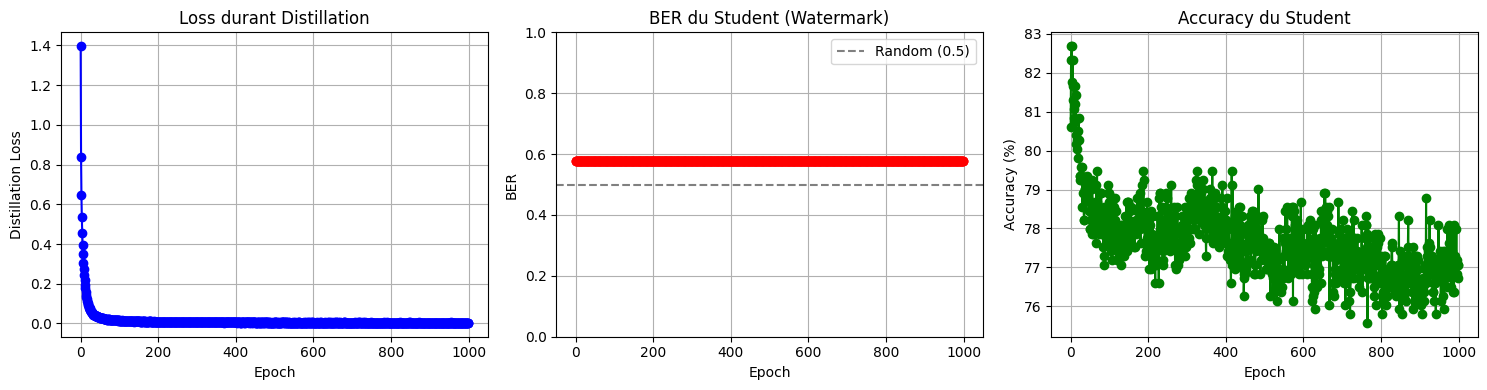


RESUME FINAL
BER Extrait : 0.00
BER Teacher (watermarke): 0.00
BER Student (apres distillation): 0.58
Accuracy Student: 77.1%

-> La marque RIGA n'a PAS survecu a la distillation (BER eleve)


In [9]:
# --- Visualisation des Resultats ---

import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Loss
axes[0].plot(attack_history["loss"], 'b-o')
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Distillation Loss")
axes[0].set_title("Loss durant Distillation")
axes[0].grid(True)

# BER
axes[1].plot(attack_history["ber"], 'r-o')
axes[1].axhline(y=0.5, color='gray', linestyle='--', label='Random (0.5)')
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("BER")
axes[1].set_title("BER du Student (Watermark)")
axes[1].set_ylim([0, 1])
axes[1].legend()
axes[1].grid(True)

# Accuracy
axes[2].plot(attack_history["acc"], 'g-o')
axes[2].set_xlabel("Epoch")
axes[2].set_ylabel("Accuracy (%)")
axes[2].set_title("Accuracy du Student")
axes[2].grid(True)

plt.tight_layout()
plt.show()

# Resume final
print("\n" + "=" * 50)
print("RESUME FINAL")
print("=" * 50)
teacher_ber, _ = riga.extract(riga.saved_keys['watermarked_model'])
print(f"BER Teacher (watermarke): {teacher_ber:.2f}")
print(f"BER Student (apres distillation): {attack_history['ber'][-1]:.2f}")
print(f"Accuracy Student: {attack_history['acc'][-1]:.1f}%")

if attack_history['ber'][-1] > 0.4:
    print("\n-> La marque RIGA n'a PAS survecu a la distillation (BER eleve)")
else:
    print("\n-> La marque Riga a survecu a la distillation (BER faible)")